In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from tqdm import tqdm
tqdm.pandas()

from utils import heston_pricer

In [2]:
import tensorflow as tf
import keras as K
from keras.callbacks import EarlyStopping

In [3]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [4]:
class FeatureScaler(object):
    def __init__(self, train):
        self.mean = train.mean(axis=0)
        self.std = train.std(axis=0)
    
    def transform(self, df):
        return (df - self.mean) / self.std
    
    def inverse_transform(self, df):
        return df * self.std + self.mean
    
    def get_params(self):
        return self.mean, self.std

In [5]:
def build_nn(input_length, hidden_layer_sizes = [20, 10, 5]):
    model = K.models.Sequential()
    kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/input_length))
    model.add(K.layers.Dense(units=hidden_layer_sizes[0], activation='relu', kernel_initializer=kernel_init, 
                             input_shape=[input_length]))
    for layer_idx in range(1, len(hidden_layer_sizes)):
        kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/hidden_layer_sizes[layer_idx-1]))
        model.add(K.layers.Dense(units=hidden_layer_sizes[layer_idx], kernel_initializer=kernel_init, activation='relu'))
    kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/hidden_layer_sizes[-1]))
    model.add(K.layers.Dense(units=1, kernel_initializer=kernel_init, activation='linear'))
    return model

In [6]:
def train_nn(X_train, Y_train, X_val, Y_val, batch_size=128, n_epochs=50, hidden_layer_sizes=[20, 10, 5], verbose=1):
    n_features = X_train.shape[1]
    model = build_nn(n_features, hidden_layer_sizes)
    
    if verbose != 0:
        print("Neural Network Architechture:")
        print(model.summary())
        print('\n')
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=verbose, mode='auto', restore_best_weights=True)
    train_log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=verbose, 
                          validation_data=(X_val, Y_val), callbacks=[early_stopping])
    
    return model, train_log.history

In [7]:
def plot_learning_history(history):
    plt.figure()
    plt.plot(history['loss'], color='b', marker='o', label='train loss')
    plt.plot(history['val_loss'], color='r', marker='o', label='val loss')
    plt.xlabel("epochs")
    plt.ylabel('loss')
    plt.legend(loc=1)
    plt.show()

In [8]:
train = pd.read_csv("./data/rBergomi/ftse_0118_train.csv").dropna()
val = pd.read_csv("./data/rBergomi/ftse_0118_val.csv").dropna()
test = pd.read_csv("./data/rBergomi/ftse_0118_test.csv").dropna()

In [9]:
train.shape, val.shape, test.shape

((263631, 9), (17560, 9), (11720, 9))

In [10]:
train = train.drop(columns=['label','index'])
val = val.drop(columns=['label','index'])
test = test.drop(columns=['label','index'])

In [11]:
train = train[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
val = val[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
test = test[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]

In [12]:
X_train_origin, Y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_val_origin, Y_val = val.iloc[:, :-1], val.iloc[:, [-1]]
X_test_origin, Y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

In [13]:
X_train_origin.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.119790,0.940696,0.041295,2.225799,-0.997984,0.165429
1,0.036204,0.947760,0.398704,1.647835,-0.836806,0.164353
2,0.154546,0.995318,0.266474,3.174934,-0.873824,0.114578
3,0.087680,0.965748,0.250895,2.512963,-0.878655,0.053254
4,0.111961,1.007250,0.310239,2.793560,-0.754466,0.108721


In [14]:
SCALER = FeatureScaler(X_train_origin)
X_train = SCALER.transform(X_train_origin)
X_val = SCALER.transform(X_val_origin)
X_test = SCALER.transform(X_test_origin)

In [15]:
X_train.shape, Y_train.shape

((263631, 6), (263631, 1))

In [16]:
X_train.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.782763,-0.509980,-1.316150,-0.351555,-1.580655,1.428017
1,-1.122477,-0.438684,-0.031326,-1.585436,0.151045,1.405011
2,1.574964,0.041318,-0.506668,1.674728,-0.246680,0.340468
3,0.050864,-0.257134,-0.562674,0.261504,-0.298577,-0.971038
4,0.604307,0.161745,-0.349342,0.860542,1.035707,0.215226


In [17]:
# parameters
hidden_layer_sizes = [20, 10, 5]
batch_size = 128
n_epochs = 50

In [18]:
model, history = train_nn(X_train, Y_train, X_val, Y_val, batch_size, n_epochs, hidden_layer_sizes, verbose=1)

Neural Network Architechture:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
2060/2060 [==============================] - 5s 2ms/step - loss: 0.0204 - val_loss: 0.0040
Epoch 2/50
2060/2060 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 3/50
2060

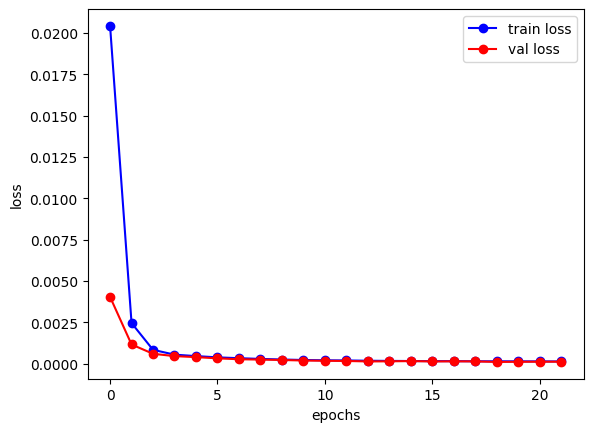

In [19]:
plot_learning_history(history)

In [20]:
model.evaluate(X_test, Y_test)

367/367 [==============================] - 1s 2ms/step - loss: 1.4114e-04


0.00014113711949903518

In [21]:
model.save("rBergomi.h5")

In [22]:
pred_test = model.predict(X_test).flatten()
true_test = Y_test.values.flatten()
relative_error = 100 * np.abs(pred_test - true_test) / true_test

In [23]:
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*len(relative_error))]
q_95 = sorted_re[int(0.95*len(relative_error))]
q_99 = sorted_re[int(0.99*len(relative_error))]

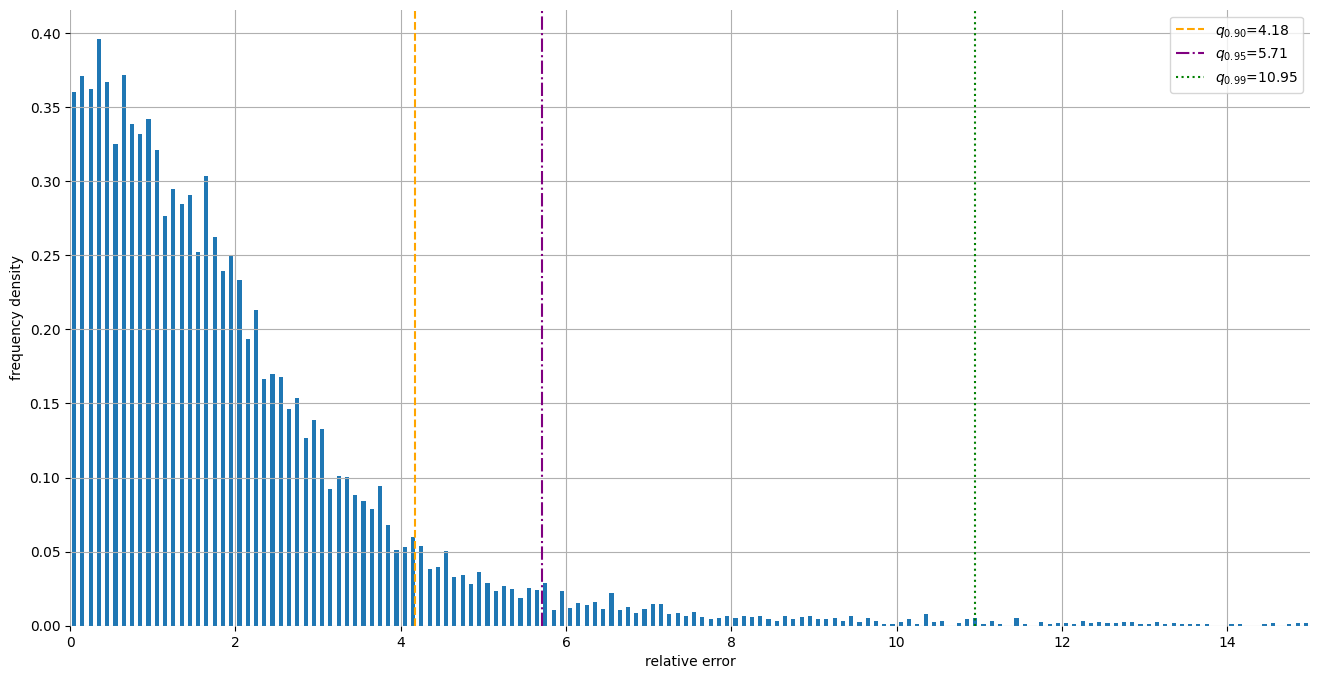

In [24]:
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 15, 151), density=True, rwidth=0.5)
plt.xlim((0, 15))
sns.despine(left=True, bottom=True, right=True)
plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange', label=r"$q_{0.90}$"+"={:.2f}".format(q_90))
plt.axvline(x=q_95, ls='-.', color='purple', label=r"$q_{0.95}$"+"={:.2f}".format(q_95))
plt.axvline(x=q_99, ls=':', color='green', label=r"$q_{0.99}$"+"={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

In [25]:
log_moneyness = np.linspace(-0.1, 0.1, 21)
maturity = np.linspace(0.01, 0.18, 18)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['Moneyness', 'Time to Maturity (years)', 'H', 'eta', 'rho', 'v0']
df = pd.DataFrame(columns=train.columns)
df['Moneyness'] = np.exp(log_moneyness.flatten())
df['Time to Maturity (years)'] = maturity.flatten()
df['H'] = 0.07
df['eta'] = 1.9
df['rho'] = -0.9
df['v0'] = 0.01

In [26]:
df = df[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
df.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0,iv
0,0.07,0.904837,0.01,1.9,-0.9,0.01,NaN
1,0.07,0.913931,0.01,1.9,-0.9,0.01,NaN
2,0.07,0.923116,0.01,1.9,-0.9,0.01,NaN
3,0.07,0.932394,0.01,1.9,-0.9,0.01,NaN
4,0.07,0.941765,0.01,1.9,-0.9,0.01,NaN


In [27]:
from utils import rBergomi_pricer

In [28]:
df['iv'] = df.progress_apply(lambda row: rBergomi_pricer(row['H'], row['eta'], row['rho'], row['v0'], 
                                                         row['Time to Maturity (years)'], row['Moneyness'], 1.0)[1], 
                             axis=1)

  1%|          | 2/378 [00:00<00:27, 13.84it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>
Y is  [[ 0.         -0.00258056  0.03112995 -0.61665975]
 [ 0.          0.40281906  0.52881075  0.49127215]
 [ 0.          0.40782442  0.43960523  0.53636842]
 ...
 [ 0.          0.58927068 -1.68848047 -0.46326685]
 [ 0.         -0.59237424  0.71220656  0.73378662]
 [ 0.         -0.22045829 -0.54260793  0.02449511]]
price is  0.09514669927135987
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  1%|          | 4/378 [00:00<00:39,  9.51it/s]

Y is  [[ 0.         -0.06244991  0.90997004  0.39580397]
 [ 0.          0.71789738 -1.21647736 -0.25277774]
 [ 0.          0.24127941  0.35238239 -1.19776533]
 ...
 [ 0.          1.29061978  0.82840608  1.17406911]
 [ 0.         -0.69140889 -0.33805405  0.05262573]
 [ 0.         -0.20814349 -0.30467202  0.36589603]]
price is  0.08610578551756423
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>
Y is  [[ 0.         -0.69187344 -1.02109528 -0.49687563]
 [ 0.         -1.23690751  0.42959504  0.113491  ]
 [ 0.         -0.50807839 -0.43259667 -0.01530146]
 ...
 [ 0.         -0.11953297 -0.55052057 -0.2466698 ]
 [ 0.          0.48723233 -0.94312021  0.02691879]
 [ 0.          0.35006274 -0.12013454 -0.48107684]]
price is  0.07693074033659868
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  2%|▏         | 6/378 [00:00<00:41,  9.01it/s]

Y is  [[ 0.         -0.95916933 -1.93812215  0.37301044]
 [ 0.          0.23499983  0.87228292 -0.40143691]
 [ 0.         -0.36106306 -0.6996442   0.73541804]
 ...
 [ 0.          0.43233004 -0.2191406   0.88484015]
 [ 0.         -0.36945631  0.53891587  0.20217151]
 [ 0.         -0.55288782 -0.06824341 -0.08088354]]
price is  0.06756410436821587
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>
Y is  [[ 0.         -0.5819997   0.7868804   0.265975  ]
 [ 0.          0.84935639 -0.27839664  0.72106795]
 [ 0.         -0.91894168  0.63996343 -0.46026278]
 ...
 [ 0.          0.03807866 -1.09019953 -1.40529216]
 [ 0.          0.10226589  0.37097565  1.24135075]
 [ 0.         -1.22036292 -0.8893129  -0.10752677]]
price is  0.058234847909019526
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  2%|▏         | 8/378 [00:00<00:41,  8.89it/s]

Y is  [[ 0.         -0.65377435 -0.30132389  0.95395894]
 [ 0.         -0.23607196 -0.68990524  1.03048515]
 [ 0.          0.23591829  0.17805664  0.32813285]
 ...
 [ 0.         -0.78336158 -1.71194466 -0.90856937]
 [ 0.          1.14470025  0.11508631 -0.73518173]
 [ 0.          0.66853859  0.85298608  0.93673532]]
price is  0.04870356362703508
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>
Y is  [[ 0.         -0.45120928 -0.54140322 -0.70472464]
 [ 0.          0.76606449  0.15045163  0.02349642]
 [ 0.         -0.98591908 -1.25002631 -0.5641921 ]
 ...
 [ 0.         -0.24830841 -0.20746084 -0.13813838]
 [ 0.         -0.22303872  0.29854221  0.99463896]
 [ 0.         -0.18837909 -0.32799988 -0.49291043]]
price is  0.03918881755504846
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  3%|▎         | 10/378 [00:01<00:43,  8.44it/s]

Y is  [[ 0.         -0.19148138  0.22441156  0.74799012]
 [ 0.          0.3017866   1.07339914  0.37805104]
 [ 0.         -0.01411317 -1.45954577 -0.84419083]
 ...
 [ 0.          0.45157534 -0.34445353  2.12791723]
 [ 0.          0.19648769  0.96285856  1.21128098]
 [ 0.          0.46340676  0.44205607  0.31424894]]
price is  0.029544552686193742
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>
Y is  [[ 0.          0.54091408  0.55402561 -0.09848526]
 [ 0.          0.23571741 -0.59204417 -0.16585795]
 [ 0.          0.05577771  0.2736629  -0.30841579]
 ...
 [ 0.         -1.06068318  0.13917619 -2.00887931]
 [ 0.          0.12203282 -1.35969301  0.28767162]
 [ 0.          0.9441963   1.31917846  0.9727258 ]]
price is  0.020007712097404776
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  3%|▎         | 12/378 [00:01<00:44,  8.14it/s]

Y is  [[ 0.          0.00533807  1.23337528 -1.00442301]
 [ 0.         -0.32992339 -0.08698522  0.62853783]
 [ 0.         -0.42713259  0.05855695  0.28111566]
 ...
 [ 0.          0.58419207 -0.28130645 -0.89172758]
 [ 0.         -0.13946424 -0.03359487 -0.84692475]
 [ 0.          0.26003976  0.22378033  0.41715681]]
price is  0.010798088559144344
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>
Y is  [[ 0.          0.57141021  0.30434553  1.67472822]
 [ 0.         -0.05415851  0.05246267 -0.35989046]
 [ 0.         -0.53701465  0.32516287 -0.70997656]
 ...
 [ 0.         -0.06169174 -0.45047688 -0.07409524]
 [ 0.         -0.06072943 -0.8527723  -1.46139854]
 [ 0.         -1.7632725  -1.83432573 -1.64772159]]
price is  0.0033235109786206303
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  4%|▎         | 14/378 [00:01<00:43,  8.33it/s]

Y is  [[ 0.         -0.4356757   0.03938579  0.10489336]
 [ 0.          0.11426285  0.21486261  0.62357121]
 [ 0.         -0.16700802 -1.66337506 -0.88578398]
 ...
 [ 0.         -0.27870966 -0.09345746  0.45450129]
 [ 0.         -0.27827383 -1.40261196  0.64969518]
 [ 0.          0.18099335 -0.37857156  0.29924684]]
price is  0.0003346918776694123
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F6F808>
Y is  [[ 0.          0.63222423 -0.28987954  0.75843262]
 [ 0.          0.8742555  -0.74570308  0.26300017]
 [ 0.         -1.54317153 -0.71062501 -2.49834698]
 ...
 [ 0.          1.08632301  0.52118222 -0.60075357]
 [ 0.         -0.59599586  0.08253134 -0.40942216]
 [ 0.         -0.1936878  -0.82946531  0.29443013]]
price is  3.3287930481161984e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  4%|▍         | 16/378 [00:01<00:43,  8.24it/s]

Y is  [[ 0.         -0.58340972 -0.95515733  0.61319043]
 [ 0.         -0.11366599  0.85373029 -2.06540361]
 [ 0.          0.53795509  0.42369625 -0.9025179 ]
 ...
 [ 0.         -0.19190675  0.24091073 -0.52788599]
 [ 0.          0.16280002 -0.14881981  0.81697833]
 [ 0.         -0.41772754  0.75637888  1.35828785]]
price is  5.3715185224097465e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F6F808>
Y is  [[ 0.          0.27627803  0.5058815  -0.09014449]
 [ 0.         -0.81407101  0.15536689  0.24949466]
 [ 0.         -0.94735911  0.50243534  0.25509163]
 ...
 [ 0.         -0.19265178  0.05268333 -0.13843006]
 [ 0.          0.09467443 -0.50981081 -0.37363395]
 [ 0.          0.95046698  0.16139457  0.48498506]]
price is  4.714773527179866e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  5%|▍         | 18/378 [00:02<00:44,  8.13it/s]

Y is  [[ 0.          1.07348709  0.31065577  0.05156092]
 [ 0.         -0.97248931 -0.32087312 -0.01192249]
 [ 0.          0.24008356  0.55111908  1.42564218]
 ...
 [ 0.         -0.30206944 -0.76765859  0.26140048]
 [ 0.          0.09569296  0.13359203  0.7384284 ]
 [ 0.          0.83383148 -0.1424138   0.35517694]]
price is  4.83073630501385e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F6F808>
Y is  [[ 0.         -0.14195337 -0.33291847  0.46742435]
 [ 0.          0.03770421  0.42260562  0.17227827]
 [ 0.         -1.10491972 -0.03295148  0.51554526]
 ...
 [ 0.         -0.36788591 -0.11646414  0.07781138]
 [ 0.          0.05651994 -0.52025989 -0.07677814]
 [ 0.          0.1333193   0.86231776 -0.33354958]]
price is  3.469941329336368e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  5%|▌         | 20/378 [00:02<00:43,  8.24it/s]

Y is  [[ 0.         -0.43742139 -0.01991755 -0.25307003]
 [ 0.          0.16974973 -0.64349734  0.36283451]
 [ 0.          0.31757799  0.3574105   1.14466626]
 ...
 [ 0.          0.8683674   0.22541349 -0.35666282]
 [ 0.         -0.09495805 -0.61156558  0.22106713]
 [ 0.          0.01972821 -0.40848087 -0.13825126]]
price is  4.392958140897019e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F6F808>
Y is  [[ 0.         -0.38302937 -0.70930517 -0.58782736]
 [ 0.          0.44634483  0.54921043  0.21626732]
 [ 0.          0.34959964  0.13787647  0.50257505]
 ...
 [ 0.         -0.33205699  0.59056588  0.39504303]
 [ 0.         -0.165566   -0.67971771 -0.54565566]
 [ 0.         -0.1554325   0.69064538  0.40347071]]
price is  6.510570412629979e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


  6%|▌         | 22/378 [00:02<00:41,  8.48it/s]

Y is  [[ 0.          0.74547849 -0.4887973   1.05840032]
 [ 0.          0.51700635  1.17260338  0.53168559]
 [ 0.          0.85524041 -0.07770573  0.2424761 ]
 ...
 [ 0.          0.78836338 -0.22477257  0.1421104 ]
 [ 0.          0.38882341 -0.2354452  -0.40049596]
 [ 0.         -1.16565163 -0.20529262 -1.1616064 ]]
price is  1.1958639790371484e-08
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F4BD88>
Y is  [[ 0.00000000e+00 -1.11112563e+00  3.10856056e-01 -6.70734203e-01]
 [ 0.00000000e+00  2.83321977e-01 -7.62503073e-01 -3.98219015e-01]
 [ 0.00000000e+00 -8.68782409e-02  4.93329091e-01  1.04032890e-03]
 ...
 [ 0.00000000e+00 -1.20192208e+00  5.11793930e-01  3.81019448e-01]
 [ 0.00000000e+00 -3.48352010e-02  1.06578439e+00  7.17700645e-01]
 [ 0.00000000e+00  2.63267661e-01  7.77727000e-01 -7.68627817e-02]]
price is  5.764937475962407e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1542749C8>


  6%|▋         | 24/378 [00:02<00:47,  7.46it/s]

Y is  [[ 0.         -1.39488517 -0.79790433 ...  0.19938603 -0.22941622
  -0.71836856]
 [ 0.          0.19732045  1.22098668 ...  0.15586226  1.38685131
  -0.77456742]
 [ 0.         -0.59985097 -0.76281515 ...  0.01931618 -0.19064641
  -0.42679525]
 ...
 [ 0.          0.42779343 -0.77914015 ... -0.08908361  0.12481521
  -0.79012227]
 [ 0.         -0.23876609 -1.27002131 ... -0.72699742 -0.92597572
  -0.20780045]
 [ 0.          0.08545183 -1.28787477 ... -0.38437637  0.17347423
  -0.19457828]]
price is  0.09527324472095199
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACA08>
Y is  [[ 0.         -1.43588664  0.64783619 ...  0.31287736 -0.36828457
  -0.40998356]
 [ 0.         -0.19088399 -0.0294608  ... -0.02269441 -1.17502107
  -0.72711426]
 [ 0.          0.13962598  0.2467678  ...  0.39111661  1.71379032
   0.29832261]
 ...
 [ 0.          0.22063025 -0.58330683 ...  0.07172296 -0.31075203
  -0.36199499]
 [ 0.          0.23194536  0.37350404 ...  0.49803268  0.38201909
   1.3

  7%|▋         | 26/378 [00:03<00:49,  7.16it/s]

Y is  [[ 0.          0.78582066 -1.63494373 ...  0.82647188 -0.46529261
   0.69369896]
 [ 0.          1.08845075 -0.5005625  ...  0.93560702 -1.17545762
   0.79536014]
 [ 0.          1.27609929  0.26133982 ... -0.71900097  1.12652662
   1.3668527 ]
 ...
 [ 0.          0.26005887  0.06244845 ...  0.79284314  0.03200075
  -0.61271198]
 [ 0.         -1.17800364  0.58571404 ...  1.35479521  0.25808479
  -0.73624255]
 [ 0.          0.37014425 -1.08309814 ...  0.80789092  0.37427108
   0.26829591]]
price is  0.07698630426342802
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACA08>
Y is  [[ 0.00000000e+00 -6.89802814e-01 -2.28823518e-01 ... -7.94354122e-01
   7.76458940e-01  1.23670654e+00]
 [ 0.00000000e+00  5.24584006e-01  6.34991821e-01 ...  1.59025874e-01
   7.79761057e-02  8.40683043e-01]
 [ 0.00000000e+00 -4.83959796e-04  4.26708274e-01 ... -9.59530866e-01
   2.05056877e-01  4.92187654e-01]
 ...
 [ 0.00000000e+00 -4.28088317e-01  2.14326626e-01 ...  9.66841365e-01
  -2.940370

  7%|▋         | 28/378 [00:03<00:50,  6.92it/s]

Y is  [[ 0.         -2.77037905 -0.09710996 ... -0.17041315 -0.35046223
  -0.26421051]
 [ 0.          0.103316    2.18326869 ...  1.39063719  0.38186646
   0.89108481]
 [ 0.         -0.60236098  0.2861488  ... -0.95978193 -1.42386002
  -0.5142265 ]
 ...
 [ 0.         -0.0156911  -0.05914092 ... -0.55188676  0.0278138
  -2.19885018]
 [ 0.         -1.39225515 -0.58179295 ...  0.05793415 -0.77193801
  -0.63459755]
 [ 0.          0.58604155  0.05718478 ...  0.24434503 -0.43174612
  -1.68918804]]
price is  0.05824174908248923
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1467649C8>
Y is  [[ 0.         -0.79478124 -0.087045   ...  0.11634049  0.06588698
   0.60304218]
 [ 0.          0.87103543  1.29406644 ...  2.31241138 -0.3792528
   1.22248276]
 [ 0.         -0.17187026 -0.59076177 ... -1.38907311  0.03598754
   0.88739244]
 ...
 [ 0.          0.24846507  0.59972265 ...  1.91286061  0.67373102
  -0.33347226]
 [ 0.          0.03990671  0.45415471 ...  1.35465657  0.82112344
   0.877

  8%|▊         | 30/378 [00:03<00:52,  6.65it/s]

Y is  [[ 0.         -0.06799382 -0.64690792 ...  1.17252754  0.09601239
   0.00272816]
 [ 0.         -0.21760799 -1.03972336 ... -0.91353302  0.5215238
  -0.15704947]
 [ 0.         -1.34262605 -0.30737236 ... -1.05949674  0.11518481
   0.77422464]
 ...
 [ 0.          0.22639476  0.93815386 ...  0.38028845 -1.33316562
   0.15731324]
 [ 0.          0.13336009  0.22928631 ...  0.01915914  0.3122243
   0.49276503]
 [ 0.          1.12284915  0.41607043 ... -0.80666996 -0.81900778
  -0.33175092]]
price is  0.03937559936250332
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466995C8>
Y is  [[ 0.          0.03401405  0.62133992 ...  1.56233295  1.49332658
  -0.13468766]
 [ 0.         -0.12020258 -0.28354941 ...  0.72613378  0.54502489
   1.00314897]
 [ 0.         -1.08263984 -1.09350648 ...  0.52383896  0.36462985
   0.52125426]
 ...
 [ 0.         -0.47356861  0.57852112 ... -1.7831522  -0.8932551
  -0.41247631]
 [ 0.         -0.19561117 -0.77763445 ... -0.47279695  0.52246873
  -0.0408

  8%|▊         | 32/378 [00:04<00:53,  6.45it/s]

Y is  [[ 0.          0.41034658  0.18020837 ... -1.15988927  0.29813594
  -0.43765871]
 [ 0.         -0.11833824 -0.03504567 ... -1.23228384 -0.85792277
   0.5281418 ]
 [ 0.         -0.46509314 -0.57995782 ...  0.32600198 -0.26134425
  -1.13816062]
 ...
 [ 0.          0.04496942 -0.07220638 ... -1.40381147  0.96657069
  -0.94224848]
 [ 0.         -1.19249112 -0.14645502 ... -0.68119401 -0.08380811
   1.70836826]
 [ 0.         -0.43488566 -0.13199231 ... -2.17762722 -1.66583467
  -0.83007434]]
price is  0.020731877990887614
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1542749C8>
Y is  [[ 0.         -0.12460103 -0.79670132 ... -1.29078295  0.09440499
  -0.19590008]
 [ 0.          1.09103607  0.22224496 ...  0.41084787 -0.41000804
   0.04538351]
 [ 0.         -1.37167079 -0.5314999  ... -0.07481602 -1.18152821
   1.04186462]
 ...
 [ 0.         -0.70399397  1.16458111 ...  0.41488678 -0.28302348
   1.21170846]
 [ 0.         -0.11309152  0.01188686 ... -0.29489548  0.28314247
   0.

  9%|▊         | 33/378 [00:04<00:52,  6.52it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463220C8>
Y is  [[ 0.         -0.86862508  0.02065748 ...  0.18730373 -0.75082642
  -0.55990778]
 [ 0.          0.31315416 -0.45094352 ...  0.81224427 -0.5656141
  -0.14574817]
 [ 0.          0.16915995  0.65148008 ...  0.09796765  1.15964234
  -0.42765159]
 ...
 [ 0.         -0.62119498 -1.2402103  ...  0.18394517  1.45037291
  -0.44810575]
 [ 0.         -0.09371376 -0.72361582 ... -0.55104824  1.90818455
   0.63126053]
 [ 0.         -1.51748806 -0.18118654 ...  0.57258637  0.07188245
  -0.21690637]]
price is  0.005002793201755449
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4AC7A08>


  9%|▉         | 35/378 [00:04<00:52,  6.55it/s]

Y is  [[ 0.          0.13775935  0.04009596 ... -0.06187893 -0.90964205
   0.34822154]
 [ 0.          0.0472121   0.24810112 ...  0.01937142 -0.56357342
  -0.69946822]
 [ 0.         -0.22344299  0.41490531 ...  1.01438172  1.26152328
   0.45934823]
 ...
 [ 0.          0.00370455 -0.61050755 ...  0.70916383 -0.15252059
   0.13114348]
 [ 0.         -0.15867195 -0.86460488 ...  0.76165523 -0.38968888
   0.29513879]
 [ 0.         -0.38882542  0.02444584 ...  0.82723169 -0.04308218
   0.28609742]]
price is  0.0011113925141486044
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1462C37C8>
Y is  [[ 0.          0.20211408 -1.29442101 ...  1.01477163  0.38920091
  -0.42211469]
 [ 0.         -0.56563853  0.83493664 ...  0.83395935 -0.46294562
  -0.06731239]
 [ 0.          0.46492781  0.69654087 ...  0.83168823 -0.06664938
   0.87692698]
 ...
 [ 0.          0.76651302  1.17463922 ...  0.2464212   0.71397173
   1.19170626]
 [ 0.          0.80178397  1.17610037 ...  0.15537495  0.18348685
  -1

 10%|▉         | 37/378 [00:04<00:52,  6.48it/s]

Y is  [[ 0.          0.88782488  0.44244245 ... -0.15195756 -1.10789923
   0.2839415 ]
 [ 0.         -0.07378161  0.47978831 ... -0.14341874 -0.25412436
  -0.92893232]
 [ 0.         -0.61762861 -0.66757573 ... -0.21228434 -0.91649249
  -0.1441982 ]
 ...
 [ 0.          1.06229621  0.86881808 ... -0.62243983  0.21841522
   0.14550133]
 [ 0.          1.31844528 -0.4376575  ...  0.37040309  0.81900387
  -0.18409864]
 [ 0.         -0.58694249 -0.59554455 ... -0.51892491 -1.07039058
  -0.55844246]]
price is  3.258344915021849e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466ECD08>
Y is  [[ 0.         -1.01373968  0.3037767  ... -0.24539751 -0.83610394
  -0.47209653]
 [ 0.          0.03953345  0.77034169 ... -0.33251141  0.18836787
  -1.18599206]
 [ 0.          0.27189301 -0.37704718 ...  0.29576325 -0.72006275
   0.7614943 ]
 ...
 [ 0.         -0.08537178  0.10292011 ... -0.22896442 -0.70017419
  -0.62251614]
 [ 0.         -0.43174407 -0.69566439 ... -0.25476942 -0.63221856
  -1

 10%|█         | 39/378 [00:05<00:52,  6.45it/s]

Y is  [[ 0.         -0.14167004  0.68997382 ...  0.67710786  0.93478366
  -0.44471705]
 [ 0.         -0.24212166  0.83682545 ... -0.75375545 -0.80090863
  -0.19388317]
 [ 0.         -0.32577041  0.6715744  ...  1.05964125 -0.74368517
  -0.25799908]
 ...
 [ 0.          0.8646541  -0.07954769 ... -0.19941391 -0.29123033
   0.52009696]
 [ 0.          0.45967491  0.22897525 ... -2.01991017  0.33876876
  -0.33813543]
 [ 0.          1.22702956 -0.33933364 ...  0.61010116  1.59251418
   0.64705546]]
price is  2.6495117766079157e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466ECD08>
Y is  [[ 0.          1.34552113  0.1959311  ...  2.12001768  0.87972175
   0.27699876]
 [ 0.          0.18815586  0.61789202 ...  0.91834572  0.53971521
   0.3948431 ]
 [ 0.          0.14266246 -0.89390672 ...  0.62164399  0.79389717
  -0.04554226]
 ...
 [ 0.         -0.24646909 -0.99748643 ... -0.5202805   0.01415364
  -0.0704227 ]
 [ 0.          1.25779858  0.05451613 ...  0.13759439  1.77796838
   

 11%|█         | 41/378 [00:05<00:53,  6.25it/s]

Y is  [[ 0.         -0.37664768 -0.76741867 ...  1.18489001  0.78470756
   1.1776839 ]
 [ 0.          0.58818293 -0.31527676 ... -1.43469446 -1.35112385
  -0.99239193]
 [ 0.          1.98078175 -0.62617635 ... -0.54563906  0.49678443
  -0.00610384]
 ...
 [ 0.         -0.69634675 -0.456218   ... -0.4234035   0.33910734
   0.45037773]
 [ 0.          1.15029032 -0.04253172 ... -0.08100325  0.88720954
   0.64234812]
 [ 0.          0.59753289 -0.69123781 ... -0.50449154  0.45518708
   0.67295545]]
price is  4.898882484542511e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146312F08>
Y is  [[ 0.00000000e+00 -7.41474934e-01 -2.03790035e-01 ... -1.85264859e+00
  -4.58661250e-04 -3.93132904e-01]
 [ 0.00000000e+00 -1.51751089e-01 -1.56357509e-01 ...  8.88216914e-01
   6.08796330e-01 -1.65654521e-01]
 [ 0.00000000e+00 -6.95104356e-03  1.31236829e-01 ... -3.41062236e-02
   6.76762204e-02  5.16828576e-01]
 ...
 [ 0.00000000e+00 -8.61251306e-01 -1.42476932e+00 ... -3.70412938e-01
   3.5042

 11%|█         | 42/378 [00:05<00:53,  6.31it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>
Y is  [[ 0.         -0.21736983  0.6745565  ... -0.28060389  0.04908367
  -0.50093677]
 [ 0.          1.03461174  0.56804266 ... -1.08686273  0.3973375
   0.12259713]
 [ 0.          0.53322331 -0.06871194 ...  0.21706693 -0.1139633
   1.11329483]
 ...
 [ 0.         -0.50663846  0.26407498 ...  0.06127263 -0.86202492
  -0.62273549]
 [ 0.         -0.36992225 -0.12382192 ... -0.73861091  0.57430757
  -0.72547242]
 [ 0.         -0.5772362   0.39062659 ...  0.3265698  -0.45676608
  -0.36400401]]
price is  0.0
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8C5488>


 12%|█▏        | 44/378 [00:05<00:54,  6.17it/s]

Y is  [[ 0.00000000e+00  1.82094749e-01  3.20304450e-01 ...  1.96660070e-01
   4.14710149e-01 -9.91033739e-04]
 [ 0.00000000e+00 -6.15825927e-01 -2.21298543e-01 ...  3.42067590e-01
   7.34130720e-01  8.80225314e-03]
 [ 0.00000000e+00 -2.15494743e-01 -8.54112601e-01 ...  6.71488431e-01
   5.10345444e-01  1.69361142e+00]
 ...
 [ 0.00000000e+00 -1.17668193e+00 -9.98157342e-01 ... -1.02055618e+00
   4.91245223e-01 -8.76821260e-01]
 [ 0.00000000e+00 -1.16217181e+00 -1.73890307e-01 ... -1.83211649e+00
  -9.02893402e-01 -2.41118179e+00]
 [ 0.00000000e+00 -3.80953831e-01  2.46173809e-02 ... -1.45934070e+00
  -6.11749735e-01  2.92814600e-01]]
price is  0.0
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>
Y is  [[ 0.         -0.2859366   0.16114858 ... -0.9940775  -0.39502046
   1.03630978]
 [ 0.         -0.52183785 -1.05917875 ... -0.77001738 -0.58547346
  -0.79118294]
 [ 0.          0.17105992 -1.39642041 ...  0.4885289   0.18953105
   1.59347196]
 ...
 [ 0.         -1.07191336

 12%|█▏        | 45/378 [00:06<00:56,  5.94it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>
Y is  [[ 0.         -0.01268827  0.05938369 ...  0.28662664  0.2718815
   0.22541297]
 [ 0.         -0.72679707 -0.32719723 ...  1.13959863  0.09303115
  -0.8836494 ]
 [ 0.         -0.09576288 -0.15229921 ... -0.09670429  1.58623926
  -0.18401488]
 ...
 [ 0.          0.19974907  0.24906669 ...  1.93503841  0.40693377
   0.77504831]
 [ 0.         -0.0944258  -0.11495294 ...  0.61081549  0.85416221
   0.07283531]
 [ 0.          0.92358192  0.38884624 ... -0.03950585 -0.59564781
  -0.25249434]]
price is  0.08613277558725929
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 12%|█▏        | 46/378 [00:06<00:56,  5.84it/s]

Y is  [[ 0.          1.06129876  1.06952551 ...  2.07485244  1.53720736
   0.56158595]
 [ 0.          1.4805652   0.08206667 ...  0.2822224   0.26868281
   0.27924014]
 [ 0.          0.85484793  0.1252013  ... -1.65261456 -0.31580703
  -0.45383588]
 ...
 [ 0.         -0.28384422 -0.08282184 ...  0.54318047 -0.11795258
   0.0110664 ]
 [ 0.          0.13690996 -0.11672465 ... -0.73479588 -0.6934853
  -0.55674242]
 [ 0.         -0.06126992  0.99178001 ... -1.13292412  0.26833162
  -0.42581418]]
price is  0.07693170444822714
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8C5488>
Y is  [[ 0.          1.43991145  0.62563505 ... -0.68704283  1.40084289
   0.87499845]
 [ 0.         -1.28054449  0.33433732 ...  0.64586139 -0.26367999
   0.38366619]
 [ 0.         -0.1328229   1.66586896 ... -0.3601657  -0.46130629
   0.93925419]
 ...
 [ 0.         -0.79489947  0.71240203 ... -0.04849927  0.52802961
  -0.57342667]
 [ 0.          0.62827968 -0.12688787 ...  0.62118094  0.30273219
  -0.22

 13%|█▎        | 48/378 [00:06<00:58,  5.61it/s]

price is  0.0677303473598887
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05788>
Y is  [[ 0.          0.23884553  0.95893905 ...  0.35248722 -0.02256101
  -0.40601944]
 [ 0.          0.18366034  1.09571703 ...  1.39179976  0.97332432
   1.31963521]
 [ 0.          0.26603404 -0.27145014 ...  0.40463029 -0.44401568
   0.3854035 ]
 ...
 [ 0.         -0.29934751  0.513533   ... -0.57098266  0.97770693
   0.94155887]
 [ 0.          0.13390935  0.07482833 ... -0.89977706 -0.37093912
  -1.52700588]
 [ 0.         -0.998873    0.29178505 ... -1.90541956 -2.01023357
  -2.66400328]]
price is  0.05824769717788877


 13%|█▎        | 49/378 [00:06<00:58,  5.65it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACA08>
Y is  [[ 0.          0.09401603  1.30700854 ...  0.37725142  0.10302577
   0.29874648]
 [ 0.          0.56530191  0.14262322 ... -0.4475367  -0.84324
  -1.11212847]
 [ 0.         -0.24072545  0.40427086 ... -0.31560401 -0.4254073
   0.87608193]
 ...
 [ 0.          0.83710103 -0.2579082  ... -1.13433577 -0.03186081
   0.77517221]
 [ 0.         -0.19104321 -0.17650036 ...  0.2934803  -0.31296045
  -0.89158341]
 [ 0.          0.03192142 -0.74858232 ... -0.23791386 -0.97436331
  -0.40204465]]
price is  0.04915706356013685
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 13%|█▎        | 51/378 [00:07<00:56,  5.78it/s]

Y is  [[ 0.00000000e+00  5.73169320e-01  2.82423531e-01 ... -8.66212249e-01
  -1.36780662e+00  9.98534239e-01]
 [ 0.00000000e+00 -1.00160812e+00  1.25232156e-01 ...  4.10872196e-02
   5.25508059e-01  1.00787996e+00]
 [ 0.00000000e+00 -1.72203795e-01  1.75090670e-01 ... -9.33495826e-02
  -3.57092044e-01 -4.89493992e-01]
 ...
 [ 0.00000000e+00 -2.95305664e-01 -1.02225243e-01 ...  1.26664615e+00
  -5.42775527e-01  6.72507023e-02]
 [ 0.00000000e+00  7.94133677e-04 -1.64850576e-01 ... -2.20869106e-01
  -1.04091646e+00 -1.11124316e+00]
 [ 0.00000000e+00  7.75062988e-01  1.26563361e-01 ... -1.97489711e-01
   4.49069644e-01  8.28406786e-01]]
price is  0.03959619000455537
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>
Y is  [[ 0.         -0.7488623   0.22334282 ...  1.11759189  1.02051985
   0.24386767]
 [ 0.         -0.50699776  0.50367501 ... -1.11189732 -1.02266183
  -1.63235543]
 [ 0.          0.65511322 -0.47495727 ...  0.15380217 -1.03703398
   0.21004678]
 ...
 [ 0.    

 14%|█▍        | 52/378 [00:07<00:56,  5.75it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05788>
Y is  [[ 0.         -0.53649768  0.11881356 ... -1.4974717  -0.92600179
  -0.45872487]
 [ 0.          0.10597731  0.31045492 ... -0.96550736 -1.64896409
  -1.42146734]
 [ 0.         -0.16634744  0.10041165 ...  0.4908863   0.47764318
  -0.86788068]
 ...
 [ 0.         -0.34502639  0.16696443 ...  0.06423778  0.68553942
   0.5581871 ]
 [ 0.          0.644682   -0.92839791 ...  0.97138734 -0.06849374
   1.00864083]
 [ 0.          0.26334755 -0.42016933 ...  0.42465721 -0.08222421
   1.44131964]]
price is  0.02129054770494052
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 14%|█▍        | 53/378 [00:07<00:57,  5.61it/s]

Y is  [[ 0.         -0.27366988  0.12584268 ...  1.02404652  1.21823272
   0.04039864]
 [ 0.          0.20072128 -0.22902367 ... -0.85663331 -1.86080499
  -0.51860266]
 [ 0.          0.25885326 -0.79410722 ... -0.08070296 -0.47670952
  -0.26048558]
 ...
 [ 0.          0.08957119 -0.39001416 ...  0.60252343 -0.51349062
  -0.00365552]
 [ 0.          0.73566351  0.59617231 ...  0.4047617  -0.82264292
   0.32055746]
 [ 0.          0.0843779  -0.36155275 ... -0.8864751  -1.08098868
   0.43404013]]
price is  0.012802095961538777
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05788>
Y is  [[ 0.          0.227051    0.34158916 ... -0.50733601  0.23224519
  -0.18348145]
 [ 0.          0.42768914  0.6929458  ...  0.13177356  0.55736427
   0.98726582]
 [ 0.          0.44541204  0.09630137 ... -0.50044719 -0.4348435
  -0.48806368]
 ...
 [ 0.         -0.74719111 -1.41159468 ...  0.5376579  -0.66795711
   0.72819528]
 [ 0.         -0.1710106   0.83030445 ...  0.21431463  1.46558524
   1.2

 15%|█▍        | 55/378 [00:07<01:00,  5.30it/s]

price is  0.005916600618072326
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>
Y is  [[ 0.         -0.64717849  1.01963485 ...  1.10839104  0.41782212
   0.32176247]
 [ 0.          0.07516686  0.13011029 ...  0.21117093 -0.57635052
  -0.03014539]
 [ 0.         -0.34157793 -0.08155237 ... -1.1147918   0.02551864
  -0.3292344 ]
 ...
 [ 0.          0.73306597 -2.17445693 ... -0.82958438  0.62932282
   0.23170025]
 [ 0.         -0.33507548 -0.32711639 ... -0.21810869 -0.77021318
   1.05736786]
 [ 0.         -0.14111016  0.37183517 ...  0.0545634   0.36532376
   0.62525163]]
price is  0.0017125544917362533


 15%|█▍        | 56/378 [00:08<01:00,  5.34it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECC766C8>
Y is  [[ 0.          0.61637309  1.922509   ...  0.62584353  0.92585602
   0.06177321]
 [ 0.         -0.86964501  0.56825031 ...  0.35401351 -1.02388942
   0.50123215]
 [ 0.          0.21070537 -1.03131828 ... -0.05190685 -0.45116022
   0.71413145]
 ...
 [ 0.         -0.40862331  0.06074426 ... -0.99440234 -1.41920847
  -1.84665382]
 [ 0.         -0.48825952 -0.13518428 ... -0.17992057 -0.17929618
   0.0425231 ]
 [ 0.         -0.44078014  1.37318354 ...  0.52300113 -0.16897831
  -0.16628204]]
price is  0.0003021999911709348


 15%|█▌        | 57/378 [00:08<00:57,  5.56it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>
Y is  [[ 0.         -0.14370248  0.29454283 ... -0.05118791 -0.43226546
  -0.36133153]
 [ 0.          0.16974282  0.37454507 ... -0.49840631 -0.24900654
   0.40663219]
 [ 0.         -0.66303469  1.08210216 ... -0.32105234 -0.5166769
   0.18670119]
 ...
 [ 0.          0.18004456  0.05281443 ...  0.57840317  1.17057831
   0.06493847]
 [ 0.         -0.4284021  -0.12295628 ... -0.31749843  1.03711184
  -0.60578817]
 [ 0.         -0.10465487  1.50529561 ... -0.12028724 -0.24815349
   0.25398586]]
price is  5.983212463571967e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 16%|█▌        | 59/378 [00:08<00:55,  5.71it/s]

Y is  [[ 0.          0.63676831  0.00910727 ... -2.02062885  0.24527025
   0.24572003]
 [ 0.          0.8356498  -0.89624785 ...  0.03125858 -0.47985201
  -0.48798044]
 [ 0.          0.85164392  0.65351138 ...  1.46522987  0.23175944
   0.39979661]
 ...
 [ 0.          0.24792864  0.67561611 ...  1.01603935  0.5554849
   1.03634808]
 [ 0.          0.38562286  0.03514299 ... -0.88194887 -0.67719607
  -0.42962854]
 [ 0.         -0.21874843 -1.15383273 ...  1.04193761  0.76238505
   0.23684668]]
price is  2.4564634380725008e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>
Y is  [[ 0.         -0.5396055   0.10892729 ... -0.29373718 -0.51434207
  -0.8135937 ]
 [ 0.         -0.28958918  0.10943671 ...  0.48213865  0.51397655
   0.06616054]
 [ 0.          0.42644379  0.47361226 ... -0.45786987 -0.55642361
  -1.46469966]
 ...
 [ 0.          0.65850144  0.82800469 ...  0.38874305  1.79745447
   0.2143732 ]
 [ 0.         -0.28622915  1.43758556 ... -0.21178887 -1.14010125
  -0

 16%|█▌        | 60/378 [00:08<00:56,  5.66it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A75C48>
Y is  [[ 0.          0.92357147  1.04626771 ...  0.47601698  0.98763936
   1.83219298]
 [ 0.          0.02345296  0.1710154  ...  0.46065326 -0.50225906
   0.25615589]
 [ 0.          0.36052568 -1.88889165 ... -1.13285698 -1.27828528
  -1.27011885]
 ...
 [ 0.         -0.37292569 -0.42486598 ... -0.91516789  0.66656688
   0.41933546]
 [ 0.         -0.13928376 -0.21042891 ... -0.35270164 -0.82354626
  -0.44644351]
 [ 0.          0.24946211  0.14644351 ... -0.1560391  -1.06220546
   0.15065421]]
price is  4.63219464884535e-06


 16%|█▌        | 61/378 [00:09<00:56,  5.58it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>
Y is  [[ 0.         -0.87733842 -0.47019389 ... -0.56783724  0.13438421
  -0.46211768]
 [ 0.         -0.75605194 -1.29956192 ... -0.04210759  1.30003916
   0.05380511]
 [ 0.          1.20303117  0.6405263  ... -0.47293746  0.08914679
   0.60537012]
 ...
 [ 0.         -0.14509714  0.19980907 ... -0.2845191   0.85839228
   0.69430981]
 [ 0.         -0.72235996 -1.83147165 ... -1.51949673 -0.22922057
   0.05809398]
 [ 0.          0.2193505   1.01803829 ...  0.06964931  2.1538872
   0.79231516]]
price is  1.631919247835345e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 17%|█▋        | 63/378 [00:09<00:55,  5.72it/s]

Y is  [[ 0.          0.20321814  0.41987081 ...  0.65354717  1.41673342
   0.71744254]
 [ 0.         -0.54011949 -0.00752964 ...  1.2063589  -0.09232147
   0.15296135]
 [ 0.         -0.95925284 -0.21566057 ... -0.92704543  0.00731297
  -0.41655457]
 ...
 [ 0.          0.18933081  1.13464239 ... -0.179259    0.92898378
   0.19739115]
 [ 0.         -1.13817129 -0.77576103 ...  0.13247499  0.72814165
  -0.43738805]
 [ 0.          0.56370682  0.47242786 ...  0.57985698  0.02094778
   1.32862511]]
price is  7.684325968820183e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECC766C8>
Y is  [[ 0.          1.19971742 -0.13961299 ...  0.78915831 -0.28099928
   0.69796346]
 [ 0.          0.54258479 -0.2318798  ...  1.21901991  1.49118055
   0.92233266]
 [ 0.         -0.58763888  0.44647479 ... -0.1852537  -0.48599982
  -1.48799826]
 ...
 [ 0.          1.24887153 -0.0197593  ...  0.73768703  1.67865234
   0.60909085]
 [ 0.          0.43871137  1.56857876 ...  0.44950288  1.56270997
  -0

 17%|█▋        | 64/378 [00:09<00:54,  5.77it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320508>
Y is  [[ 0.          0.21174333 -0.15162438 ... -1.66964885 -0.28434385
   1.34335978]
 [ 0.          0.29139423  0.55248466 ...  0.29401869  0.34770451
  -1.44387578]
 [ 0.         -0.09042995  0.02363201 ... -0.65646832  0.00270184
  -0.23134081]
 ...
 [ 0.         -0.11822024  0.53167313 ... -0.75993925 -0.41465968
   0.93203685]
 [ 0.          1.30173534  0.08631543 ...  1.02304412  0.99050835
  -1.10200694]
 [ 0.         -0.55726376  0.58264336 ...  0.12471543  0.28466921
   0.07734747]]
price is  3.786527683555918e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327308>


 17%|█▋        | 65/378 [00:09<00:57,  5.43it/s]

Y is  [[ 0.         -0.59704809 -1.30457688 ... -0.19743891  0.93949798
  -0.07432458]
 [ 0.          0.39448663  0.66235823 ... -1.18618744  1.27309461
  -0.37113407]
 [ 0.         -0.0142517  -1.16011689 ...  0.94252485  1.64678012
   0.23779597]
 ...
 [ 0.          0.20870619 -1.06149519 ...  0.73992967  0.27312232
   0.61252424]
 [ 0.          0.02896737 -0.266763   ... -0.08976548  0.02596482
   1.89801046]
 [ 0.          0.69787016  0.44644073 ...  0.53572509  0.77587735
  -0.11255421]]
price is  0.09509070039742056
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>
Y is  [[ 0.         -0.02050103  0.58728743 ...  0.68513124 -0.44673824
  -0.01604091]
 [ 0.          0.89266722  0.38555702 ...  1.41218037  1.23041285
   1.71498621]
 [ 0.         -0.47728919  0.37092136 ... -1.4856892  -0.76775978
  -0.42553072]
 ...
 [ 0.         -0.09446743  0.60346718 ...  0.18904856 -0.9915837
  -0.32668614]
 [ 0.         -0.07581645 -0.35905147 ...  0.93233833 -0.38197759
  -0.28

 18%|█▊        | 67/378 [00:10<00:59,  5.21it/s]

price is  0.0860778750413
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A808>
Y is  [[ 0.          0.67990761 -0.37577965 ... -0.65652294 -0.33761339
  -0.64645096]
 [ 0.         -0.17136086  0.34210516 ...  0.16260064  0.6110365
   0.12630589]
 [ 0.         -0.37059411  0.87739366 ...  0.22113074  0.26514607
   0.37288903]
 ...
 [ 0.          0.39014072  1.04213211 ... -0.40294924 -1.75998455
   0.51875474]
 [ 0.          0.16302208 -0.61188133 ...  0.74487995  0.46133509
   0.95318112]
 [ 0.         -1.70728832  0.14652237 ... -0.47786743 -0.17550954
  -0.36123636]]
price is  0.07711692368231583
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECC766C8>
Y is  [[ 0.         -1.42145176 -0.75964797 ... -1.24045877 -1.09030671
   0.44911347]
 [ 0.          0.31826445  0.18504492 ...  0.57128779  1.87347392
   0.46971274]
 [ 0.         -0.30611831 -0.41334094 ...  0.00342862 -0.30833157
   0.34380008]
 ...
 [ 0.         -0.03561035 -1.04934596 ... -0.56718134 -0.779435

 18%|█▊        | 69/378 [00:10<01:02,  4.98it/s]

price is  0.0678289331106424
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>
Y is  [[ 0.          0.34366927  1.70695088 ...  1.08835771  0.09144779
  -0.09733602]
 [ 0.         -0.8193686  -0.1969296  ... -0.87837904 -1.72793848
  -1.00396177]
 [ 0.         -0.5394029  -0.75755186 ... -0.25164043 -0.58604471
   0.50586834]
 ...
 [ 0.         -0.12694372  0.94429799 ... -0.38235104 -0.0971678
  -0.23388825]
 [ 0.          1.474597   -0.6542232  ...  0.29752469 -0.29300327
   0.32270721]
 [ 0.          0.75416232  0.27454123 ...  1.52068607  0.97719242
   1.96742738]]
price is  0.05850731118511694
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A75C48>
Y is  [[ 0.00000000e+00  8.64834922e-02  6.29092723e-01 ... -6.37081814e-01
  -6.09015033e-01 -8.43513491e-01]
 [ 0.00000000e+00  1.52747131e+00  8.49895190e-04 ... -6.52619166e-01
  -1.69273175e-01  9.40030202e-01]
 [ 0.00000000e+00 -1.34964438e-01  1.37749065e+00 ...  6.60263525e-01
   2.43728147e-01  1.0281999

 19%|█▊        | 70/378 [00:10<01:02,  4.95it/s]

price is  0.04924975438302254
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327308>
Y is  [[ 0.         -1.09150145 -0.5615013  ... -0.54167815 -0.00592399
   0.42204937]
 [ 0.          0.49673334  0.0519149  ...  0.42316237  1.07884303
   0.61582678]
 [ 0.         -0.25601003 -0.11019333 ... -1.02742337 -1.47194252
  -1.18344731]
 ...
 [ 0.          0.07798899  0.3248333  ...  0.25242166  0.33780904
   0.47946283]
 [ 0.         -0.05261116 -0.5479543  ... -0.95137517 -0.4858252
   0.89264257]
 [ 0.         -1.03680772 -0.15354287 ... -0.77461362 -0.4076622
  -0.95791922]]


 19%|█▉        | 72/378 [00:11<01:01,  4.97it/s]

price is  0.039911721425495955
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>
Y is  [[ 0.          0.5359202   1.0387167  ...  0.49792303 -0.34243554
   0.47788861]
 [ 0.          0.52554884  0.94676452 ... -0.86011188  0.08928398
   0.1216706 ]
 [ 0.         -0.27558109 -0.4218012  ... -0.0504045   0.41764229
  -0.25729653]
 ...
 [ 0.         -0.04020696 -0.58600794 ...  1.801445    0.88382098
   0.67779942]
 [ 0.         -0.22635919  0.16130567 ... -1.08874519  0.94561754
   0.33050007]
 [ 0.          0.3530907   0.25460019 ...  1.16135227  0.01116492
  -0.14139059]]
price is  0.030900901170309424


 19%|█▉        | 73/378 [00:11<01:01,  4.93it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>
Y is  [[ 0.          1.08958666 -0.44896168 ... -0.34294169 -1.60212494
  -1.08341117]
 [ 0.          0.51951419 -0.74707757 ... -0.95111532 -0.91971431
  -2.4115576 ]
 [ 0.          0.57157607 -0.16453375 ... -0.97309482  0.24412416
   1.32449076]
 ...
 [ 0.         -0.08696004  0.06540634 ...  0.73656464 -1.09935161
   0.73611414]
 [ 0.          0.01190567 -0.11876755 ... -0.42439818  0.43526067
  -0.83191429]
 [ 0.         -0.07720189 -0.12264486 ...  0.25324811 -0.54929414
  -0.70595871]]
price is  0.02200819221645097
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>
Y is  [[ 0.         -0.4362738  -0.48301098 ... -2.41013449  0.47439165
   0.84610743]
 [ 0.          0.30125096  0.4453389  ... -0.58825659 -0.71342874
  -0.75437331]
 [ 0.         -0.32798991  0.7135391  ...  0.09415531  2.13321669
   0.92132187]
 ...
 [ 0.          0.13082806 -0.73657025 ... -0.36111785 -1.28744794
  -1.21141552]
 [ 0.  

 20%|█▉        | 75/378 [00:11<01:02,  4.84it/s]

price is  0.01390165456434295
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>
Y is  [[ 0.         -0.1862314   0.86509133 ... -1.10567728 -1.15987021
  -0.20260442]
 [ 0.          0.39409424  0.30985715 ... -0.25635548 -0.14327952
   0.04781237]
 [ 0.         -0.15853501 -0.22056038 ... -1.00514913 -0.01751601
  -0.01534524]
 ...
 [ 0.          0.72129986  0.64387695 ...  0.7754205  -0.01724491
   0.12561221]
 [ 0.          0.24502022 -0.87248936 ... -0.22916983  0.18442109
  -0.29369999]
 [ 0.          0.85705656  0.89071549 ...  0.22441722  0.26217825
   0.05852861]]
price is  0.007078250063757564
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>
Y is  [[ 0.         -0.57161386 -0.85437986 ... -0.6755231  -0.09249601
  -0.86724409]
 [ 0.         -0.10674121 -0.99690365 ... -0.87257792  0.5097276
  -1.26187698]
 [ 0.         -0.60608705 -0.77635507 ... -1.33645394 -1.0118718
  -1.20840274]
 ...
 [ 0.         -1.19126338  0.78952527 ... -0.10501712 -0.28

 20%|██        | 76/378 [00:12<01:02,  4.82it/s]

price is  0.0025052245053652123
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>
Y is  [[ 0.         -0.4110131  -0.33864919 ...  0.40113021  0.50526526
  -0.32629698]
 [ 0.         -0.5010469   0.54166675 ...  0.44046709  1.4951887
   0.78446795]
 [ 0.         -0.15477279 -1.11861648 ... -1.00067302  0.36184747
  -0.29140641]
 ...
 [ 0.          0.43069655  0.90913492 ...  0.76614069 -0.12513605
  -0.64300062]
 [ 0.         -0.0881774  -0.63263823 ...  0.39221453  0.23741636
   1.06689995]
 [ 0.         -0.07479747  0.10856488 ...  1.59334008  0.5751165
  -1.57521212]]


 20%|██        | 77/378 [00:12<01:02,  4.83it/s]

price is  0.0005922082876944384
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>
Y is  [[ 0.         -0.09664423  0.93469893 ...  0.58285643  0.76249257
   0.77751077]
 [ 0.         -0.27927227 -0.64343489 ...  0.96476388  0.96614716
   0.18268402]
 [ 0.          1.54723479  0.18463223 ... -0.19199877 -0.32681829
   0.42122763]
 ...
 [ 0.         -0.03901079 -0.31165419 ... -0.12762491 -0.0848756
   0.93635385]
 [ 0.         -0.12629555 -0.21005358 ... -0.86484929  0.11257785
   0.50466282]
 [ 0.          0.09985718  0.22718987 ... -0.10103383  0.4570386
  -0.54087468]]
price is  0.0001273653747744237


 21%|██        | 78/378 [00:12<01:01,  4.85it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>
Y is  [[ 0.          1.10995335 -0.28755417 ...  0.02005674  0.41504694
   0.42380055]
 [ 0.         -0.8174704  -0.80054119 ... -1.51341416 -0.40731682
  -0.45488549]
 [ 0.          0.51818196  0.55885929 ... -0.30965468 -0.10365044
  -0.3554127 ]
 ...
 [ 0.          0.45585309 -0.63599404 ... -1.27217933 -1.14999602
  -0.56853964]
 [ 0.          0.81917393  0.71843261 ...  0.24873706  0.08895074
   1.08430779]
 [ 0.         -0.28765877 -0.69360567 ... -1.2908359  -2.55092135
  -0.3531865 ]]


 21%|██        | 80/378 [00:12<01:00,  4.95it/s]

price is  3.49800668441885e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327308>
Y is  [[ 0.          0.27603747 -0.20206645 ...  0.32394588  0.05681318
   0.527372  ]
 [ 0.          0.47384252  0.5972947  ... -0.68018536 -0.77241032
  -0.45183366]
 [ 0.          0.05519424  0.01836021 ... -0.56902682  0.87628327
   0.30966736]
 ...
 [ 0.         -0.64959217  1.29584956 ...  0.9360643   0.30989309
  -0.86861894]
 [ 0.         -0.48206913  0.54283635 ... -1.2195503  -0.2067592
  -0.14801473]
 [ 0.          0.35481925  0.14827309 ...  0.80087325  0.01528889
  -0.18784143]]
price is  1.413447900204503e-05


 21%|██▏       | 81/378 [00:13<01:00,  4.91it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>
Y is  [[ 0.         -0.39657426  0.0302231  ...  0.87252644  1.46783631
   0.34613045]
 [ 0.         -0.1672337   0.62763783 ...  0.64664808  0.0442778
   0.33949272]
 [ 0.         -0.48288126 -0.05245933 ...  0.71254565  0.2386222
  -1.4913589 ]
 ...
 [ 0.         -0.19491577  0.21669014 ... -0.08329196  0.55872879
   1.3914328 ]
 [ 0.         -0.08665322 -0.61577557 ... -0.56303446 -1.35089402
  -0.80852546]
 [ 0.         -0.92289404 -0.6325642  ... -0.05479861 -0.87720703
   0.3929387 ]]
price is  6.263625558145108e-06


 22%|██▏       | 82/378 [00:13<00:58,  5.04it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327308>
Y is  [[ 0.          0.64462983  0.13985712 ...  0.53435324 -0.83484339
   0.62472906]
 [ 0.          0.37354128  0.40743832 ...  0.59914728  0.76077428
   1.4616798 ]
 [ 0.         -1.20383574 -0.47562329 ... -0.52620938  0.27367199
  -1.0424942 ]
 ...
 [ 0.          0.67676044 -0.62380166 ... -0.59762776 -0.89593058
   0.11211411]
 [ 0.         -1.15828817  0.48630772 ... -0.30349298 -0.39927435
   0.28644857]
 [ 0.         -0.21505966  0.43522731 ... -0.21708167  0.06317318
   0.30355755]]
price is  3.3819595007918314e-06


 22%|██▏       | 83/378 [00:13<00:59,  4.94it/s]

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>
Y is  [[ 0.         -1.18903034 -0.40047106 ...  0.07355913  0.42980849
  -0.0211922 ]
 [ 0.          0.6847208  -0.60187639 ...  0.77889588  0.09390385
  -0.5554045 ]
 [ 0.         -0.04101775  0.2092906  ... -0.37781438 -0.62828593
   0.27394187]
 ...
 [ 0.          0.35541754  0.18366112 ...  0.4158744  -0.5728274
  -1.86065062]
 [ 0.         -0.5010937  -0.43863873 ... -0.52904652 -0.38102189
  -2.38228009]
 [ 0.          0.63987735 -0.14948602 ... -0.76680666 -0.59570891
  -0.23333763]]
price is  2.907322751976665e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>
Y is  [[ 0.          0.70100601  0.12281827 ... -1.99385682 -0.65319017
   0.38085268]
 [ 0.          0.75392335  0.17418008 ... -1.21044583 -0.79257393
  -0.37255876]
 [ 0.         -0.72004409  0.11145171 ...  0.17688881 -0.0904308
  -0.14303444]
 ...
 [ 0.          0.33767117 -0.32467331 ...  1.25171734  1.73998412
   1.4693839 ]
 [ 0.  

 22%|██▏       | 84/378 [00:13<01:00,  4.83it/s]

price is  8.290035706245313e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466AD288>
Y is  [[ 0.          0.5355905  -0.38000891 ...  2.09445194  1.09077935
   0.2951419 ]
 [ 0.          0.26081896  0.8505369  ... -0.87436581 -0.08045813
  -0.52970728]
 [ 0.          0.09023094  0.29807557 ... -0.27439899 -0.88722464
  -0.20470363]
 ...
 [ 0.          0.12132594 -0.54275286 ... -1.3506808  -1.03571219
  -1.10321588]
 [ 0.         -0.36736959  0.33406026 ... -0.82930202  0.25094257
   1.20296249]
 [ 0.         -0.81067085  0.33661212 ...  1.29807181  1.21563942
   0.95031591]]


 22%|██▏       | 85/378 [00:13<01:01,  4.74it/s]

price is  0.0
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327308>
Y is  [[ 0.         -0.28046935 -0.76709239 ...  0.7945607  -0.20460659
   1.44712345]
 [ 0.         -1.858984   -0.34093771 ... -0.39710182  0.50994255
  -0.34122858]
 [ 0.         -0.42728264 -0.12532778 ... -0.61053865  1.47558848
   0.2197529 ]
 ...
 [ 0.          0.18146237  0.84470902 ... -0.49380482  1.19832302
  -0.17333135]
 [ 0.          0.76473626 -0.10045605 ...  0.01947794  0.2733163
  -0.66304791]
 [ 0.          1.42162981  0.31726805 ... -0.51066821 -0.3790429
   0.49858311]]


 23%|██▎       | 86/378 [00:14<01:04,  4.56it/s]

price is  0.0952443519696284
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 23%|██▎       | 87/378 [00:14<01:05,  4.41it/s]

Y is  [[ 0.         -0.09044769 -0.50419742 ...  0.19247984  0.14264741
  -0.79741815]
 [ 0.          0.28365567 -0.74294392 ...  0.07587015 -0.34511184
  -1.2794492 ]
 [ 0.         -1.05657224 -1.12813553 ...  0.57884306  1.13031096
   0.61084099]
 ...
 [ 0.         -1.06426922 -1.30268701 ...  0.51234585 -0.40695726
  -0.27418106]
 [ 0.         -0.48902822 -0.7040719  ... -0.8178911  -1.0881508
  -0.20292598]
 [ 0.          1.20925216  0.4136841  ...  0.35448361 -0.3783874
  -0.09946594]]
price is  0.0862176296613854
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 23%|██▎       | 88/378 [00:14<01:05,  4.41it/s]

Y is  [[ 0.          0.71110492 -0.08880528 ... -0.21673684 -1.84225171
  -1.37937679]
 [ 0.          0.12405101  1.17932686 ...  0.21437222  1.03108407
   0.35970737]
 [ 0.          0.17332922 -0.52881839 ...  0.51081984  0.11787861
  -0.41330967]
 ...
 [ 0.          0.81674823  0.25411142 ... -0.39034092  0.22855802
   0.73737128]
 [ 0.         -0.70194891 -0.19179519 ... -0.37005456 -0.69600772
  -0.7213426 ]
 [ 0.         -0.86105665 -1.14100901 ...  0.6209401   0.35022255
   0.28211298]]
price is  0.07699726985019532
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320588>


 24%|██▎       | 89/378 [00:14<01:05,  4.43it/s]

Y is  [[ 0.          0.54406933  0.650329   ...  0.8374171   1.07202855
   1.43608753]
 [ 0.         -0.04448015 -0.47371432 ...  0.30963496  0.68313433
   0.92892799]
 [ 0.         -0.25565084 -0.55045434 ... -1.03072583 -0.30668437
  -1.09614024]
 ...
 [ 0.          0.49405082  1.24682985 ... -0.35047956  0.03629912
  -0.86197498]
 [ 0.         -0.06046623 -0.07641349 ... -0.4294517  -0.52283285
  -0.86153755]
 [ 0.          1.33645486  1.16696759 ...  0.82705014  0.27837356
   0.89162307]]
price is  0.06797490335233021
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECC766C8>


 24%|██▍       | 90/378 [00:15<01:05,  4.37it/s]

Y is  [[ 0.         -0.04162276  0.34125604 ...  0.06676332 -0.1564554
   0.51836407]
 [ 0.         -0.46233043 -0.29818762 ...  0.40394941  0.40648865
  -0.23126459]
 [ 0.         -0.07668148 -1.2453143  ... -0.18069948 -0.60596093
   0.92349655]
 ...
 [ 0.          0.39724852 -0.23941084 ... -0.98590308 -0.30092674
   0.04285945]
 [ 0.          0.28092781 -0.3806628  ... -0.52935146 -0.3700798
  -1.32453694]
 [ 0.          0.23556146 -0.36673739 ... -0.45389806 -0.38347669
  -1.53593184]]
price is  0.0586643153659365
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 24%|██▍       | 91/378 [00:15<01:05,  4.35it/s]

Y is  [[ 0.          0.84928266 -0.02972336 ... -0.62282499 -0.17360173
   0.44538433]
 [ 0.         -0.33297537 -0.57026617 ...  0.55926812 -0.95284061
   0.18874543]
 [ 0.         -0.88194416 -1.9979455  ... -1.27792394 -0.14244267
  -0.91063195]
 ...
 [ 0.          0.34453241 -0.93350635 ... -0.91665897  0.08455803
   1.112864  ]
 [ 0.         -1.20031333 -0.64684916 ... -0.56973597 -0.6441161
  -0.85972014]
 [ 0.          0.57881448 -0.52873503 ... -0.58840466 -1.16570073
  -0.09875592]]
price is  0.04956977635645959
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECC766C8>


 24%|██▍       | 92/378 [00:15<01:07,  4.24it/s]

Y is  [[ 0.          0.30270536  0.39939808 ...  0.82143643  0.58054903
   0.06916327]
 [ 0.         -0.18591592 -0.38808941 ... -0.6298017   0.52737748
   0.43971553]
 [ 0.          1.03906137  0.30272106 ... -0.82975395 -0.17171845
   1.09776987]
 ...
 [ 0.         -0.28166465  1.38173486 ...  0.96861351  1.92360044
   1.42783324]
 [ 0.          0.24083069  0.48683042 ...  0.34771076  1.07726027
   0.8229601 ]
 [ 0.          0.26430638  0.35064457 ...  0.43254499 -0.09282539
  -0.17212155]]
price is  0.040310085557314884
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 25%|██▍       | 93/378 [00:15<01:07,  4.23it/s]

Y is  [[ 0.         -0.8246113   0.42351146 ... -0.16481    -0.33656658
   1.05045359]
 [ 0.          0.65837617  0.70719755 ...  0.19945893  0.95798011
   1.46446955]
 [ 0.          1.30499201  0.08287825 ... -0.52603099  0.6086397
  -0.72151819]
 ...
 [ 0.          0.15581854 -0.63285523 ...  1.08951781  1.36566597
  -0.2874883 ]
 [ 0.          0.60414011  0.0826659  ... -0.35871309  0.41338292
   0.11221037]
 [ 0.          0.7463298  -0.25070939 ... -0.12027149  0.49968282
   0.1564435 ]]
price is  0.03123913496810161
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECC766C8>


 25%|██▍       | 94/378 [00:16<01:07,  4.21it/s]

Y is  [[ 0.          0.28376995 -0.05081849 ...  0.58068096  1.30508026
   1.20503817]
 [ 0.         -0.61735081  0.07770242 ... -0.46553715  0.95461986
   0.22678632]
 [ 0.          1.25589085  0.35616596 ... -1.71055986 -0.3595171
  -1.65411644]
 ...
 [ 0.          1.02359309  0.26484031 ...  0.06893845  0.93516937
   0.69392587]
 [ 0.         -0.80438513 -0.8258991  ... -1.05741239 -1.16226775
  -0.21332023]
 [ 0.          0.08049843 -0.82078118 ... -1.48625648 -1.38293267
  -1.68781534]]
price is  0.0226453906130888
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 25%|██▌       | 95/378 [00:16<01:07,  4.19it/s]

Y is  [[ 0.          0.5572464   0.07829182 ... -1.39283361  0.535436
   0.85072396]
 [ 0.          0.12668098  1.23705888 ...  0.73080426  1.1419741
   0.19460946]
 [ 0.          0.0460686   0.66238699 ... -0.6380482   1.47569687
   1.39577378]
 ...
 [ 0.          0.39926006  0.47736398 ... -0.60873622  0.52816604
   0.36463844]
 [ 0.          1.77093568  1.18511973 ...  0.33146166  0.95566907
   0.23446499]
 [ 0.          0.41733564  0.13960526 ... -0.19754394  0.84499749
   0.63769044]]
price is  0.01461181338691987
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECC766C8>


 25%|██▌       | 96/378 [00:16<01:07,  4.17it/s]

Y is  [[ 0.00000000e+00 -4.60424550e-01 -1.60675844e+00 ... -2.37714709e+00
  -2.84629132e-01 -1.27142440e+00]
 [ 0.00000000e+00 -8.96544274e-01 -6.16694592e-01 ... -1.09341820e+00
   8.13346042e-01  7.27033915e-01]
 [ 0.00000000e+00 -6.08389339e-01  1.51681191e-01 ...  7.48612246e-04
   5.29815761e-01  9.62834015e-01]
 ...
 [ 0.00000000e+00  4.58525393e-01  5.03162750e-01 ... -3.86303031e-01
  -8.35777610e-01  4.95102246e-01]
 [ 0.00000000e+00  1.97085592e-01 -5.28031686e-01 ...  3.20034888e-01
  -1.54543276e+00 -8.58205624e-01]
 [ 0.00000000e+00 -6.27570567e-01 -2.28278434e-01 ... -7.16365027e-01
   2.29188092e-01 -8.65507560e-01]]
price is  0.007998449232351011
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 26%|██▌       | 97/378 [00:16<01:08,  4.13it/s]

Y is  [[ 0.         -0.56248062  0.34916665 ...  0.17853714  0.47136873
  -0.59419659]
 [ 0.          0.47576274  0.22574857 ... -0.84198598  0.42874924
   0.47167506]
 [ 0.         -0.01853577  0.72123059 ... -0.0469354  -0.23982991
  -0.29214061]
 ...
 [ 0.          0.12725604 -0.03816226 ...  1.79679308 -1.50720225
  -1.14720326]
 [ 0.          0.53216551  0.76292525 ...  0.40584762  0.54348735
   0.74290005]
 [ 0.         -0.43631967 -0.81470985 ... -0.09138148 -1.62843912
  -0.59681708]]
price is  0.003269648842575077
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 26%|██▌       | 98/378 [00:16<01:08,  4.11it/s]

Y is  [[ 0.         -0.73953896 -0.15314473 ... -0.82103593  0.11147863
  -0.4122294 ]
 [ 0.         -1.4407089   0.22765551 ...  0.10247097 -0.79137389
  -0.30895849]
 [ 0.          0.06522027 -1.11818534 ... -0.2008816   0.47598163
  -1.36348842]
 ...
 [ 0.         -0.49512677  0.57351658 ... -0.18314104  0.89296171
  -0.06088498]
 [ 0.         -0.04951433 -0.35351437 ... -0.57644415 -0.19691972
   0.14806996]
 [ 0.         -0.32275855 -0.44871291 ...  0.56042757  0.76403443
  -0.20573763]]
price is  0.0009556812115848162
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 26%|██▌       | 99/378 [00:17<01:07,  4.14it/s]

Y is  [[ 0.         -0.07550449  1.47556582 ...  0.7174098   1.7846232
   1.65908604]
 [ 0.         -0.30802056 -0.24507906 ... -0.56292614 -0.23045419
  -0.83343223]
 [ 0.          0.99561964  0.42003693 ... -0.4335087  -0.62182005
  -0.69853428]
 ...
 [ 0.         -0.59560915  1.24512148 ... -0.18929259  0.26244293
   0.54454586]
 [ 0.          0.14815219  0.38489173 ...  1.65177936 -0.74994985
   1.65566103]
 [ 0.          0.52245008  0.42264851 ... -0.1228496   0.2116437
   0.7661261 ]]
price is  0.00021163385214572044
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 26%|██▋       | 100/378 [00:17<01:06,  4.16it/s]

Y is  [[ 0.          1.57739101  0.73355348 ... -0.26109523 -0.05740449
  -0.8674137 ]
 [ 0.         -0.79546264  0.58086386 ...  0.01157519  0.72125787
   0.07058919]
 [ 0.         -0.63651442 -0.30621171 ...  0.93275735 -0.20541377
   0.4475247 ]
 ...
 [ 0.          1.42548936 -0.45929248 ...  1.70894638  1.74392181
   1.37489859]
 [ 0.          0.20955393 -0.11624509 ... -0.82394035 -0.20887158
   0.02483108]
 [ 0.          1.06642316  0.22645743 ...  0.56545987 -0.3799637
  -0.80576689]]
price is  6.302428506979802e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 27%|██▋       | 101/378 [00:17<01:05,  4.20it/s]

Y is  [[ 0.         -0.08129684  0.19608465 ... -0.97718812  0.02066536
   0.57604456]
 [ 0.         -0.89382383  0.19930572 ... -0.22617217  0.13036201
   1.06464896]
 [ 0.          0.24498054 -0.75669852 ... -0.07158919 -0.04315546
  -0.24698189]
 ...
 [ 0.          0.17404332 -1.08908917 ...  0.9021891   0.2744575
   0.55875427]
 [ 0.          0.30555094 -0.59416776 ...  0.77937492 -0.28035103
   0.38940586]
 [ 0.         -0.68316433  1.01500876 ...  0.56147104  0.7423232
  -0.09549754]]
price is  2.297089875113567e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 27%|██▋       | 102/378 [00:17<01:05,  4.23it/s]

Y is  [[ 0.          0.91383269  1.1031324  ...  0.00443896  0.43886087
   0.54305597]
 [ 0.          0.28170455 -0.12473381 ...  1.01557345  0.41293504
   1.2469739 ]
 [ 0.         -0.17102068  0.04591298 ... -0.43604373  0.48561868
   0.27620052]
 ...
 [ 0.         -0.68335657 -0.23689626 ...  0.35582189 -0.45118284
  -0.48761014]
 [ 0.         -0.23852528 -0.10791372 ... -0.04620358  0.61664985
   0.73179634]
 [ 0.         -0.98194822  0.74779783 ...  0.50195986  1.6628054
   1.63190503]]
price is  1.1898673952870959e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 27%|██▋       | 103/378 [00:18<01:05,  4.18it/s]

Y is  [[ 0.         -0.60217494 -0.41986024 ... -0.54286474 -0.39656247
  -0.1021293 ]
 [ 0.          0.1327464  -0.1138198  ... -0.41315784  0.56690366
   0.0780632 ]
 [ 0.         -0.21267744 -0.82511774 ...  0.94960703 -0.88281232
  -0.70405889]
 ...
 [ 0.          0.57708955 -0.21247877 ...  1.31999323  0.40957332
  -0.59059243]
 [ 0.         -0.12111393  0.79963449 ... -0.77325965 -1.346726
  -1.02943439]
 [ 0.          0.30988551  0.17224721 ... -0.16579525  0.83788014
  -0.54653734]]
price is  2.7917666984771106e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>


 28%|██▊       | 104/378 [00:18<01:05,  4.21it/s]

Y is  [[ 0.         -0.38650935 -0.57391548 ...  0.45807357 -0.4906088
   0.41548301]
 [ 0.          0.99992521  0.08898198 ... -0.25716087 -0.20573978
   0.27649821]
 [ 0.         -0.0211435   1.01703454 ...  0.42136842  0.34855292
   0.31896461]
 ...
 [ 0.         -0.31994155 -0.41602408 ... -0.62190514  0.07860641
  -0.84930697]
 [ 0.          0.54299068  0.32196266 ...  0.06634669  0.83282979
  -0.17536448]
 [ 0.          0.44481356  2.01877129 ... -0.45510466 -0.11090173
  -0.27535004]]
price is  3.666736327144149e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146699808>


 28%|██▊       | 105/378 [00:18<01:04,  4.25it/s]

Y is  [[ 0.          0.39723475  1.04403558 ...  1.53095122  0.76831883
  -0.12758223]
 [ 0.          0.48314888 -0.17345356 ...  1.12167887  1.06665872
   1.88334354]
 [ 0.         -0.39500944  0.20708349 ...  0.46133592 -0.49798057
  -0.7536342 ]
 ...
 [ 0.          0.62088173 -0.15561789 ... -0.54408431 -0.87147311
   0.07997931]
 [ 0.          0.01167007 -0.06735129 ...  0.49949386 -0.49090813
   0.19943845]
 [ 0.          1.7576766   0.29651877 ...  2.12805521  1.93873503
   0.34393391]]
price is  0.0
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466EC408>


 28%|██▊       | 106/378 [00:18<01:04,  4.22it/s]

Y is  [[ 0.          0.16841281 -1.31468251 ... -0.79345402  0.78006166
   0.72576415]
 [ 0.         -0.2333518   0.91486312 ... -0.64046878 -0.61193727
  -0.69186134]
 [ 0.         -0.59168341  0.08598227 ...  0.87278584  0.3536498
   0.70960517]
 ...
 [ 0.         -0.17210801  0.80305345 ... -0.49149008  0.73664906
  -0.16725999]
 [ 0.          0.16939936  0.2426119  ... -1.97691641 -0.22614241
  -0.72881667]
 [ 0.         -0.65111942 -0.57227964 ... -0.20474663 -0.23123241
   0.90922124]]
price is  2.3021629298531467e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACD88>


 28%|██▊       | 107/378 [00:19<01:06,  4.08it/s]

Y is  [[ 0.          0.45979573 -0.12724441 ... -0.08777283  1.38407354
  -0.00316777]
 [ 0.         -0.16419951  0.70355163 ...  0.63253361  0.09449486
  -0.93863479]
 [ 0.         -0.95382023 -0.46335635 ...  0.37242591 -0.98682855
   1.16902058]
 ...
 [ 0.          0.51664359  0.10711086 ... -0.05311303  0.14282899
  -0.05848959]
 [ 0.          0.8480038  -0.35006379 ... -0.23145045  0.12791728
  -0.9453747 ]
 [ 0.          0.33370567  0.84641645 ... -0.19758067  0.02948543
   0.90964954]]
price is  0.09529396846118236
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466EC408>


 29%|██▊       | 108/378 [00:19<01:06,  4.05it/s]

Y is  [[ 0.          0.22307665  0.25319452 ...  1.67534582  0.92744774
   0.46477293]
 [ 0.          0.18486929  0.01079232 ...  0.4591442  -0.30788888
  -0.32133746]
 [ 0.         -0.68247061 -0.90394559 ... -0.71028654  0.12358601
  -0.91211465]
 ...
 [ 0.          0.72704139 -0.08080456 ... -0.19953904  0.02180939
   0.10419084]
 [ 0.         -0.72932534  0.40810924 ... -0.44418496 -0.22146391
  -0.06986949]
 [ 0.          0.6184563  -1.08232535 ...  0.10676202  0.69028716
  -0.40541764]]
price is  0.08620882129088213
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACD88>


 29%|██▉       | 109/378 [00:19<01:07,  3.99it/s]

Y is  [[ 0.         -0.63996526 -1.04705942 ... -0.99411104 -0.50750198
  -1.6256419 ]
 [ 0.         -1.89297375  0.22512257 ...  0.40975233 -1.58268094
  -1.32853234]
 [ 0.          0.47797602 -0.44349163 ...  0.10361673  0.05274706
  -0.51056053]
 ...
 [ 0.         -0.28562403  0.46250586 ... -1.03795717 -1.34490881
   0.54668361]
 [ 0.          1.14374207  0.83032648 ... -0.04120724  0.49906355
  -0.46564305]
 [ 0.          0.28264324  0.49303516 ... -0.37909953 -0.24547722
   0.24795292]]
price is  0.07712795581232477
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 29%|██▉       | 110/378 [00:19<01:08,  3.90it/s]

Y is  [[ 0.00000000e+00 -7.41764240e-01 -5.40698790e-01 ...  3.19215398e-01
   3.48731839e-01  9.37580114e-04]
 [ 0.00000000e+00  5.40678994e-02  1.31391794e-01 ... -1.18552511e+00
   3.01655301e-02  2.84786828e-01]
 [ 0.00000000e+00 -1.99876609e-02 -1.49242764e-01 ...  1.75772771e+00
   1.97064200e+00  9.23749625e-01]
 ...
 [ 0.00000000e+00  8.15515571e-02  2.58244031e-01 ...  3.09409949e-01
  -4.40300047e-01 -1.22119606e+00]
 [ 0.00000000e+00 -3.44818827e-01  4.08504325e-01 ... -1.43131285e+00
  -4.24393360e-01  2.51034673e-01]
 [ 0.00000000e+00  1.66663743e-01  2.19212372e-01 ... -7.12601523e-01
   1.92717759e-01 -3.63539814e-01]]
price is  0.0680367547693625
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACD88>


 29%|██▉       | 111/378 [00:20<01:07,  3.94it/s]

Y is  [[ 0.         -1.55603682 -0.05937609 ... -0.30328224 -0.36984415
  -0.2025745 ]
 [ 0.          1.32655888  0.26360772 ...  0.4618167  -0.72064415
  -0.7033603 ]
 [ 0.          1.42992121  0.48146082 ...  0.9347284   1.60315616
   0.27462125]
 ...
 [ 0.         -0.88098457 -0.80753114 ... -1.40826453 -0.71840222
   0.21754547]
 [ 0.         -0.18291507 -0.75469894 ... -0.05001752 -0.89194011
  -0.95585414]
 [ 0.          0.30702677 -0.67872869 ... -0.91958149 -0.35844528
   0.11440037]]
price is  0.05862868741504505
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05788>


 30%|██▉       | 112/378 [00:20<01:07,  3.94it/s]

Y is  [[ 0.         -0.17384537 -0.44263361 ... -1.45709532 -0.45775321
  -0.34925447]
 [ 0.          0.14360802 -0.04333385 ... -0.53405608 -0.31756707
   1.12505014]
 [ 0.          0.56496022 -0.02445749 ...  0.19827942  0.20758301
  -0.20373511]
 ...
 [ 0.          0.22999026 -0.30241057 ...  0.14666469  1.97931821
   0.55586446]
 [ 0.         -0.17496068 -0.14064666 ...  0.60641871  0.96223536
   1.29293981]
 [ 0.         -0.31002262 -1.31275253 ...  0.2546352   0.7308124
   1.256507  ]]
price is  0.04952708442387977
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACD88>


 30%|██▉       | 113/378 [00:20<01:07,  3.92it/s]

Y is  [[ 0.         -0.24421565  0.64437447 ...  0.03500001  0.30435686
   0.8797654 ]
 [ 0.         -0.7787018  -0.4698619  ... -0.59226904 -1.22832029
  -0.84224081]
 [ 0.         -0.4344332   0.30600827 ... -0.388112    0.16273857
  -0.77801616]
 ...
 [ 0.          0.09323081 -0.71180779 ...  0.03394195  1.99152506
  -0.09761939]
 [ 0.         -0.57067722 -0.25247243 ... -0.17440093  0.35283708
  -0.21650012]
 [ 0.         -0.25676334 -0.61839096 ...  0.23249891  0.44719103
  -0.05932503]]
price is  0.04060740674333096
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A808>


 30%|███       | 114/378 [00:20<01:07,  3.91it/s]

Y is  [[ 0.          0.6773001   0.97148645 ...  0.66220381  0.13454611
   0.51187116]
 [ 0.          0.33665298  0.01206589 ...  0.3898757   0.04461028
  -2.17156138]
 [ 0.          0.19112105 -1.42231908 ... -0.39825806 -0.04868208
   0.00993281]
 ...
 [ 0.         -0.69241951 -0.15485215 ...  0.39762461  0.38330501
   0.45310633]
 [ 0.          0.83081043 -1.5530667  ...  1.25721626  0.13266982
   0.90446908]
 [ 0.         -0.89485146 -1.35492703 ... -1.01464644 -2.37652033
  -0.18076204]]
price is  0.03179904336225138
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1542749C8>


 30%|███       | 115/378 [00:21<01:07,  3.92it/s]

Y is  [[ 0.          0.15651477 -1.06817752 ...  0.44236966  0.52925723
   1.12390059]
 [ 0.         -0.19172817 -0.98116884 ...  0.55751089 -0.66705283
  -1.15146341]
 [ 0.         -0.81668051 -0.52713929 ...  1.94691419  0.90441388
   1.35305823]
 ...
 [ 0.         -1.05687321  0.49875211 ...  1.30997412  1.51882737
   0.76469344]
 [ 0.         -0.19289202  0.45238951 ...  0.56170664  1.03908469
   0.44550324]
 [ 0.         -0.45827164  1.06068252 ...  0.92063027  0.64176621
   0.73453826]]
price is  0.023051440819210962
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A808>


 31%|███       | 116/378 [00:21<01:09,  3.77it/s]

Y is  [[ 0.         -0.47727125 -1.39092863 ... -0.62738622 -0.317667
  -0.33211626]
 [ 0.         -0.46270571  0.0872791  ... -1.09952561 -0.38484051
  -0.93310975]
 [ 0.         -0.28569293 -0.32575062 ...  1.16053095  1.29583562
   1.42684717]
 ...
 [ 0.         -0.93816574 -0.33405047 ... -1.36255456 -0.5341593
  -0.24707692]
 [ 0.          0.01235739 -1.16376952 ...  0.54776634  0.37312591
   0.71416521]
 [ 0.          1.34667296  1.01450091 ... -0.66634674 -0.72081799
  -0.42224761]]
price is  0.015373457022962032
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4AC7A08>


 31%|███       | 117/378 [00:21<01:09,  3.74it/s]

Y is  [[ 0.          0.76409732 -0.73781759 ...  0.4818992  -0.41841749
  -0.02232485]
 [ 0.         -0.49100746  0.08857939 ...  0.12859892  0.30652287
  -0.43968983]
 [ 0.          1.18753374  0.35093515 ...  0.01357208  0.00907369
   0.73375152]
 ...
 [ 0.         -0.28675269 -0.70939366 ... -0.62871535 -0.42411632
  -0.68190581]
 [ 0.          0.25836837 -0.43773667 ... -0.44622832 -0.41397672
  -0.15823758]
 [ 0.          0.20110318 -0.11343036 ...  0.40297406  0.51155741
   0.49585836]]
price is  0.00861159184360423
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A808>


 31%|███       | 118/378 [00:22<01:08,  3.81it/s]

Y is  [[ 0.          1.25508515 -0.02017457 ...  0.20265718 -0.03476947
   1.6583489 ]
 [ 0.          0.91864838  0.21894929 ... -1.46320533 -0.43640201
  -0.81124915]
 [ 0.         -0.04556575 -0.5443871  ... -0.37893036  0.31537384
  -0.23589842]
 ...
 [ 0.         -0.24513055 -0.45596109 ... -0.01060168  0.35625938
  -0.38020778]
 [ 0.          0.48739307  0.03912064 ... -0.59793992 -0.25097634
  -0.11572362]
 [ 0.         -0.86885702  0.08140801 ...  0.41527977  1.23470845
  -0.66070254]]
price is  0.0037157088525058392
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 31%|███▏      | 119/378 [00:22<01:08,  3.79it/s]

Y is  [[ 0.          1.40890581 -0.2454315  ...  1.14054273 -0.71568042
  -0.82987969]
 [ 0.          0.6994607   0.66002159 ...  0.16193367  0.24337566
   1.21856064]
 [ 0.          1.17403348 -1.00542314 ... -0.26907018 -0.7744526
   0.4229683 ]
 ...
 [ 0.         -0.44624699 -0.88618326 ... -0.85729672 -0.2207511
   0.0358056 ]
 [ 0.          0.41383982  0.68056759 ... -0.51103792 -0.36023121
   1.09491322]
 [ 0.         -0.41242325 -1.05817357 ... -0.73240556 -0.29256527
   1.59954479]]
price is  0.0011697123709481655
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A808>


 32%|███▏      | 120/378 [00:22<01:07,  3.82it/s]

Y is  [[ 0.         -1.81201923  0.6224668  ... -0.53889686 -0.5378212
   0.32327293]
 [ 0.         -0.71494851 -0.07057131 ... -0.15715015  1.02113099
   0.39821438]
 [ 0.         -0.83992921  1.47008655 ...  0.00868266  0.10113962
   0.32999831]
 ...
 [ 0.          0.05065042 -0.16277065 ... -1.27940031 -1.06720274
  -0.47321341]
 [ 0.          0.13548839  0.24468511 ...  0.74764392 -1.62435381
  -0.29342329]
 [ 0.         -0.72966677 -0.80883671 ...  0.15873     0.51605231
  -0.71853941]]
price is  0.0003037018308930752
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 32%|███▏      | 121/378 [00:22<01:06,  3.85it/s]

Y is  [[ 0.         -0.08959415  0.32668541 ...  1.05472759  0.56652811
  -0.10762526]
 [ 0.         -1.37102383  0.97179592 ... -1.1419601   0.62125012
  -0.04675284]
 [ 0.          0.78339474  0.97899359 ... -0.54537665 -0.07109972
  -1.83628035]
 ...
 [ 0.          0.31157573  0.2269972  ... -1.46316777 -1.55513913
  -1.07274224]
 [ 0.          0.15771384  0.96577939 ... -0.77113583 -0.40243843
   1.35396362]
 [ 0.         -0.14719152 -0.79577031 ...  0.42105492  0.35468005
   0.01710503]]
price is  8.933562047800394e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 32%|███▏      | 122/378 [00:23<01:05,  3.92it/s]

Y is  [[ 0.          1.18090361  1.32707501 ... -1.45920913 -0.2821196
  -0.728128  ]
 [ 0.          1.04315831 -0.51115337 ...  1.2990377   0.79752036
   1.40954238]
 [ 0.         -0.98449975 -0.4172041  ... -0.27913402 -0.85388122
  -0.94277201]
 ...
 [ 0.         -0.18688868 -1.34236127 ... -0.34599086  1.18205666
   0.65580376]
 [ 0.         -0.29441393 -0.07406067 ... -0.61667893  0.06335574
  -0.97811733]
 [ 0.          0.86276846 -0.75090114 ... -0.34726281  0.27217016
   0.15354898]]
price is  2.955951818504541e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 33%|███▎      | 123/378 [00:23<01:04,  3.94it/s]

Y is  [[ 0.          0.26486846  0.65565154 ...  0.4749161   0.01348083
  -0.50437017]
 [ 0.         -0.1617079   0.02576589 ... -0.59290052 -0.92946517
  -0.10868163]
 [ 0.          0.15869844 -0.00499011 ...  0.81826357  0.3415748
   0.74483252]
 ...
 [ 0.         -0.72081707 -0.33287396 ... -0.06132657 -0.15803502
   0.55093824]
 [ 0.         -0.41885129  0.23214774 ... -0.29551869  0.26373272
   0.04757008]
 [ 0.          1.53303127  0.52588257 ... -1.0605939  -0.61297955
  -0.52242107]]
price is  1.0147755034616141e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 33%|███▎      | 124/378 [00:23<01:06,  3.83it/s]

Y is  [[ 0.         -0.14281016 -0.38268586 ... -0.2862226  -0.11892334
  -1.28492147]
 [ 0.         -0.62259086 -0.56139612 ... -0.84455357 -0.08479523
   0.07571364]
 [ 0.         -0.41689226 -0.65017583 ...  0.59560288  0.51863747
   0.58496437]
 ...
 [ 0.          0.36155048 -0.65277346 ... -0.72088175  1.45393404
   0.68335802]
 [ 0.         -0.4933515   0.36394941 ...  0.96077413 -0.51109467
   0.43906848]
 [ 0.          0.14592228  1.05571111 ... -0.47841851 -0.30976069
  -0.2827006 ]]
price is  4.358983317702641e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 33%|███▎      | 125/378 [00:23<01:05,  3.84it/s]

Y is  [[ 0.          1.37357815  1.30915539 ...  1.48093411  0.9874739
   1.29430551]
 [ 0.         -0.26479449  0.31813929 ...  0.09050619 -0.23387198
  -0.80058006]
 [ 0.         -0.59660134  0.66485512 ... -0.51319348 -0.38446641
  -1.65574947]
 ...
 [ 0.          0.00745041  1.27328984 ... -0.26121947  0.48137074
  -0.43098168]
 [ 0.          0.87762097 -0.23398271 ...  0.33154028 -0.34970916
   0.76837192]
 [ 0.          0.02993956 -0.03777304 ... -0.59768833  0.27687944
   0.73680794]]
price is  3.7666624835322626e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 33%|███▎      | 126/378 [00:24<01:04,  3.88it/s]

Y is  [[ 0.         -0.4349442   0.61474853 ... -0.2669052   0.56785552
  -0.38858986]
 [ 0.          0.91501305  0.07956755 ... -0.4139209  -0.18163512
  -1.20454483]
 [ 0.          1.63415638 -0.17371401 ...  0.94020136  1.67755892
   0.50880945]
 ...
 [ 0.         -0.66655579 -0.7267166  ...  0.36212983 -0.52991781
  -0.05907275]
 [ 0.         -1.21641398  0.38986594 ... -0.66457719 -0.65698115
  -1.22706591]
 [ 0.         -0.21115791 -0.83120619 ... -0.021164    1.52281492
  -0.1132707 ]]
price is  6.7430654115129495e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 34%|███▎      | 127/378 [00:24<01:03,  3.94it/s]

Y is  [[ 0.          0.59331889  1.20743763 ... -0.53761912 -1.30868187
  -0.91392192]
 [ 0.          0.59701017  1.18424023 ...  0.1435644   0.44464589
  -0.68743725]
 [ 0.         -0.50472084  0.1179582  ...  1.11907412  0.46262111
  -0.29399899]
 ...
 [ 0.         -1.37359789 -0.39617822 ... -1.15196167 -0.05649856
   1.04884669]
 [ 0.          0.78109415 -1.37403598 ... -0.37020609  0.50743588
   0.49162996]
 [ 0.          0.14726502 -0.59357897 ...  0.84541672  0.28693242
   0.00705346]]
price is  6.962926592159635e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 34%|███▍      | 128/378 [00:24<01:06,  3.75it/s]

Y is  [[ 0.         -0.94395482 -0.95674029 ... -0.76967879 -1.54056712
  -2.08314683]
 [ 0.         -0.42938949  0.37023679 ... -0.13362549 -0.06109398
  -0.00836981]
 [ 0.         -0.0265152  -0.26560561 ...  1.48775822  1.17107679
   1.26350074]
 ...
 [ 0.         -0.98162728  0.39168096 ...  0.79274328  0.86251407
   2.3881755 ]
 [ 0.         -0.94780806  0.10552414 ... -0.20034957 -1.30637068
  -1.24512617]
 [ 0.          0.06522406  0.77159583 ...  0.82106369  0.22807731
  -0.9559224 ]]
price is  0.09559635151338383
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 34%|███▍      | 129/378 [00:24<01:07,  3.68it/s]

Y is  [[ 0.         -0.95227276  0.84524527 ...  0.44518538  1.09129704
   0.17244052]
 [ 0.         -0.95238031 -0.24172861 ... -0.67409176 -0.1138298
  -0.13102187]
 [ 0.         -1.22731734 -0.28022024 ... -0.0933133  -0.48990556
   1.24048097]
 ...
 [ 0.          0.1259799  -0.02098136 ... -1.7142271  -1.04761154
  -0.88455092]
 [ 0.         -0.29290653  0.31656664 ...  0.29000591 -0.29488472
  -0.53674797]
 [ 0.         -0.10568769 -0.97293656 ... -0.08436087  0.21629605
  -0.71127514]]
price is  0.08650484955606114
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 34%|███▍      | 130/378 [00:25<01:08,  3.64it/s]

Y is  [[ 0.          0.27828961  0.38758471 ... -0.61700997 -0.61181662
  -0.35920588]
 [ 0.         -0.32790698 -0.04031097 ...  0.02632142 -1.32500357
  -1.40731901]
 [ 0.         -0.40107912  0.19315212 ... -1.00198235 -1.63680697
  -0.36104824]
 ...
 [ 0.         -0.30818429 -0.77509151 ... -0.24271329 -1.27975918
   0.3440869 ]
 [ 0.         -0.71459944  0.04323072 ...  0.84096889 -0.51485142
   0.54011619]
 [ 0.         -0.78161241  0.43510492 ...  0.0461313   0.04583072
  -1.34444047]]
price is  0.07724635823385212
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 35%|███▍      | 131/378 [00:25<01:08,  3.63it/s]

Y is  [[ 0.          0.50326536  0.53419717 ... -0.28150438 -0.35235754
  -0.0997304 ]
 [ 0.         -0.78057416 -1.0091552  ...  0.00276135 -1.44258373
  -1.46224706]
 [ 0.          0.0677001   0.50696675 ...  0.57882397  0.44366838
   0.73451248]
 ...
 [ 0.         -0.73951321 -0.57953094 ...  0.04600975  0.44219851
  -0.1075358 ]
 [ 0.          1.17083065  0.29757413 ...  0.29278361  0.36398607
  -0.4499493 ]
 [ 0.         -1.71539655 -1.60978131 ... -0.18117901  0.14524725
   0.38718841]]
price is  0.06808067610113056
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 35%|███▍      | 132/378 [00:25<01:08,  3.61it/s]

Y is  [[ 0.          0.36868447 -0.69045662 ...  0.07068808  0.40449262
   0.14008024]
 [ 0.         -0.30876546 -0.18510632 ...  0.60244827 -0.67927437
  -0.74471368]
 [ 0.         -0.4701555  -0.16434939 ...  0.48046231  0.08509059
   0.93661653]
 ...
 [ 0.         -0.16324312 -0.12062693 ... -0.2119783   0.09841687
   0.31424505]
 [ 0.         -0.06455176 -1.21291293 ... -1.14827234  0.93347897
   1.12544947]
 [ 0.          0.50089567 -0.95151398 ...  2.57541361  0.90871614
   0.24495239]]
price is  0.05904721270346701
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 35%|███▌      | 133/378 [00:26<01:08,  3.55it/s]

Y is  [[ 0.          1.11133875  0.99896194 ... -0.32803977 -0.2677557
   0.42895862]
 [ 0.          0.21796639 -0.37084955 ... -0.33396878  0.20799673
  -0.14815856]
 [ 0.         -1.17417469  0.24937082 ...  0.65343477 -0.02114959
  -0.11581485]
 ...
 [ 0.          0.49754276  0.56347103 ...  0.19336122 -1.42321561
  -0.49852501]
 [ 0.          0.37247617 -0.68681228 ...  1.0541904   1.29227392
   0.76886637]
 [ 0.          0.38369764  0.56861258 ... -0.4349576  -0.62377083
   1.04182569]]
price is  0.04997131812097417
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 35%|███▌      | 134/378 [00:26<01:08,  3.58it/s]

Y is  [[ 0.00000000e+00 -5.34874389e-02 -1.23104010e-04 ...  1.14316941e+00
   1.18763430e+00 -4.75528908e-01]
 [ 0.00000000e+00  9.76637992e-01  9.43339191e-01 ... -5.27237248e-01
  -3.65373315e-01 -4.47324127e-01]
 [ 0.00000000e+00 -3.74640304e-01 -3.64835306e-01 ... -5.32458197e-02
   2.56400772e-01  6.30774064e-01]
 ...
 [ 0.00000000e+00 -1.94704574e-01 -5.62057664e-01 ...  3.02459717e-01
   1.06376589e+00 -5.41309801e-01]
 [ 0.00000000e+00  4.85096451e-01  1.67482247e+00 ...  6.57467144e-01
   8.87771139e-01  1.12970572e-01]
 [ 0.00000000e+00  4.99088930e-01 -4.80738975e-01 ... -6.26276113e-01
  -1.33079060e+00 -1.71124270e-02]]
price is  0.04101830350311296
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320588>


 36%|███▌      | 135/378 [00:26<01:07,  3.58it/s]

Y is  [[ 0.          0.30645512  0.03417759 ... -0.46929548 -0.77691124
  -0.10546187]
 [ 0.          0.09083021  0.12146877 ... -1.02067773 -0.96579109
  -2.10711973]
 [ 0.          0.01722907 -1.10856708 ... -0.41433977 -0.03809201
  -0.69968461]
 ...
 [ 0.         -0.40143659  0.54736131 ...  0.98982796  1.95556493
   1.81973953]
 [ 0.          1.35679523 -0.33791408 ... -0.55274828  0.29842866
  -1.9976617 ]
 [ 0.          0.00502252 -0.19228031 ... -0.14564219  0.27048654
  -0.60117972]]
price is  0.032168723334909305
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 36%|███▌      | 136/378 [00:26<01:08,  3.51it/s]

Y is  [[ 0.          0.47961943  1.12218841 ... -0.83600453 -1.09205491
  -0.33129672]
 [ 0.          0.55007898  0.61816412 ...  1.8542201   0.99705288
  -0.31205591]
 [ 0.         -0.29072684  0.78669992 ... -1.17168684 -1.13855288
   0.00396311]
 ...
 [ 0.         -1.42972966 -0.93795907 ... -0.38078103 -0.34842265
   0.45368329]
 [ 0.          0.09466349 -0.45490051 ... -0.94786362 -0.42183596
   0.32555525]
 [ 0.          0.37089131  0.88042047 ... -0.81246643  0.9286738
  -0.18458771]]
price is  0.02369511265178347
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320588>


 36%|███▌      | 137/378 [00:27<01:07,  3.55it/s]

Y is  [[ 0.         -0.61617106  0.93761764 ...  0.23417172 -1.2959963
  -0.32742767]
 [ 0.         -0.67762553  0.73429101 ...  0.57849882  0.00696714
   1.06398445]
 [ 0.         -0.84645388 -0.12874414 ... -0.49290216  0.2340312
   0.78831644]
 ...
 [ 0.         -0.0487692  -0.10757187 ...  0.1696357   1.08997079
   0.47584444]
 [ 0.         -0.57704733 -0.47124485 ... -0.05899888  0.35373025
   0.11217503]
 [ 0.          0.17284411 -0.57893368 ...  1.46667517  1.17253646
   0.99230415]]
price is  0.01617743231811136
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 37%|███▋      | 138/378 [00:27<01:07,  3.56it/s]

Y is  [[ 0.         -0.49657543 -0.11013812 ...  0.17982189 -0.95590994
  -0.57913182]
 [ 0.          0.47446122 -0.01711701 ... -0.72066244 -0.77328046
  -1.48861833]
 [ 0.         -0.41602205  0.25655052 ... -0.92623015  0.03028421
  -1.09535363]
 ...
 [ 0.          0.85739195  0.15418323 ... -0.2461556  -0.56207354
  -0.08565035]
 [ 0.          0.16886887 -0.09971316 ... -0.53115175  0.49934999
   1.32517137]
 [ 0.          0.14073812  0.11463733 ...  0.37953134  0.01206884
   0.43915708]]
price is  0.009362801228021404
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 37%|███▋      | 139/378 [00:27<01:07,  3.56it/s]

Y is  [[ 0.          1.0087498  -0.78705252 ... -0.46997179  0.2463486
  -0.07114013]
 [ 0.         -0.56694512 -1.26672765 ... -0.04328498 -0.26384635
  -0.94677582]
 [ 0.         -0.26218946 -0.73586061 ... -1.11433331  0.98096932
   0.12675025]
 ...
 [ 0.          0.21866288  0.61352323 ... -0.28135147 -1.15497736
   0.08057738]
 [ 0.         -0.35508449  0.24701193 ...  0.30434017 -0.87691492
   0.3173706 ]
 [ 0.         -1.50059913 -0.52649786 ...  0.3352462   0.57465706
  -0.56168361]]
price is  0.004450871501344697
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 37%|███▋      | 140/378 [00:28<01:06,  3.55it/s]

Y is  [[ 0.          0.03917224  0.24030845 ...  1.31395983  1.0406602
  -0.11225204]
 [ 0.         -0.0597509  -0.48481959 ... -1.01388214 -1.92293028
  -1.9275897 ]
 [ 0.          0.02737447  0.94643014 ...  0.15336101  1.23451816
   1.11628879]
 ...
 [ 0.          0.70938043 -1.55701044 ...  0.32398003 -1.12579324
  -0.03431881]
 [ 0.         -0.71886028 -0.71459333 ... -1.1691831  -0.5068864
  -0.50338559]
 [ 0.         -0.48777917  0.29566499 ...  0.21271364  0.62471988
  -0.41020358]]
price is  0.0015663598451499002
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 37%|███▋      | 141/378 [00:28<01:07,  3.53it/s]

Y is  [[ 0.         -0.25022347 -0.36856895 ... -0.69433787 -0.76890116
  -0.41012076]
 [ 0.          0.51267341  0.56338811 ... -0.35480121  0.12122359
  -0.49315166]
 [ 0.         -0.82336811 -0.71177228 ... -0.16585922 -0.69967999
   0.62463411]
 ...
 [ 0.         -0.33163111 -1.02297484 ...  0.16931866  0.35021644
   1.41218621]
 [ 0.         -0.35444858 -1.0571223  ...  0.66277681  0.17527973
   0.64853719]
 [ 0.         -0.89929009 -0.19015049 ...  0.84808787  2.00837355
   0.41336303]]
price is  0.0004410403023695093
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 38%|███▊      | 142/378 [00:28<01:05,  3.58it/s]

Y is  [[ 0.          0.04299821  0.44345802 ... -0.51345228  0.30206826
  -0.4478529 ]
 [ 0.          0.73882942  0.65306485 ...  0.73556517 -0.45779317
   0.67416097]
 [ 0.          0.2173353   0.8043148  ...  0.51461162  0.0684884
   0.93283732]
 ...
 [ 0.          0.81144791 -0.15305875 ... -0.89536759  0.3839518
  -0.59813753]
 [ 0.          0.61930997  0.93500798 ... -0.90724525 -0.05135017
   0.52218032]
 [ 0.         -0.82347145 -1.02330526 ...  0.07822827  0.37014948
  -0.38700686]]
price is  0.00012881577345648804
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 38%|███▊      | 143/378 [00:28<01:05,  3.58it/s]

Y is  [[ 0.         -1.19659127  0.42487135 ...  0.29056132  0.99254223
   1.03058651]
 [ 0.         -0.4815408  -0.56965201 ... -1.20040886 -1.42361453
  -1.52267722]
 [ 0.         -0.6062663   0.66776889 ...  0.7507089   0.91260067
   1.0599049 ]
 ...
 [ 0.          1.02731726 -0.13226939 ...  1.06606413  0.16265585
  -0.30001451]
 [ 0.         -0.62996792  0.04008209 ... -0.75752896  0.2766792
   0.97421456]
 [ 0.         -0.49654006  0.54163557 ...  0.18422842  1.09152364
  -0.09446799]]
price is  3.461250631573357e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 38%|███▊      | 144/378 [00:29<01:05,  3.58it/s]

Y is  [[ 0.          0.17107802 -0.31949308 ...  0.42005698  0.9773997
  -0.21971271]
 [ 0.         -0.79758019 -0.34536403 ... -0.38617419  1.17373043
   0.0161821 ]
 [ 0.          0.05702453  1.38853356 ...  1.61051403  0.55379878
   1.02724321]
 ...
 [ 0.         -0.31835187  0.83607374 ...  0.42894514  0.9485573
   2.07644553]
 [ 0.          1.13427235  1.69964101 ... -0.18812645  0.70425627
   0.20591681]
 [ 0.          0.91567022 -0.34736912 ...  0.64204509  1.42302027
  -0.15301295]]
price is  1.3048790957880168e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 38%|███▊      | 145/378 [00:29<01:05,  3.55it/s]

Y is  [[ 0.         -0.23493102 -0.66885948 ...  0.24450679  0.13595331
  -0.74615356]
 [ 0.          0.99197965 -0.83860463 ... -0.56902123 -0.37956034
  -0.44401457]
 [ 0.          0.06734224 -0.22548882 ... -0.37126028  0.0225613
  -0.84901922]
 ...
 [ 0.         -0.7594861  -0.04114268 ...  0.48444692  0.54276334
  -0.38936505]
 [ 0.         -1.22390725  0.38797201 ... -0.63374956 -0.29309766
   0.59084726]
 [ 0.         -0.47174185 -1.09563301 ... -0.47104782  0.65782312
  -0.70534749]]
price is  9.104384382646436e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 39%|███▊      | 146/378 [00:29<01:05,  3.54it/s]

Y is  [[ 0.          0.23705699 -0.475094   ... -0.544668   -3.22450255
  -1.02084666]
 [ 0.          0.95065197  0.60979378 ...  0.35595395  1.18825557
   0.81312939]
 [ 0.          0.90757692 -0.60135219 ... -0.31658944  0.27664272
   0.50595757]
 ...
 [ 0.         -1.03076367  0.13662285 ...  0.31288917 -0.16841251
  -0.47575557]
 [ 0.          0.07639058 -1.90554569 ... -0.65710431 -0.05776987
  -0.96846928]
 [ 0.          0.28877238  0.04040885 ... -0.3942892  -1.47298546
  -0.24632903]]
price is  3.912520709417289e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 39%|███▉      | 147/378 [00:29<01:05,  3.51it/s]

Y is  [[ 0.          0.81154387 -0.67530509 ...  0.53505119  0.09016441
  -0.23488086]
 [ 0.          0.97511843  0.85609162 ... -0.93941271 -0.7633199
  -1.66666558]
 [ 0.         -0.02980571  0.66613482 ...  0.40850792  1.74155772
   0.14530999]
 ...
 [ 0.          0.91210411  0.38350082 ...  0.44113994 -0.3008448
   0.17201884]
 [ 0.         -1.36931685 -0.14851469 ...  0.57758397 -0.10747833
  -0.65394772]
 [ 0.          0.30704068  0.9481791  ... -0.79152967 -0.49824841
   0.05684327]]
price is  2.674921349530346e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E65C8>


 39%|███▉      | 148/378 [00:30<01:06,  3.48it/s]

Y is  [[ 0.         -0.3484242  -0.38419373 ... -0.40052609  0.42504208
  -0.52619773]
 [ 0.          0.50533715  0.85057979 ...  0.76649111  0.30730934
   0.18284161]
 [ 0.         -0.76400082  1.08852558 ... -0.35638317 -0.52939111
  -1.01136487]
 ...
 [ 0.         -0.99032011 -0.65193672 ... -1.54996707 -0.53259802
  -1.22775137]
 [ 0.         -1.61292118 -1.68978355 ... -1.09871561  0.22204651
   1.530466  ]
 [ 0.         -0.69558119 -0.0788599  ... -1.12497441 -1.32700718
   0.48046366]]
price is  0.0
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 39%|███▉      | 149/378 [00:30<01:07,  3.37it/s]

Y is  [[ 0.          0.68760887  1.19343081 ... -1.77174041 -1.01182285
  -1.30722656]
 [ 0.          0.67523319  0.56205363 ...  0.7835969  -0.54843687
  -0.93348158]
 [ 0.         -0.69403852  0.09586552 ...  0.9563167   0.61459537
   0.59025684]
 ...
 [ 0.          0.53150445 -0.8086452  ...  0.67829795 -0.0605908
   1.27269248]
 [ 0.          0.72395095 -0.27456553 ...  0.20942548 -0.14992008
   1.59023034]
 [ 0.         -1.08309438 -0.52080177 ...  0.29421167 -0.33648508
  -0.12792508]]
price is  0.09524700828045213
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E65C8>


 40%|███▉      | 150/378 [00:30<01:09,  3.27it/s]

Y is  [[ 0.         -0.89139397 -0.87154031 ...  0.30069068 -0.43337519
   0.33876887]
 [ 0.         -0.61494508  1.47031754 ... -1.53643212 -1.15404373
  -0.63034583]
 [ 0.          0.06665492 -1.32394067 ... -0.46991193 -0.32714649
   0.329592  ]
 ...
 [ 0.          0.81273001 -0.9264942  ...  1.67113502  1.14603105
   1.1431904 ]
 [ 0.         -0.13810141  0.34289212 ...  0.41598503  0.179803
  -0.05095788]
 [ 0.          0.62463063  0.48254575 ... -0.97537176  0.59452204
  -0.18687297]]
price is  0.08622545469590054
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 40%|███▉      | 151/378 [00:31<01:09,  3.27it/s]

Y is  [[ 0.          0.6661576   1.0557542  ...  0.83656083  0.33376542
   2.04070363]
 [ 0.          0.04104515 -0.95769704 ... -0.97540832 -0.21588069
  -0.2220496 ]
 [ 0.          0.24568874 -0.752049   ...  0.49973148  0.27418581
   1.14417201]
 ...
 [ 0.         -0.70285877 -0.98784054 ...  0.07470961  0.63167769
   0.53162191]
 [ 0.          0.45029512 -0.53833865 ... -0.74149694 -0.38250016
   0.61316519]
 [ 0.         -1.52746863  0.62325783 ... -0.53635548 -0.62246502
  -0.28665449]]
price is  0.07754202124748451
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E65C8>


 40%|████      | 152/378 [00:31<01:09,  3.23it/s]

Y is  [[ 0.         -0.11717433 -0.70124255 ...  0.59262857  0.01580524
   1.50978297]
 [ 0.          0.13842718 -0.12919556 ... -0.52115229 -0.69083565
   0.11259232]
 [ 0.          1.11078467  0.52137012 ...  0.98979051  0.84756116
   1.68023748]
 ...
 [ 0.          0.69114003 -0.74314772 ...  0.09579121 -0.08257847
  -0.37329821]
 [ 0.         -1.06649183 -0.3883215  ...  0.47488735  0.87006404
  -0.36979097]
 [ 0.          0.06329305  0.32657283 ... -0.55597473  0.30845737
   0.56054589]]
price is  0.06842902655429318
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 40%|████      | 153/378 [00:31<01:09,  3.23it/s]

Y is  [[ 0.         -0.01826162  0.33765226 ...  1.47256749  0.40753354
   1.76650686]
 [ 0.         -0.49133155 -1.05837323 ...  0.61226344  1.158582
   1.7273168 ]
 [ 0.          0.5363683  -0.33915336 ... -1.47680885  0.11327688
   0.11810535]
 ...
 [ 0.         -0.12681326  0.4208412  ... -0.18756767 -1.23903171
   0.71495532]
 [ 0.          0.05249435 -0.67674843 ...  0.8975567   0.23471718
  -0.82732237]
 [ 0.         -0.23930888  0.69350067 ... -0.70184669 -1.01532048
   0.67315921]]
price is  0.059590989071060065
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E65C8>


 41%|████      | 154/378 [00:32<01:09,  3.23it/s]

Y is  [[ 0.         -0.93937717 -0.13509951 ...  0.51171266 -0.86859218
   0.16721964]
 [ 0.          0.7072214  -0.59026337 ... -0.46622094  0.86379231
   1.19788352]
 [ 0.         -0.00944361 -0.32984732 ... -0.09940525 -1.07654393
   0.33329791]
 ...
 [ 0.          0.46597595  0.70191976 ...  0.52898457  0.3155051
   0.0219299 ]
 [ 0.          0.41270502 -0.63767633 ...  0.30947409 -0.63321572
   0.05463942]
 [ 0.          0.44373559 -0.49785924 ... -0.29754053  1.51986128
   1.14974041]]
price is  0.05038792246227116
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 41%|████      | 155/378 [00:32<01:10,  3.16it/s]

Y is  [[ 0.         -0.80693427  0.36425133 ... -2.42142879 -2.00695054
  -1.18126673]
 [ 0.          0.35939229 -0.93791257 ... -1.45065588 -1.58569955
  -0.95430267]
 [ 0.          0.58892523  0.37899177 ...  0.32454899 -1.36661757
  -0.20704264]
 ...
 [ 0.         -0.41880603 -0.41052626 ...  1.24256243  1.42114521
   0.65377319]
 [ 0.          1.0603325   0.11018699 ... -0.61229979 -1.88255051
  -0.61335325]
 [ 0.          0.56271796  0.17042293 ...  0.34260171 -0.23412004
  -1.15975765]]
price is  0.041479508448693275
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1462DFD48>


 41%|████▏     | 156/378 [00:32<01:10,  3.16it/s]

Y is  [[ 0.          0.29655911  0.55997432 ...  0.23335168 -0.42927677
   0.07976547]
 [ 0.         -0.75004617 -0.57745373 ...  0.89281094  0.74347758
   0.44016211]
 [ 0.         -0.95256814 -0.34931011 ...  1.17275883 -0.29599822
   0.73232461]
 ...
 [ 0.          0.49740249 -0.44211494 ...  0.64465331  1.63735185
   0.84598172]
 [ 0.          0.68707162  0.70076062 ...  1.64613144  0.71669989
  -0.1076323 ]
 [ 0.          0.09956003  0.48669668 ...  1.25584519  0.13319347
   0.80739017]]
price is  0.03269216991793254
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 42%|████▏     | 157/378 [00:33<01:09,  3.16it/s]

Y is  [[ 0.         -0.11216899  0.07976049 ... -0.53000289  0.05694307
  -0.44682933]
 [ 0.         -0.16348246  0.70069558 ... -1.09325905 -1.51956612
  -2.63722679]
 [ 0.         -0.41837698 -0.87464357 ... -0.22461417 -0.77410666
  -0.28944415]
 ...
 [ 0.         -0.74486592 -0.44700265 ... -0.13568306  1.05955458
   1.89554557]
 [ 0.         -0.19128737 -0.61088407 ... -0.68399733 -1.31430016
  -1.84316454]
 [ 0.          0.97367274  0.15879929 ...  0.17520607 -0.20696987
   0.43085228]]
price is  0.024354258702290396
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 42%|████▏     | 158/378 [00:33<01:08,  3.19it/s]

Y is  [[ 0.          0.35094522  0.16465308 ...  0.13394895  0.20068609
   0.21770998]
 [ 0.          0.03180959  0.07464386 ... -0.28306164  0.76118599
   0.81319802]
 [ 0.         -0.41400403 -0.20267596 ...  0.46688728 -0.94673046
  -0.51267594]
 ...
 [ 0.         -0.89248839 -0.69720637 ...  0.42760782  0.42403353
   0.4650512 ]
 [ 0.          0.73313809 -0.24595164 ...  0.14312002  0.20353167
   0.76810477]
 [ 0.         -0.01707516 -0.0327075  ...  1.11159937  0.08976105
   0.72089965]]
price is  0.01656449133004685
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 42%|████▏     | 159/378 [00:33<01:09,  3.16it/s]

Y is  [[ 0.          1.59957228  0.81704245 ...  0.09440903 -0.34822492
  -0.37942925]
 [ 0.          1.18566959 -0.32527492 ...  0.5780663   0.07743627
  -0.86412298]
 [ 0.          0.47051398 -0.0764604  ...  0.44047242  0.37190324
  -0.20327345]
 ...
 [ 0.         -0.23827149 -0.62979905 ... -0.13415324  0.39926366
   0.9118771 ]
 [ 0.          0.51693313  0.51784929 ...  0.10316726  0.61840393
   0.7480286 ]
 [ 0.         -0.14200469  1.20103493 ...  0.18603137  1.16596524
   0.00806732]]
price is  0.010076877264413938
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 42%|████▏     | 160/378 [00:34<01:08,  3.17it/s]

Y is  [[ 0.         -0.32698368 -0.49645861 ...  1.5279669   1.35090017
   0.1726126 ]
 [ 0.          0.32880296 -0.0698965  ...  0.87118687  1.48346447
   2.36422632]
 [ 0.         -0.5144837   1.40252318 ... -0.15978279 -0.3378013
   1.16908688]
 ...
 [ 0.         -0.14382569 -1.13723494 ... -0.74387568 -1.97625088
   0.4444607 ]
 [ 0.          0.07325361 -0.28313901 ... -1.77226873 -0.66991575
  -1.36649668]
 [ 0.         -1.13226323 -0.34619165 ... -0.67407001 -0.43959093
  -0.48867486]]
price is  0.005085741802227137
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 43%|████▎     | 161/378 [00:34<01:08,  3.16it/s]

Y is  [[ 0.         -0.05752575 -0.02898271 ...  0.43481381  0.20760238
   0.27442276]
 [ 0.          0.25737985 -0.33452916 ... -0.17289423  0.04558985
   1.19111675]
 [ 0.          0.70622266 -0.78506751 ...  0.23760754 -0.4187545
   0.26683816]
 ...
 [ 0.         -1.8914332  -0.1225248  ... -0.2678113  -0.3795155
  -1.34407965]
 [ 0.         -0.69016384 -0.05952133 ... -0.46899525 -0.79162758
  -1.42338815]
 [ 0.          0.45576433 -1.20862189 ... -0.50840049 -0.38880436
  -0.73852085]]
price is  0.001957923941561313
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 43%|████▎     | 162/378 [00:34<01:08,  3.13it/s]

Y is  [[ 0.          0.77982773  0.77513208 ...  0.0595706   0.11220338
   0.27231241]
 [ 0.         -0.47970276 -0.65497038 ...  0.48610848 -0.40930642
  -0.10892778]
 [ 0.         -0.19008479 -1.19054595 ...  0.56641645 -0.23710774
   0.10580046]
 ...
 [ 0.         -0.18051106 -0.15634315 ... -0.98872948 -1.5555786
   1.85541628]
 [ 0.          0.4646206  -0.22252359 ...  0.01367635  0.84033757
  -0.28003451]
 [ 0.         -0.46289778 -0.36276221 ...  0.26696436 -0.31764544
   0.66057548]]
price is  0.0006306344975180007
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8D7BC8>


 43%|████▎     | 163/378 [00:35<01:08,  3.13it/s]

Y is  [[ 0.          0.7244267  -0.46158003 ... -1.10912589 -1.43247491
  -1.94755968]
 [ 0.         -1.0753515  -0.85229354 ...  0.02391     1.02107384
   1.70715647]
 [ 0.         -0.75216249 -0.41500679 ... -1.23334637 -0.43297912
  -1.39527894]
 ...
 [ 0.          0.28204934 -0.76245579 ...  0.46904695 -0.5095002
  -0.57329176]
 [ 0.          0.57079778  0.40230346 ...  0.27265884  0.23401304
  -0.9416847 ]
 [ 0.          0.60834124  0.10110524 ... -0.57009831 -0.38154557
  -0.16440139]]
price is  0.000187123138435821
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>


 43%|████▎     | 164/378 [00:35<01:08,  3.12it/s]

Y is  [[ 0.          1.9177762   0.86444116 ...  0.6497215   0.28326894
   0.06832602]
 [ 0.          0.24585748  0.63989295 ...  1.81188736  0.30304064
   0.37940684]
 [ 0.          0.91873482 -0.03224011 ... -1.82491848 -1.32232719
  -0.84271678]
 ...
 [ 0.          0.46710516  0.19046    ... -1.08818181 -0.8745703
  -0.63552377]
 [ 0.          0.46369603 -0.15712813 ...  1.14722071  0.09658467
  -0.01445848]
 [ 0.         -0.88259704 -0.12189921 ... -1.02110426  0.20009049
  -1.39370797]]
price is  5.5629977469195515e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 44%|████▎     | 165/378 [00:35<01:07,  3.16it/s]

Y is  [[ 0.         -0.93611029 -0.95062657 ...  0.2937627   1.18310392
   0.02181576]
 [ 0.          1.27500256  0.78324551 ...  1.66614181 -0.04880926
   1.79192241]
 [ 0.          0.31606452  0.51077949 ...  0.45710045 -0.08070311
  -0.41342822]
 ...
 [ 0.          0.36997885 -0.55709807 ...  1.87975056  1.37840942
   1.90279288]
 [ 0.          0.96738157  0.41523475 ... -1.62630832  0.08837548
  -0.59368638]
 [ 0.          0.45741257  0.57373312 ... -0.1958079  -0.29178055
  -0.25992046]]
price is  2.767144296756388e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>


 44%|████▍     | 166/378 [00:35<01:07,  3.14it/s]

Y is  [[ 0.         -0.88603438 -0.88971388 ... -0.31779765 -0.29937805
  -0.57474918]
 [ 0.         -0.36617231 -1.39409368 ... -0.4028361  -0.70379336
  -0.24716593]
 [ 0.         -0.18559633  0.76532797 ... -0.3295027  -0.88426006
  -0.20608297]
 ...
 [ 0.         -1.35477922 -0.33998184 ...  0.97975231  0.9319313
   0.13546459]
 [ 0.         -0.50702652 -0.46500596 ...  1.26784264  0.37273147
  -0.53274539]
 [ 0.         -1.47461699  0.44085158 ...  0.59848264 -0.03118243
   0.7506081 ]]
price is  1.2413424564997477e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 44%|████▍     | 167/378 [00:36<01:07,  3.14it/s]

Y is  [[ 0.         -0.81587136  0.6657739  ... -1.8774894  -0.52407975
  -0.37500959]
 [ 0.         -0.68290591  0.00653468 ...  0.87893976  0.10434817
  -1.33171477]
 [ 0.         -0.42838681 -0.21409163 ... -0.83469709 -1.85394927
  -1.67941248]
 ...
 [ 0.         -0.32219643 -0.63452989 ...  0.86302608 -0.01715519
  -0.22697873]
 [ 0.          0.29764944  0.02873424 ...  1.05529052  0.30802564
   0.04608547]
 [ 0.         -0.45726131 -0.10848894 ... -0.52008461  0.3888145
   0.05840689]]
price is  2.450159645244593e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>


 44%|████▍     | 168/378 [00:36<01:06,  3.14it/s]

Y is  [[ 0.         -1.14672458 -0.60971723 ... -0.05760265  0.24478564
   0.72985701]
 [ 0.         -0.67319977  0.72606704 ... -0.38248166  0.80387814
  -0.61094594]
 [ 0.          0.63522135 -0.8897608  ...  1.77651523  0.99110788
   1.34501712]
 ...
 [ 0.          0.35264413 -0.18100488 ... -0.26137499  0.32546087
   0.51562586]
 [ 0.          0.69991483 -0.2490255  ... -0.37006932 -0.95589995
  -0.27550159]
 [ 0.          0.16116143 -0.86755076 ... -0.64885356  0.49617521
   0.62582497]]
price is  3.2568493802848095e-08
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 45%|████▍     | 169/378 [00:36<01:06,  3.12it/s]

Y is  [[ 0.         -0.37348676  0.19971171 ... -0.49097085 -0.09623963
  -0.19471517]
 [ 0.          0.50311141  0.47259056 ... -1.85250309 -1.0460746
   0.9887117 ]
 [ 0.          0.23527757 -0.49398965 ... -0.27170655  1.30183138
   0.46018947]
 ...
 [ 0.          0.30618435 -0.56244469 ... -0.96884428 -0.96770388
  -0.94006933]
 [ 0.          0.56176785  0.28249657 ...  0.9148552  -0.26873948
   2.18884646]
 [ 0.         -1.07877549  0.92350061 ...  0.16933629 -0.21545657
   1.47205226]]
price is  0.0
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>


 45%|████▍     | 170/378 [00:37<01:07,  3.06it/s]

Y is  [[ 0.00000000e+00 -2.57384887e-01  1.27477844e-03 ...  1.23379849e+00
   8.15181038e-01 -6.32737652e-01]
 [ 0.00000000e+00  1.09220995e+00 -4.88315726e-01 ...  5.58223013e-01
   2.87283356e-01 -3.35156789e-01]
 [ 0.00000000e+00 -3.15875814e-01  2.31444850e-02 ... -7.05459126e-01
   6.71630134e-01 -3.24044281e-02]
 ...
 [ 0.00000000e+00  2.32500344e-01 -5.62975832e-01 ... -1.92159891e-01
  -1.27635780e+00 -1.11561174e-01]
 [ 0.00000000e+00  4.23221314e-02 -9.01995000e-01 ... -4.81362398e-01
   7.72340348e-01  1.04070925e+00]
 [ 0.00000000e+00 -1.53832413e-01  2.18641409e-01 ...  5.75859494e-01
  -3.67154990e-01  1.27119545e-01]]
price is  0.09541767848931439
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146312F08>


 45%|████▌     | 171/378 [00:37<01:08,  3.02it/s]

Y is  [[ 0.         -0.36690516 -0.07149315 ... -0.19539199  1.47302959
  -0.8373565 ]
 [ 0.          0.89497549  0.29516168 ...  0.88850175  0.87001492
   1.40140598]
 [ 0.         -0.68984723 -1.59325589 ...  0.63041674 -0.18349364
   0.34928004]
 ...
 [ 0.          0.28237887 -0.04373255 ...  1.09472918  0.29039736
  -0.38592352]
 [ 0.         -0.14919181 -0.20277482 ... -0.50875398 -1.4522623
  -0.50433414]
 [ 0.          0.13623443 -0.55472213 ... -0.00950123  1.07881291
  -0.78962683]]
price is  0.08633703787135229
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>


 46%|████▌     | 172/378 [00:37<01:09,  2.98it/s]

Y is  [[ 0.          0.71010146 -0.28351145 ...  1.17707598  1.40870844
   1.31403115]
 [ 0.          0.1559431  -1.15951629 ...  0.356983   -0.43495096
   0.3758332 ]
 [ 0.         -0.62835583 -0.41445374 ... -1.98588987 -0.31636561
  -0.71753736]
 ...
 [ 0.          0.2189121  -0.60238444 ... -0.06841792 -0.27840534
  -1.27630401]
 [ 0.          0.23438735 -0.18456134 ...  0.14299911 -0.64869054
  -0.04569298]
 [ 0.          0.86552834 -1.04992998 ...  0.01534664  0.37397202
   0.36988135]]
price is  0.07740825990784064
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466EC408>


 46%|████▌     | 173/378 [00:38<01:08,  2.99it/s]

Y is  [[ 0.         -0.1207444  -0.29775031 ...  0.7068074  -0.57409139
  -1.07995655]
 [ 0.          0.58170854  0.72072377 ... -1.83169402 -0.49015861
  -1.27200729]
 [ 0.          0.20778954  0.44185267 ... -0.23340759  0.01035643
  -0.15204062]
 ...
 [ 0.         -0.11296689 -0.25145396 ... -0.48052445 -0.99464878
  -0.18186967]
 [ 0.          0.81426433 -0.46396207 ...  1.77811649 -0.08516059
   0.55333243]
 [ 0.         -0.30308174 -0.19715384 ...  0.46131494  0.67791853
   0.92193359]]
price is  0.0685473765489437
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 46%|████▌     | 174/378 [00:38<01:08,  2.99it/s]

Y is  [[ 0.         -0.27848524  0.07271989 ... -0.60532729 -0.00987512
   0.75634722]
 [ 0.         -0.68098053 -0.19960664 ...  0.35669985  0.52883429
  -0.29840406]
 [ 0.          0.36024418 -1.07096748 ... -1.02783145 -1.46615425
   0.11333956]
 ...
 [ 0.          0.16528042  0.46689717 ...  1.28480808  0.53933444
   0.86231115]
 [ 0.          0.24330115  0.74818015 ...  0.40186797  0.19006861
  -0.54247227]
 [ 0.         -0.55108435  0.34188029 ... -0.17294468 -1.25962955
   0.03129308]]
price is  0.05947230351769954
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466EC408>


 46%|████▋     | 175/378 [00:38<01:08,  2.98it/s]

Y is  [[ 0.          0.49600981 -0.80448336 ...  0.20970898  0.1721302
  -0.30512165]
 [ 0.         -0.35180632 -0.08742017 ...  0.0154355  -0.19287698
  -0.2041239 ]
 [ 0.          0.72693159  0.52363212 ... -0.00579524 -0.04424892
  -0.55513165]
 ...
 [ 0.          0.79576283 -0.97980236 ... -0.03417941 -0.38100423
   0.21797474]
 [ 0.         -0.44522188 -1.05240821 ... -1.05629613 -1.10919247
  -0.53306399]
 [ 0.          0.22206723  0.98095091 ... -0.89140584 -0.0960498
  -0.65025118]]
price is  0.05054896974314744
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 47%|████▋     | 176/378 [00:39<01:08,  2.96it/s]

Y is  [[ 0.         -0.37241273 -0.01459651 ... -1.6413611  -0.09945002
  -1.18742611]
 [ 0.          0.89775941  0.75358522 ...  0.55476132  1.41166009
  -0.20821831]
 [ 0.         -0.75428025  1.10551724 ... -0.36482064 -0.58304324
   1.19779244]
 ...
 [ 0.         -0.71903457 -0.00974862 ...  0.13137747 -0.74869487
   1.02414068]
 [ 0.         -1.16914222  1.2713314  ... -0.79702756 -0.38941914
  -0.35348608]
 [ 0.          0.38170856 -1.27821636 ...  0.22708919  0.77022264
  -1.1027832 ]]
price is  0.04150677285452281
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466EC408>


 47%|████▋     | 177/378 [00:39<01:07,  2.99it/s]

Y is  [[ 0.          0.37693624  0.2313675  ...  0.88843482  1.23120868
   2.17405339]
 [ 0.         -0.07667142 -0.79542088 ... -1.19672506 -1.57798697
  -1.39997734]
 [ 0.         -0.5683786   0.01231745 ... -0.41440196  0.19122558
  -0.26928214]
 ...
 [ 0.         -0.70650682  0.18237557 ...  0.83267235  0.52858304
   0.38861699]
 [ 0.          0.15652186  1.57847297 ... -1.10184476  0.42360632
  -0.73808788]
 [ 0.         -0.78179563 -0.76222331 ...  0.17564637 -0.63262732
   1.19914028]]
price is  0.03281734198442427
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307C08>


 47%|████▋     | 178/378 [00:39<01:06,  3.00it/s]

Y is  [[ 0.         -1.31568371 -1.35912683 ...  0.13950574 -0.11570038
  -0.5049748 ]
 [ 0.          0.62249722 -0.57743633 ... -0.56198647 -1.10196953
  -0.67489138]
 [ 0.          1.20842691  0.22584274 ... -1.27991833 -1.45668318
  -1.10510793]
 ...
 [ 0.          0.81041009  0.23177859 ...  0.47918258  0.28032563
   0.19498692]
 [ 0.         -0.11743804 -0.4500029  ...  0.66733355 -1.34401303
  -1.91021826]
 [ 0.         -0.31926457 -0.73689329 ... -0.08565356  1.20284775
  -0.1634826 ]]
price is  0.024653613723962287
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466EC408>


 47%|████▋     | 179/378 [00:40<01:06,  2.99it/s]

Y is  [[ 0.          0.1293245   0.12692428 ...  0.14747609  0.76489803
   1.09321895]
 [ 0.          0.72775166  1.10311969 ... -0.64587348 -0.10511854
  -0.2199823 ]
 [ 0.         -0.42855475 -0.13392179 ... -0.8423302  -0.72386696
  -0.70733457]
 ...
 [ 0.         -0.40056326 -0.35303079 ... -0.4148444  -0.14975313
  -0.92999361]
 [ 0.         -0.77896167 -1.53746275 ... -0.11516949 -0.12219223
  -0.82729026]
 [ 0.         -0.09098858 -0.44130607 ...  0.06476349 -0.82266542
   0.13196398]]
price is  0.017119095516593057
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307C08>


 48%|████▊     | 180/378 [00:40<01:06,  2.98it/s]

Y is  [[ 0.          0.13720238 -0.52257488 ...  0.70817401  0.57005086
  -0.60778519]
 [ 0.          0.08189275 -0.80777027 ...  0.98314225 -0.11689292
  -0.05265047]
 [ 0.         -0.43171314  0.71139696 ...  1.67807967  1.28753607
   1.08457538]
 ...
 [ 0.         -0.70934742  0.53824876 ...  2.17072533  1.08025763
   0.22714461]
 [ 0.          1.4844874  -0.74622254 ...  0.93238526  1.36735071
  -0.03545253]
 [ 0.          0.26239834  0.46602106 ... -0.95615002  0.01615364
   0.94603523]]
price is  0.010640878451334115
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146699808>


 48%|████▊     | 181/378 [00:40<01:05,  2.99it/s]

Y is  [[ 0.          0.29021705 -0.7290279  ... -1.12548047 -0.16728705
  -1.45750685]
 [ 0.         -0.60503255 -0.12597236 ... -0.2941176  -1.37147323
  -1.23506993]
 [ 0.          0.93824603 -0.08724038 ... -0.34887335 -0.9564231
  -1.15978958]
 ...
 [ 0.         -1.62440454  0.03438783 ... -0.83427051  0.55248661
  -0.30336304]
 [ 0.          0.63493717  0.61487235 ... -0.18203423 -0.56435695
  -0.14960282]
 [ 0.          0.71251405  1.76648305 ...  0.17548692  1.04627096
   2.27794321]]
price is  0.00555298773076334
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307C08>


 48%|████▊     | 182/378 [00:41<01:05,  2.99it/s]

Y is  [[ 0.          0.01376348 -0.20539367 ... -0.60112857 -0.11946161
   1.06904425]
 [ 0.         -1.22472641  0.1022664  ... -0.02000048 -0.9220075
  -0.61050559]
 [ 0.          0.95607271 -0.93374725 ...  0.145354    0.51357979
   1.19437114]
 ...
 [ 0.          0.45594356 -0.85740961 ...  0.05791511  0.13075573
  -0.31625999]
 [ 0.         -0.34937855 -0.67838161 ... -0.4059784  -0.49416192
  -0.98962192]
 [ 0.          0.52919774  0.4810823  ...  0.48399178  0.44479483
   0.71484424]]
price is  0.0022615951197641508
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1F08>


 48%|████▊     | 183/378 [00:41<01:05,  3.00it/s]

Y is  [[ 0.         -0.15807773 -0.34006189 ... -1.25827026 -0.56194419
   0.42981507]
 [ 0.          0.32167681  0.05447464 ...  0.8554782  -0.68735795
  -0.68270079]
 [ 0.         -0.38285624 -0.13454012 ...  1.07070765 -0.12999695
   0.37258388]
 ...
 [ 0.          0.33192646 -0.0562359  ...  0.59787644 -0.69757734
  -0.39155733]
 [ 0.          0.30882077  0.28839783 ...  1.42476218 -0.13162614
   0.87827778]
 [ 0.          0.73144659 -0.04975759 ...  0.07901475  0.41014435
   1.11502119]]
price is  0.0007415923634533979
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 49%|████▊     | 184/378 [00:41<01:04,  3.01it/s]

Y is  [[ 0.          0.83352619 -1.00591994 ...  0.20325497  0.25636581
  -0.38604883]
 [ 0.          0.6762604  -0.9127763  ... -1.13154404 -0.91599066
  -1.27561982]
 [ 0.         -0.51737425 -0.35022334 ...  0.46001806  0.19339873
   0.26658613]
 ...
 [ 0.         -0.1590634  -0.15576937 ... -0.83983764 -1.56657125
  -0.75947857]
 [ 0.          0.86523244  0.95287181 ... -0.42827392 -0.43091593
   0.01107475]
 [ 0.         -0.54515149 -1.12154872 ...  0.41872849  1.47304946
   1.56677896]]
price is  0.00021147542702960734
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1F08>


 49%|████▉     | 185/378 [00:42<01:04,  3.00it/s]

Y is  [[ 0.         -0.67037587 -1.10586116 ...  0.23731064  0.13522418
  -1.22193269]
 [ 0.         -0.15790369  0.42200912 ...  1.2464401  -0.54583663
   0.59056097]
 [ 0.         -1.17593577 -0.73716389 ...  0.06487787  0.29931866
   0.1086514 ]
 ...
 [ 0.         -1.84542488 -0.06989484 ...  0.37355067  1.44858495
   1.01890141]
 [ 0.         -1.32598455 -1.23544578 ... -0.73891599 -1.10275593
  -0.48074252]
 [ 0.         -0.14614384  0.15892356 ...  0.75497574  0.10280531
  -0.19107551]]
price is  8.064845472028048e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 49%|████▉     | 186/378 [00:42<01:04,  2.99it/s]

Y is  [[ 0.         -0.87287765  0.14087865 ...  0.60076127  1.90733599
   1.71575607]
 [ 0.         -0.32453372 -0.18501636 ... -0.20814418  0.04628541
  -0.11362777]
 [ 0.         -0.70026    -1.83752803 ...  1.06829974 -0.40049441
  -0.1771861 ]
 ...
 [ 0.         -1.23995925 -0.40035888 ...  0.24107201  0.14223632
   0.1708983 ]
 [ 0.         -0.71420317 -0.0851967  ...  0.96624909  0.48173127
   1.37122233]
 [ 0.         -0.48232635  0.70486686 ...  1.02471422  1.01869756
   0.35501426]]
price is  2.8662023946321713e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146323F88>


 49%|████▉     | 187/378 [00:42<01:03,  2.99it/s]

Y is  [[ 0.         -0.13696788 -0.61591318 ... -1.63017069 -1.24373596
  -0.95345826]
 [ 0.         -0.18216257 -0.34968699 ...  1.67321238  1.28903697
   0.69333336]
 [ 0.          0.39163772  1.14009779 ...  0.311516    0.02613448
   0.26155224]
 ...
 [ 0.          0.22018188  0.1943212  ...  1.01184937  0.57167542
   0.8244304 ]
 [ 0.          0.53402398  0.17663531 ... -0.19239523 -0.70475813
  -0.91130397]
 [ 0.         -0.23223222 -0.44070559 ... -1.05089763 -0.54453715
  -0.43738269]]
price is  9.218481833631542e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 50%|████▉     | 188/378 [00:43<01:03,  2.98it/s]

Y is  [[ 0.          0.18706538  1.22276574 ... -1.24388724 -1.6154505
  -0.03677827]
 [ 0.         -0.50460919  0.23119233 ... -0.13195552 -1.12393199
  -0.89584013]
 [ 0.         -0.7505383  -0.30608172 ... -0.1654583  -1.13097651
  -0.73179206]
 ...
 [ 0.          0.70396262  1.60921947 ...  0.12992192 -1.79308996
  -1.43766919]
 [ 0.          0.47030807  0.78048353 ...  0.08116015 -0.38711934
  -0.93802009]
 [ 0.          0.11094933  1.65270993 ...  1.24026689  1.33886268
  -0.16082096]]
price is  6.76225583538787e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1F08>


 50%|█████     | 189/378 [00:43<01:03,  2.97it/s]

Y is  [[ 0.          0.31434661  0.7981146  ... -0.44678308 -0.08422223
   1.2068073 ]
 [ 0.         -0.67547471  1.04941753 ... -1.4548364  -1.09652055
  -0.44553399]
 [ 0.          0.32713188  0.36553416 ...  0.05737506  0.05046919
  -0.33006934]
 ...
 [ 0.         -0.27324171 -0.93945285 ... -0.26547388  0.0545349
  -0.37107988]
 [ 0.         -0.26428681  1.56156856 ...  0.08572629 -0.23975316
   0.91166334]
 [ 0.          0.88631349  0.82572867 ... -0.22056998  0.44977727
  -0.37964652]]
price is  2.8412555084802895e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 50%|█████     | 190/378 [00:43<01:02,  2.99it/s]

Y is  [[ 0.          0.13544657 -0.12375924 ... -0.23052102  0.05136694
   1.04960314]
 [ 0.          0.13937889  0.05843882 ... -0.00323504 -0.7736797
  -0.86511927]
 [ 0.          1.00982096 -1.19788994 ... -0.89177345 -0.60759005
   0.29362884]
 ...
 [ 0.         -0.58547839 -0.41348504 ...  0.41052412 -0.18487424
  -0.46413995]
 [ 0.         -0.58090502  0.1921746  ... -1.32450868 -0.91762417
   0.27281621]
 [ 0.          0.0655085  -0.30227341 ... -1.16439956 -0.04238719
   0.12312377]]
price is  7.450483661495866e-07
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14669F0C8>


 51%|█████     | 191/378 [00:44<01:03,  2.95it/s]

Y is  [[ 0.         -0.18099146  0.8727855  ...  0.01330283  0.40404933
  -0.87605165]
 [ 0.          1.14454891  0.50648952 ... -0.10137815  0.44404467
  -0.5615002 ]
 [ 0.          0.64180753  0.98821369 ... -0.04433274  0.22532323
   0.71277456]
 ...
 [ 0.          0.1438685   0.06693471 ...  0.81753796  0.84612103
   0.88115777]
 [ 0.          0.90430368  0.75571711 ...  1.08265507  1.40923693
   2.19554345]
 [ 0.         -0.13144528 -0.2510428  ... -0.35015971 -0.10021115
   0.05023035]]
price is  0.09597131135086186
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 51%|█████     | 192/378 [00:44<01:03,  2.93it/s]

Y is  [[ 0.         -0.69617573 -0.3155086  ...  1.54629864 -0.59355852
   1.04736877]
 [ 0.         -0.89938091 -0.69183761 ...  1.72004422  1.27491597
   0.29518032]
 [ 0.          0.1546826   0.37631021 ... -0.31305112 -0.7368615
   0.16428269]
 ...
 [ 0.         -1.85765199 -0.77034625 ... -1.01634773 -1.13505546
  -2.3602399 ]
 [ 0.          0.92921798  0.04541994 ...  1.29828745  0.91246187
   0.91072735]
 [ 0.          0.81812711  0.92985566 ...  0.95072603  0.83411539
   0.87464136]]
price is  0.08688524036814736
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 51%|█████     | 193/378 [00:45<01:03,  2.90it/s]

Y is  [[ 0.          0.08514316  0.0464586  ... -0.0989618   0.21236912
  -0.88154383]
 [ 0.         -0.04808816 -0.7956111  ...  0.24241037 -0.35385691
   0.36282685]
 [ 0.          0.34236977  0.20047788 ... -0.30068881  0.24555862
  -0.13381572]
 ...
 [ 0.         -0.56248389  0.8493741  ...  0.24187841  1.39661263
   1.0163204 ]
 [ 0.         -0.31180505  0.8604212  ... -0.21001432 -0.71189088
  -1.63618043]
 [ 0.          0.82749804  0.35841887 ... -1.45896449 -0.26068883
  -0.11395539]]
price is  0.0777715690662577
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 51%|█████▏    | 194/378 [00:45<01:03,  2.88it/s]

Y is  [[ 0.          0.65361565 -0.92822701 ... -1.07907997 -1.31177756
  -2.15594944]
 [ 0.          0.57025602  0.2433529  ...  0.04123916 -0.94736547
  -0.29262853]
 [ 0.         -0.05480495 -0.12786073 ...  0.74769281  0.56652163
   1.50046604]
 ...
 [ 0.         -0.15754164  0.13742966 ... -1.34151206 -2.01616922
   0.65063528]
 [ 0.         -0.50138585 -0.51643577 ...  1.76254639  1.48837963
   1.68951956]
 [ 0.          0.20032984  0.0640702  ...  0.39598216 -0.34491788
  -0.11683595]]
price is  0.06855147438238458
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1542749C8>


 52%|█████▏    | 195/378 [00:45<01:04,  2.85it/s]

Y is  [[ 0.          0.12342811 -0.42191191 ...  0.77591936 -0.28129924
   0.79241258]
 [ 0.          0.64425758 -0.1685998  ... -0.7952698  -0.66649685
   0.83326425]
 [ 0.         -0.22524476  0.38828501 ... -0.20293046 -0.25765798
  -0.30477473]
 ...
 [ 0.         -0.83964427  0.13213814 ... -0.98028806 -1.07833137
  -0.4662168 ]
 [ 0.         -0.54005941  0.08203264 ... -0.20504789 -0.06941545
  -0.65002059]
 [ 0.          0.70002075 -0.19248429 ... -0.45795205 -0.51207472
   0.85295661]]
price is  0.059951555833716065
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 52%|█████▏    | 196/378 [00:46<01:04,  2.82it/s]

Y is  [[ 0.         -0.48591877 -0.70430618 ... -0.12030046  0.01757086
  -0.7264893 ]
 [ 0.          0.39035804  0.43986223 ... -0.64569372 -0.18145446
   0.30482186]
 [ 0.          0.03442223  0.66979317 ...  0.2143984  -0.62235259
  -0.52296008]
 ...
 [ 0.          0.16581923 -0.31466175 ... -1.40531755 -0.80911065
  -0.0634722 ]
 [ 0.         -0.21659393 -0.05062384 ...  0.37961959 -1.39656217
  -0.36266747]
 [ 0.          0.75627408 -0.01964174 ...  0.51485763  1.21337632
  -0.328511  ]]
price is  0.05077070895093306
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463220C8>


 52%|█████▏    | 197/378 [00:46<01:03,  2.83it/s]

Y is  [[ 0.         -0.65200768  0.32030982 ...  1.54942017  1.19145193
   0.04084119]
 [ 0.          0.33136578  0.73798293 ... -0.45789576  0.1060512
  -0.66472725]
 [ 0.          0.45407622  0.49914302 ... -0.92537983 -1.16938641
   0.28775108]
 ...
 [ 0.         -0.32583156 -1.6474708  ...  1.27313822  1.00083227
   1.95065886]
 [ 0.         -0.24252958 -0.09742809 ...  1.42633983 -0.36696722
   0.44617704]
 [ 0.          0.45864801 -0.66194834 ... -1.13997313 -1.88876285
  -0.70935266]]
price is  0.04192427068570662
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 52%|█████▏    | 198/378 [00:46<01:03,  2.82it/s]

Y is  [[ 0.          0.11284708 -0.04211185 ... -0.92110146 -0.72702746
   0.08052908]
 [ 0.          0.60799461 -1.43245774 ... -0.55994233 -0.68755609
  -0.53763822]
 [ 0.          0.91489648  0.2185332  ...  1.60956112  0.76465288
   1.0020619 ]
 ...
 [ 0.          1.00327679  0.12719817 ... -0.829653   -0.66145917
  -0.53332051]
 [ 0.          0.99716001  0.91226147 ...  1.68631511  0.48495032
   1.31769168]
 [ 0.          0.77919726 -0.1640937  ...  0.8295628  -0.08787509
   0.31613532]]
price is  0.033347285808756545
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463220C8>


 53%|█████▎    | 199/378 [00:47<01:03,  2.84it/s]

Y is  [[ 0.          1.53408603 -0.54192143 ... -0.73273617  1.40652209
   1.33662953]
 [ 0.         -0.21428252 -0.05430391 ... -0.7538054  -1.36895759
  -0.62830856]
 [ 0.          0.5572616   0.48568706 ...  0.13121512 -0.23749998
  -0.54694655]
 ...
 [ 0.         -1.16272636  0.19255271 ... -0.41514031  1.06858248
  -0.20858993]
 [ 0.         -0.2815437   0.08336038 ... -0.04300229  0.52223541
   0.18385711]
 [ 0.          0.53458068  1.26748025 ...  0.30349801  1.1173892
  -0.03798812]]
price is  0.02532335555161045
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A75C48>


 53%|█████▎    | 200/378 [00:47<01:02,  2.83it/s]

Y is  [[ 0.          0.47008476  1.07214847 ...  2.77488215  0.56536784
   0.00559973]
 [ 0.          1.95895404  0.51075758 ...  0.07165196  0.28119447
   0.04812298]
 [ 0.         -0.53587938  0.15698256 ... -0.09938213  1.09964135
   0.17521762]
 ...
 [ 0.          0.62869014  1.03289777 ... -0.52806534 -1.10460505
  -0.24609911]
 [ 0.          0.69379996 -1.04646175 ... -0.42325046 -0.27819345
  -0.59756141]
 [ 0.         -0.0081692   0.37876774 ... -1.0929786  -0.83382611
  -1.19132015]]
price is  0.017767331561024106
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E65C8>


 53%|█████▎    | 201/378 [00:47<01:02,  2.83it/s]

Y is  [[ 0.         -0.088978   -0.48308354 ... -0.83062065  1.06995563
  -0.10823153]
 [ 0.          0.46525553  1.05149912 ...  0.16739223 -0.19457425
   0.42250139]
 [ 0.         -0.65326064 -0.83484043 ...  0.34057347  0.325878
   0.84529092]
 ...
 [ 0.         -0.46577044 -0.54866116 ...  0.28806707  0.17967875
   1.4737535 ]
 [ 0.         -0.60914021  1.38678169 ... -0.56355276  1.24343225
  -0.6647912 ]
 [ 0.          1.44782398 -0.14757791 ... -0.95498156 -1.01664739
  -0.70242376]]
price is  0.01119618470885267
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A75C48>


 53%|█████▎    | 202/378 [00:48<01:02,  2.81it/s]

Y is  [[ 0.         -0.07009577  0.10653376 ...  0.85229083  0.09358662
  -0.15034566]
 [ 0.         -0.45084185 -0.57340585 ...  0.51251427  0.69344798
   0.12610346]
 [ 0.          0.15415189 -0.84727425 ...  0.52131522  0.96140313
   1.11808737]
 ...
 [ 0.          0.3491117  -0.52484631 ... -0.18437922  0.04661431
  -0.33717137]
 [ 0.         -0.29433042  0.8102861  ...  1.12016629 -0.19386496
  -0.19703266]
 [ 0.          0.18914426  0.28795094 ...  1.21379224  1.35645784
   1.07787957]]
price is  0.006155185854719745
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACD88>


 54%|█████▎    | 203/378 [00:48<01:02,  2.78it/s]

Y is  [[ 0.          0.14337729  0.67704904 ...  1.53206286  0.25793386
   1.56914923]
 [ 0.         -0.06373373 -0.00951278 ...  0.28659537  0.74857273
   0.56281684]
 [ 0.          0.09109677  0.06655136 ... -0.57309328  0.3057622
  -0.31314354]
 ...
 [ 0.         -0.07558232 -0.14143175 ...  1.02805473  0.00857397
   0.1633704 ]
 [ 0.         -1.14950029  0.3551721  ... -0.53127007  0.89258438
  -0.59651678]
 [ 0.         -0.03150632  0.55378869 ... -0.15278508  0.22712686
   0.58053278]]
price is  0.0026446974200699516
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463768C8>


 54%|█████▍    | 204/378 [00:48<01:01,  2.82it/s]

Y is  [[ 0.         -1.18414951 -0.72496123 ... -2.12541102 -1.10121088
  -0.84586163]
 [ 0.          0.23864847 -0.41015107 ...  0.84326493  0.96354257
   0.44836641]
 [ 0.          0.85785142  1.45618712 ...  1.05768079  1.5354762
   1.49978775]
 ...
 [ 0.          0.35893643 -0.56065089 ... -0.23835623 -0.27525127
  -1.68412672]
 [ 0.         -0.7472354  -0.2650449  ... -1.83150661 -1.31059336
  -1.22374405]
 [ 0.         -0.34936758  0.00613646 ... -1.59911195 -0.28808844
  -0.10406375]]
price is  0.0009454317718823199
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACD88>


 54%|█████▍    | 205/378 [00:49<01:01,  2.82it/s]

Y is  [[ 0.          0.37912525  0.1818707  ... -1.38234772  0.20204623
   0.52415303]
 [ 0.         -0.11897739 -0.17589066 ...  0.29961048  1.21078936
  -0.4573239 ]
 [ 0.          0.28234653  0.93661916 ...  0.96561169  0.16548359
  -0.0909917 ]
 ...
 [ 0.         -0.06348069 -0.05969615 ... -0.75521121 -0.71326467
  -1.28365389]
 [ 0.         -0.29565283  0.37747417 ... -0.55584988 -1.32910597
  -0.79679959]
 [ 0.         -0.36075982  0.06002613 ...  0.00829082  0.37872957
  -0.26485851]]
price is  0.0003007935091723013
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463768C8>


 54%|█████▍    | 206/378 [00:49<01:03,  2.72it/s]

Y is  [[ 0.         -0.56433438 -1.59374235 ...  0.36887619 -1.29838303
   0.11903291]
 [ 0.         -0.13014629  1.55604115 ...  1.01417233  0.16802444
   1.34155902]
 [ 0.          0.48558584  1.51592273 ...  0.73289213  0.77008988
   0.3475283 ]
 ...
 [ 0.         -0.64871801  0.63082686 ...  0.40778523 -0.34990546
  -1.76948109]
 [ 0.         -0.04039026  0.24509485 ...  0.36545271  0.89741815
   0.18171009]
 [ 0.         -0.09093441 -0.50650318 ... -2.18513057 -1.55614426
  -0.29906672]]
price is  0.00011419760504664059
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE81ACD88>


 55%|█████▍    | 207/378 [00:50<01:03,  2.70it/s]

Y is  [[ 0.         -0.11800911 -0.06545413 ... -0.41293718 -0.5506464
  -0.40061538]
 [ 0.         -0.78074647 -0.18443842 ...  0.6457989   0.4948349
   0.80180867]
 [ 0.         -0.62705539  0.5098647  ... -0.06281755 -0.1440881
  -0.14714592]
 ...
 [ 0.         -1.30848527 -0.94525451 ...  1.3755758   1.01731466
   1.6879549 ]
 [ 0.         -1.33408638 -0.7448505  ...  0.26434461 -0.8271558
  -1.08387417]
 [ 0.         -0.30713161  0.70969242 ...  0.96276152  1.36489796
   0.11863755]]
price is  3.5001672169515366e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463768C8>


 55%|█████▌    | 208/378 [00:50<01:04,  2.63it/s]

Y is  [[ 0.          0.18393959  1.92750393 ...  0.54414638  0.01221048
   0.78482516]
 [ 0.          0.47048331 -0.61161709 ... -0.42179375 -0.82200868
  -0.41751609]
 [ 0.          0.3750812  -0.09927397 ...  0.73844766  1.43595371
   1.74413396]
 ...
 [ 0.          0.68902936 -0.37977174 ...  0.66691562  0.26161568
   0.08086911]
 [ 0.         -0.94729122 -0.22150428 ...  0.63380383 -0.09647797
   1.22166554]
 [ 0.          0.74866537  0.30207952 ...  0.59875608 -0.02000633
  -0.41018832]]
price is  1.6775465506026634e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A808>


 55%|█████▌    | 209/378 [00:50<01:03,  2.66it/s]

Y is  [[ 0.          1.09988236  0.11382843 ... -0.30339463  0.17921757
   1.06807653]
 [ 0.         -0.147184    0.27125828 ... -0.67631885 -0.06013832
   1.01454218]
 [ 0.         -0.31239482  0.68790108 ...  0.79980432 -0.38193017
   1.75469107]
 ...
 [ 0.         -1.61679603  0.10332188 ... -0.51272566 -0.37121952
  -1.4675425 ]
 [ 0.          0.26698975 -0.21366021 ...  0.469284    0.04405285
   0.39666703]
 [ 0.          0.63835915  0.79837407 ...  0.66804651  0.53541724
  -0.15485628]]
price is  5.526665108989542e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463768C8>


 56%|█████▌    | 210/378 [00:51<01:01,  2.73it/s]

Y is  [[ 0.          0.29098913  0.33366287 ... -0.72070882 -0.20496716
   0.1039153 ]
 [ 0.         -0.08851712  0.47629726 ... -0.52856069 -0.13504639
  -0.30922102]
 [ 0.          0.43046861 -0.28127138 ...  0.91014741  1.07667691
   0.39087935]
 ...
 [ 0.         -0.54260801 -0.65116879 ...  0.45466731  0.17880987
   1.05328539]
 [ 0.         -0.332833    0.42161127 ... -1.65800785 -0.58601193
   0.07933068]
 [ 0.         -0.18346277 -0.35320624 ... -1.52665685 -1.04151474
  -1.20342289]]
price is  3.057675781216007e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 56%|█████▌    | 211/378 [00:51<01:01,  2.73it/s]

Y is  [[ 0.          0.05166714  0.47090438 ... -0.06900463  0.67155058
   0.95353194]
 [ 0.          0.69042704  1.20049698 ... -0.37921394  0.19213126
  -0.83946061]
 [ 0.         -0.53833028 -0.30564733 ... -0.963153   -0.62646259
  -0.29737616]
 ...
 [ 0.         -0.90534212 -0.21551182 ... -0.73118986 -0.82201596
  -0.64445586]
 [ 0.          0.06929984 -0.7617092  ... -0.26303969 -0.36300783
  -0.38120158]
 [ 0.          0.29358365 -0.03723617 ...  1.06540713  0.14954801
   1.71661229]]
price is  1.7489289173786727e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146312488>


 56%|█████▌    | 212/378 [00:51<01:00,  2.73it/s]

Y is  [[ 0.         -0.46054838  0.55500256 ... -0.51926398  0.43824121
   0.16163898]
 [ 0.         -0.35421221 -0.17203299 ...  0.36829215  0.53227311
   0.24918971]
 [ 0.         -0.20708111 -0.75123043 ... -0.49271864 -1.14792601
   0.08824176]
 ...
 [ 0.          0.93393168 -0.51677355 ...  0.19694577  0.32031221
   0.33075976]
 [ 0.          0.36328661  0.92228311 ... -1.33254011 -1.10502416
  -0.2888    ]
 [ 0.          0.24208382  0.31637595 ...  0.62007508  1.19567522
   0.15409934]]
price is  0.09590208681091818
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 56%|█████▋    | 213/378 [00:52<01:01,  2.69it/s]

Y is  [[ 0.          0.29757205 -0.75980669 ... -0.00457686 -0.0190086
   0.37223892]
 [ 0.         -0.69228282 -0.65198269 ... -0.32553906 -0.48131574
  -0.07259148]
 [ 0.         -0.3115712  -0.11088322 ... -0.34578786 -0.18305318
  -0.19675149]
 ...
 [ 0.         -0.01102216 -0.45971695 ... -1.37315479 -0.43078111
   0.13531036]
 [ 0.          1.34172101  0.69840794 ... -0.47311598  0.60717432
   0.3092303 ]
 [ 0.         -0.96282616 -0.56308414 ...  1.73803287  0.91864999
   1.24640867]]
price is  0.08685784777760538
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146312488>


 57%|█████▋    | 214/378 [00:52<01:01,  2.69it/s]

Y is  [[ 0.          0.85986927  0.34649623 ... -0.87876562 -0.03930629
   0.05492525]
 [ 0.         -1.38164782 -0.32403975 ...  1.86353476  0.89580003
   1.64581194]
 [ 0.         -0.39855566 -0.32869091 ...  0.38066269 -0.43411454
  -0.37176478]
 ...
 [ 0.          0.80802543  0.07432394 ...  0.21557554  0.41311983
  -0.91239686]
 [ 0.         -0.02187633  0.34928148 ...  1.03656395  1.35317437
  -0.68645726]
 [ 0.         -1.12801806  0.43165576 ... -0.74205204  0.98237339
   0.51017321]]
price is  0.07789360729370183
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 57%|█████▋    | 215/378 [00:53<01:01,  2.64it/s]

Y is  [[ 0.          0.18913771  0.10796483 ...  0.04017166  0.79182657
  -0.37272237]
 [ 0.          1.00912848 -0.30677616 ... -1.1999681  -0.85395981
  -1.19964384]
 [ 0.         -0.17214256  1.00474979 ... -0.43100397 -1.32503157
  -0.53570583]
 ...
 [ 0.         -1.22952226 -1.40834167 ...  0.32370833 -0.64001662
  -0.14596235]
 [ 0.          0.8681315   0.28739031 ...  0.88201342 -0.15417323
   0.40140549]
 [ 0.          0.00657734  0.97227663 ... -0.87294277  0.40531827
  -0.19221656]]
price is  0.06889810811000274
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146312488>


 57%|█████▋    | 216/378 [00:53<01:01,  2.66it/s]

Y is  [[ 0.         -0.76947216 -0.16409493 ...  0.65853554 -0.84881685
  -0.50678789]
 [ 0.         -0.04975121 -2.42115838 ...  0.54515471  1.70425243
   0.4168503 ]
 [ 0.         -0.01997242 -0.50838    ... -0.85650927 -1.8376757
  -1.02919973]
 ...
 [ 0.         -0.53847901 -0.095761   ... -0.85144281 -0.98576981
   0.10900616]
 [ 0.          0.93304691  0.46502717 ...  0.19050891  0.95150077
  -0.28162868]
 [ 0.          0.42754611  0.74699049 ... -0.90537501 -1.54717317
  -1.8380389 ]]
price is  0.05984361382526011
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146376A08>


 57%|█████▋    | 217/378 [00:53<01:01,  2.63it/s]

Y is  [[ 0.          0.07397145 -0.16666158 ...  0.42159487  0.18224892
  -0.14427429]
 [ 0.          1.43690263  0.27014781 ...  0.55960669  0.69184252
  -0.3208239 ]
 [ 0.          0.24557666  0.32769719 ... -1.10789574 -0.72554182
   1.12212099]
 ...
 [ 0.         -1.24993135  0.03911336 ... -0.78890782 -0.7656987
   0.12518364]
 [ 0.          0.43709545  0.03404661 ...  0.04141016 -0.86794878
  -0.55218589]
 [ 0.         -0.6835865  -0.24033118 ... -0.93119867  0.25835747
   0.15186953]]
price is  0.051154775147818944
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146312488>


 58%|█████▊    | 218/378 [00:54<01:01,  2.62it/s]

Y is  [[ 0.          0.64316077  0.69205028 ...  0.52890611  1.57173637
   1.42531373]
 [ 0.          0.35441234  0.89863933 ... -0.27721615  0.46174183
   0.04286295]
 [ 0.         -1.08122751 -0.97420974 ... -2.01048398 -1.88460594
  -1.31633407]
 ...
 [ 0.          0.32972781  0.3547196  ... -0.65584541 -0.91735976
  -1.51754968]
 [ 0.         -0.56864604  0.57638818 ... -0.34408435  0.79282009
   1.07401087]
 [ 0.          0.23281716 -0.06029408 ... -0.64088688 -0.09599708
   0.16312177]]
price is  0.04198170997771507
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146376A08>


 58%|█████▊    | 219/378 [00:54<01:00,  2.63it/s]

Y is  [[ 0.         -0.39642676  0.64505182 ...  0.39081309  0.64736805
   0.04228867]
 [ 0.         -0.07174367  0.19834251 ...  0.61823332  0.83579156
   0.08540718]
 [ 0.         -0.39044074  0.28354499 ... -0.326457   -0.81440579
  -0.51518956]
 ...
 [ 0.          0.41585485 -0.87473616 ... -0.65163822 -0.78388143
   0.80133046]
 [ 0.         -0.26177109  0.25076917 ... -0.20620589 -0.26341747
  -0.0611592 ]
 [ 0.          0.69413354 -0.03154301 ... -0.44322242  0.60745657
   0.33138911]]
price is  0.03385512826261045
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 58%|█████▊    | 220/378 [00:54<01:00,  2.63it/s]

Y is  [[ 0.          0.06514663 -0.40038523 ... -0.11593461  0.27339557
  -1.06296413]
 [ 0.         -1.33287958 -0.2615772  ...  1.5648935   0.96884115
   0.7583267 ]
 [ 0.         -0.810151   -1.09192536 ... -0.0053776   0.19899586
  -0.94857378]
 ...
 [ 0.         -0.24201099  0.39105331 ...  1.92764888  0.1153907
   0.63347826]
 [ 0.         -0.0701859   0.50169599 ...  1.02424065  1.4789975
  -0.18393338]
 [ 0.         -0.57713264  0.36104501 ...  1.64232162  0.42893289
  -0.15830786]]
price is  0.02587321582794998
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F4E148>


 58%|█████▊    | 221/378 [00:55<01:00,  2.59it/s]

Y is  [[ 0.          0.69568209 -0.98941154 ... -0.8102178  -1.16268715
  -1.50674936]
 [ 0.         -0.15438688  0.2617194  ...  0.5184917  -0.732793
  -0.77132351]
 [ 0.          0.10622451 -0.86157926 ...  0.49129022 -0.67493086
  -1.48926407]
 ...
 [ 0.         -0.0546739   0.37650929 ...  0.54671435  0.31051042
   0.88539111]
 [ 0.         -0.59367034  0.03292189 ... -0.71384427 -0.39050907
  -0.00833066]
 [ 0.          0.32595557  0.106202   ...  2.28061262  0.61507352
  -0.13346973]]
price is  0.01831945791890179
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 59%|█████▊    | 222/378 [00:55<01:00,  2.59it/s]

Y is  [[ 0.         -1.0791575   0.98626171 ... -0.71607899 -0.68699208
  -0.54691136]
 [ 0.          0.16547351 -0.52598705 ...  0.0353195  -1.39854639
  -1.53619344]
 [ 0.         -0.18885488 -0.32791651 ... -2.16618865 -0.38510559
  -1.04112571]
 ...
 [ 0.         -0.29789814  0.61127088 ... -1.7355088  -1.08863702
  -0.16936649]
 [ 0.         -0.07501141  0.53978186 ...  2.34100028 -0.67041241
   0.3266843 ]
 [ 0.          0.60836763  0.2176338  ... -1.19331644 -0.24824317
  -0.08285993]]
price is  0.011839963221900857
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 59%|█████▉    | 223/378 [00:56<00:58,  2.63it/s]

Y is  [[ 0.          1.28868263 -0.12137284 ... -0.7643692  -1.00026773
  -0.34644614]
 [ 0.         -0.40731009 -1.47598252 ... -0.53144813 -0.49168304
  -1.34275884]
 [ 0.         -0.31375143 -0.69730778 ...  0.00747445 -0.11711968
   0.33325783]
 ...
 [ 0.          0.84751601  0.84386799 ...  0.67632542  0.65187466
  -0.21263847]
 [ 0.          0.31333627  1.50915652 ...  0.41453206  1.5720796
   0.59603296]
 [ 0.          1.44268245  0.59998359 ...  1.06165225  1.08158865
   0.28403123]]
price is  0.006673468016456377
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146376A08>


 59%|█████▉    | 224/378 [00:56<00:59,  2.59it/s]

Y is  [[ 0.          0.8939567   0.93179766 ...  0.43557244 -0.46554089
  -0.07837967]
 [ 0.         -1.1297993  -0.36041004 ...  0.58592014  1.0933648
   0.30650896]
 [ 0.          1.08163824  0.05219216 ... -0.92920763 -0.10261327
  -0.22197937]
 ...
 [ 0.         -1.50911457 -0.23638698 ...  1.10078237  0.97671751
   0.04312131]
 [ 0.         -0.12342364  0.32211388 ... -0.94588608  0.95278303
   1.53424792]
 [ 0.          1.07240911  1.17606847 ...  0.80367259 -0.81738326
   0.81636025]]
price is  0.003076544375245389
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1542749C8>


 60%|█████▉    | 225/378 [00:56<00:58,  2.60it/s]

Y is  [[ 0.          0.02499935  0.41950269 ...  0.66845683  1.09257966
   0.81096785]
 [ 0.          0.2831521  -1.20394661 ... -0.65276986  0.91452586
   0.581708  ]
 [ 0.          0.448005    0.84157851 ...  0.66943605  0.6446375
   1.33676358]
 ...
 [ 0.          0.40773613 -0.12564774 ... -0.26446449 -0.29721653
   0.00235985]
 [ 0.         -0.86413658  0.75143852 ...  0.30115921 -0.06239003
   0.52750871]
 [ 0.         -0.02352921  0.36132652 ... -0.09612724 -0.05590411
   0.34537037]]
price is  0.0011361427909882483
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146376A08>


 60%|█████▉    | 226/378 [00:57<00:58,  2.60it/s]

Y is  [[ 0.         -1.06012198 -1.22828743 ...  0.50500106  0.20281252
   0.17976871]
 [ 0.          0.6107713   0.9570089  ...  1.26848745  0.71421275
  -0.22253143]
 [ 0.         -0.06032319 -0.74245948 ...  1.14939419  0.95850999
  -0.7326276 ]
 ...
 [ 0.         -0.98369996 -0.97943841 ... -1.02280613 -1.87489751
  -1.55886246]
 [ 0.          0.20267101 -0.38544006 ... -0.03269863 -1.04629363
  -0.45812483]
 [ 0.          0.32455897  0.15635306 ...  0.68743103  1.45912298
   1.38070388]]
price is  0.00039934472679068096
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466EC408>


 60%|██████    | 227/378 [00:57<00:57,  2.64it/s]

Y is  [[ 0.          0.62593045  0.96320179 ...  0.70424323  0.16405188
  -0.2615225 ]
 [ 0.          1.35670988 -0.04706716 ... -0.06647387  0.39099867
  -0.24652204]
 [ 0.          0.49181557 -0.35959849 ... -0.43574988 -1.51773163
  -0.24072497]
 ...
 [ 0.         -0.1924169  -0.36911585 ...  0.11152007  0.7827647
   1.61911496]
 [ 0.         -0.08451234  0.89320867 ...  1.24410181  1.07172449
   0.04845834]
 [ 0.         -0.17268715 -1.41248607 ... -0.90867514 -0.42234892
  -0.44023423]]
price is  0.0001372269411329775
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146376A08>


 60%|██████    | 228/378 [00:58<00:56,  2.64it/s]

Y is  [[ 0.          0.06403169  0.55826225 ... -0.54878043 -0.97323979
  -1.00817087]
 [ 0.         -0.5930409  -0.28964168 ... -0.36329787 -1.04707734
  -0.14089518]
 [ 0.         -0.16158404 -0.34995214 ...  0.7863737  -0.02570899
   0.11324851]
 ...
 [ 0.         -0.159517   -0.582838   ...  0.77810726  0.62942358
  -0.79389771]
 [ 0.         -0.40170247 -0.59153502 ...  0.04021912 -2.31321442
   0.29841332]
 [ 0.          0.34107915  0.54661845 ... -0.42188592  1.05414921
   1.53398811]]
price is  5.919818391796847e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466EC408>


 61%|██████    | 229/378 [00:58<00:56,  2.66it/s]

Y is  [[ 0.          0.68661552 -1.10966116 ...  0.21570543 -0.91165738
   0.01435506]
 [ 0.          0.63899462 -0.79200514 ... -0.6408808   0.6292282
  -0.5348059 ]
 [ 0.          1.07356179 -0.03259298 ... -0.33120334 -1.74221715
  -1.22948816]
 ...
 [ 0.         -1.23857595 -0.72422646 ...  1.9023759   1.45955521
   1.05486366]
 [ 0.          0.86990182 -0.44954403 ... -1.03227505  0.1809526
  -0.35572017]
 [ 0.         -0.65484787  0.43339555 ...  0.72225681  0.43716584
  -0.06874433]]
price is  2.3586881344444123e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146376A08>


 61%|██████    | 230/378 [00:58<00:55,  2.65it/s]

Y is  [[ 0.         -0.32120682 -0.30115541 ... -0.15063161 -0.54271394
  -0.08390126]
 [ 0.         -0.39043623 -0.23455094 ... -0.09619135  0.3122379
   1.26248781]
 [ 0.          0.57047446  0.17828899 ...  0.68243619  0.17331136
   0.59103639]
 ...
 [ 0.          0.26277076 -0.15011189 ...  0.3174774   0.80898753
   0.24240905]
 [ 0.          0.03848696 -0.51485543 ...  0.22368543  0.09817244
  -0.10816442]
 [ 0.          0.4077685   0.09660183 ... -1.44664247  0.05185753
  -0.47907252]]
price is  9.031070090563437e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 61%|██████    | 231/378 [00:59<00:54,  2.70it/s]

Y is  [[ 0.         -0.11294514  1.07661099 ...  0.86562313 -0.25984492
  -0.17891214]
 [ 0.          0.22667306  0.04522765 ... -0.15274187 -0.0498162
  -0.76414358]
 [ 0.         -0.30257467  1.07995202 ...  0.83941176 -0.26638973
   0.07074086]
 ...
 [ 0.          0.10680715  1.41956064 ... -0.96037988 -0.79151026
  -0.82297022]
 [ 0.          0.60738783 -1.20891836 ... -1.20754635  0.51883614
  -1.35883449]
 [ 0.         -0.38856664 -0.3316279  ...  0.49014597  0.23767185
   0.22463043]]
price is  3.52277603615489e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146376A08>


 61%|██████▏   | 232/378 [00:59<00:54,  2.66it/s]

Y is  [[ 0.         -0.03801606 -0.77857726 ...  0.47305393  0.23740234
   1.21964994]
 [ 0.         -0.67079719  0.41522945 ...  0.71216062  2.06094231
   1.40159275]
 [ 0.         -0.16328255  0.30706586 ... -0.13096531  0.01633511
   0.14843484]
 ...
 [ 0.          0.52983798  0.1093682  ...  0.20831731 -1.15267518
   0.13297103]
 [ 0.          0.27151055 -0.85017339 ...  0.05253313  0.24673482
   0.29536125]
 [ 0.          1.35774604  0.02512949 ... -1.02146045 -0.61107058
   0.35399878]]
price is  3.7566922143703663e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 62%|██████▏   | 233/378 [00:59<00:55,  2.62it/s]

Y is  [[ 0.          1.1702789   0.14470924 ...  0.0380067  -0.28440824
  -1.25306472]
 [ 0.          1.42019726  0.31289804 ... -1.69659369 -1.13650326
  -1.37721233]
 [ 0.          0.35940048 -0.15006526 ... -2.54961784 -2.83064025
  -2.71645832]
 ...
 [ 0.          0.06529027  0.5189698  ...  0.22868911  0.38358425
  -1.54863788]
 [ 0.         -0.65833301  0.18021325 ... -1.14288055  0.61912361
   0.2016713 ]
 [ 0.         -0.19181576  0.42215951 ...  0.54032236 -0.74777131
  -0.82446818]]
price is  0.09616865287924914
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146376A08>


 62%|██████▏   | 234/378 [01:00<00:55,  2.58it/s]

Y is  [[ 0.          0.07249013 -0.99371777 ...  0.16603421  1.73674113
   0.45591681]
 [ 0.         -0.0518545   0.55930915 ... -0.75451904 -1.28411227
  -0.982977  ]
 [ 0.          0.31177194 -0.04342064 ... -0.95227006 -0.45278497
  -0.68400191]
 ...
 [ 0.         -0.86068374 -0.74548848 ... -2.09553172 -1.27513501
  -0.62764759]
 [ 0.          0.80688223 -0.21630156 ...  0.89461589  0.26435471
   1.63190328]
 [ 0.          0.91227729 -1.02587917 ...  0.27386431 -0.9561458
  -1.32758313]]
price is  0.08690758632731505
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 62%|██████▏   | 235/378 [01:00<00:55,  2.56it/s]

Y is  [[ 0.          1.3160117   1.54388902 ...  0.73707295  1.15406916
   0.58495377]
 [ 0.          0.79085119 -0.24212827 ...  0.01148317 -0.25007554
   1.19067258]
 [ 0.         -0.45859079 -1.2327628  ...  1.23997663  1.6811001
   0.30312554]
 ...
 [ 0.         -0.78273756 -0.00379842 ...  0.77557297  0.60377641
   0.08649343]
 [ 0.          0.73745622 -0.12740341 ... -0.69374345 -0.21478681
  -0.46250509]
 [ 0.          0.7345796   0.50202649 ...  0.15884844 -0.6438965
  -0.25485897]]
price is  0.07807792924423358
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 62%|██████▏   | 236/378 [01:01<00:54,  2.59it/s]

Y is  [[ 0.          1.12944005  0.87326541 ... -0.11120341 -0.80593807
  -0.12489833]
 [ 0.         -0.45877975 -0.65007418 ... -0.45621714 -0.97091245
  -1.81918277]
 [ 0.          1.19003512 -0.5147043  ...  0.46247788  0.57765795
  -1.00801481]
 ...
 [ 0.         -0.66163484 -0.43950245 ... -0.98017129 -0.62928324
  -0.47641012]
 [ 0.         -0.0286083   0.65700584 ...  0.56046902 -0.72169173
   0.85428962]
 [ 0.         -0.00627973 -0.43383871 ...  0.09009731  0.00838968
  -0.25808971]]
price is  0.06893714821116245
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 63%|██████▎   | 237/378 [01:01<00:55,  2.54it/s]

Y is  [[ 0.         -0.72917325  0.33463113 ... -0.10677835 -0.57179287
  -0.56145664]
 [ 0.          0.14094323 -0.41741771 ... -0.64220975  0.2796382
  -1.27055914]
 [ 0.          0.36321822 -1.28181925 ... -1.17301678 -0.90579171
  -0.10281078]
 ...
 [ 0.         -0.93430239  1.11324164 ... -0.39944722 -0.03336211
  -0.56030391]
 [ 0.         -0.24056604 -1.56367383 ...  0.14214393 -0.29304252
  -0.89880683]
 [ 0.         -0.42843302  0.32215793 ... -0.81455409 -0.61638099
  -0.90621136]]
price is  0.06018510636712049
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 63%|██████▎   | 238/378 [01:01<00:55,  2.53it/s]

Y is  [[ 0.          1.27443606 -0.10217054 ... -1.11759079 -1.1313128
  -0.57697549]
 [ 0.         -0.87804778  0.37328012 ... -0.60450237 -0.38327089
  -1.28730579]
 [ 0.          0.66659892 -1.07602079 ... -0.84240474  0.10313641
   1.09770102]
 ...
 [ 0.          0.50124386 -0.28361893 ...  0.84635279 -0.01941179
   1.02249379]
 [ 0.          0.51296129 -0.82718695 ... -0.53103644 -0.61324063
   0.4442769 ]
 [ 0.          0.73833499 -0.00714068 ...  1.63020868  0.22627423
   0.48726748]]
price is  0.05123953612427931
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E12C8>


 63%|██████▎   | 239/378 [01:02<00:55,  2.52it/s]

Y is  [[ 0.          0.20626387  0.35492663 ... -0.12602578  0.92426661
   0.21567706]
 [ 0.          0.60883607  0.70435187 ...  0.42201682 -0.1402524
  -0.48922878]
 [ 0.         -0.10105825 -0.48569001 ...  1.19044036  0.39114731
   0.20656435]
 ...
 [ 0.          0.84760866  0.38925273 ...  1.33306558  0.06447601
   0.65043753]
 [ 0.          0.26475731  0.7610281  ... -1.30033308  1.11879602
   0.71554648]
 [ 0.         -0.92922235 -1.04751535 ...  0.27955372  0.50924485
  -0.27234304]]
price is  0.042635313847422335
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 63%|██████▎   | 240/378 [01:02<00:55,  2.50it/s]

Y is  [[ 0.          0.4635085   1.00183099 ... -0.67368165  1.36970656
   0.42855499]
 [ 0.         -0.28985393  0.02593976 ...  0.56690559  1.55181802
  -0.39639807]
 [ 0.         -0.11123504  0.52688914 ... -1.86605425 -0.01154396
  -0.66458302]
 ...
 [ 0.         -1.42832446 -0.78952922 ... -1.11534735 -0.30045167
  -2.34571138]
 [ 0.          0.00852195 -0.88152675 ...  0.13314275  0.43309083
  -0.45685119]
 [ 0.         -0.24674043 -0.58516323 ... -1.01312505  0.10075637
  -1.24268902]]
price is  0.0342220722670576
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F62308>


 64%|██████▍   | 241/378 [01:03<00:54,  2.49it/s]

Y is  [[ 0.         -1.39193364 -0.08080181 ...  0.586657    0.53055582
   0.19105045]
 [ 0.         -0.19714289 -0.00379272 ... -1.07764174 -1.00546532
   0.85337184]
 [ 0.         -0.00255987 -0.1649052  ... -1.11796755 -1.21101513
   0.48192126]
 ...
 [ 0.         -0.87455971 -0.48431838 ... -0.30488177  0.27127208
  -1.11903433]
 [ 0.         -0.20842746 -0.67681725 ...  0.31104352  0.19359912
   0.75001323]
 [ 0.          1.17170848  1.05957652 ...  0.1768298  -0.2109757
  -0.6677266 ]]
price is  0.02613032144555721
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C14637A4C8>


 64%|██████▍   | 242/378 [01:03<00:53,  2.52it/s]

Y is  [[ 0.          0.23890334 -0.37442653 ...  1.61515913  0.54958373
   1.0842804 ]
 [ 0.          0.23477202  0.10948743 ...  0.47187306 -0.30534697
   0.45928581]
 [ 0.         -0.2306583  -0.99991761 ... -0.94092519  0.26157867
  -0.72366434]
 ...
 [ 0.         -0.01689991 -0.14950022 ...  0.02089121 -1.0951173
  -0.78254698]
 [ 0.         -0.5207257   0.4795898  ...  0.20664668  1.9238365
   1.65221544]
 [ 0.          0.68819827 -0.11127002 ...  0.88314827 -1.50890866
  -0.69263413]]
price is  0.018694658944453452
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F62308>


 64%|██████▍   | 243/378 [01:03<00:53,  2.51it/s]

Y is  [[ 0.         -0.80017875  0.88038623 ... -0.98423758 -0.79763812
  -1.17024478]
 [ 0.         -0.33122318  0.97686661 ...  0.80177631  1.72597208
   0.63773221]
 [ 0.          0.02124613  0.46383189 ... -0.51371136 -0.56046002
  -0.72977857]
 ...
 [ 0.          0.42768949  1.79131639 ... -0.1056931   0.0873742
   0.33262157]
 [ 0.         -0.86887348 -0.50965757 ... -1.00231535 -0.76604563
  -0.8172977 ]
 [ 0.          0.57533059  1.06416265 ... -1.07099561 -0.44142181
   0.89454584]]
price is  0.01211994630559586
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 65%|██████▍   | 244/378 [01:04<00:53,  2.51it/s]

Y is  [[ 0.         -1.47593497  0.17132305 ...  0.88734004 -0.95040881
   1.59463469]
 [ 0.          0.20681663 -0.02278721 ... -1.40949057  0.1315593
  -0.57538617]
 [ 0.         -0.28734422 -0.15725039 ... -1.84591009 -1.83033773
  -1.73326223]
 ...
 [ 0.         -0.1502004   1.04028383 ...  0.41055142 -1.20168646
  -0.61797839]
 [ 0.          0.57972398 -0.02068767 ...  0.01874674  1.60941582
   1.04549347]
 [ 0.         -0.11389089  0.15671115 ... -0.43634787 -0.19959465
  -0.40493806]]
price is  0.0068586352584344284
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C156F62308>


 65%|██████▍   | 245/378 [01:04<00:52,  2.51it/s]

Y is  [[ 0.          0.24601231 -0.40464197 ...  2.08519934  1.31865206
   0.41279204]
 [ 0.          0.1709928  -0.45490976 ...  0.4490605   0.04193904
   0.23636432]
 [ 0.          0.33626857  0.38159419 ...  0.16369876  0.33132085
   0.43830528]
 ...
 [ 0.         -0.02497721  1.41004938 ...  0.52629943 -0.86021856
  -0.43692752]
 [ 0.          0.58130629  0.09318967 ...  0.12124195  0.62429737
   1.34343745]
 [ 0.         -0.86971799 -0.64717036 ...  0.78241178 -0.24791596
  -0.27641186]]
price is  0.0033528275417467057
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 65%|██████▌   | 246/378 [01:05<00:52,  2.49it/s]

Y is  [[ 0.         -0.26089032  0.1441575  ...  1.12032851  0.26778723
   0.54632619]
 [ 0.          0.11694051  0.88974067 ...  1.35479759 -0.33783813
   0.97377082]
 [ 0.          0.15127947  0.12896216 ... -0.69873784  0.53547584
   0.85729669]
 ...
 [ 0.         -0.58929749 -0.13327766 ... -0.27790296 -0.78856328
  -1.21566871]
 [ 0.          0.19442038 -0.69861583 ... -1.4210978  -0.57125583
  -0.12167682]
 [ 0.         -0.16501634  0.89395232 ... -0.29269957 -1.11497778
  -2.33641711]]
price is  0.0013079986459726281
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 65%|██████▌   | 247/378 [01:05<00:52,  2.50it/s]

Y is  [[ 0.          0.7221712  -0.19154127 ... -1.72541809 -1.25634068
  -0.17340708]
 [ 0.         -0.26992169 -0.23970101 ... -0.13245277 -0.58838943
   0.21255259]
 [ 0.          0.52283441  0.07354215 ...  0.46052789  0.50521371
   0.45199452]
 ...
 [ 0.         -0.77799787 -0.91868725 ... -0.83335437 -0.05739283
   1.07973272]
 [ 0.         -0.85993802 -0.48438368 ... -1.19120375  1.22224855
   0.98985966]
 [ 0.         -0.17885773  1.72111752 ...  0.25941834  0.59147021
   0.69626034]]
price is  0.000483376221657172
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 66%|██████▌   | 248/378 [01:05<00:52,  2.50it/s]

Y is  [[ 0.          0.93123357  0.03261557 ... -0.54782146  0.2089528
   0.75849857]
 [ 0.         -0.56276613 -0.58131594 ... -0.33401785 -1.2472801
  -1.29289259]
 [ 0.          0.91054096  0.45976932 ... -0.83584556 -0.22539644
   0.62072285]
 ...
 [ 0.          0.79642252 -0.26706061 ...  0.24993859 -1.35465391
  -1.37389077]
 [ 0.         -0.51420323 -0.13167164 ... -0.6631354  -0.15648419
  -0.52340618]
 [ 0.         -0.0398392   0.78592423 ... -0.91863221  1.01323506
  -0.14439724]]
price is  0.00016732359239325393
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 66%|██████▌   | 249/378 [01:06<00:50,  2.53it/s]

Y is  [[ 0.         -0.19889061 -0.251777   ...  0.96277383  1.3446707
   1.06429545]
 [ 0.          0.05521451 -0.30641851 ...  0.29507535  1.29194767
   0.23492262]
 [ 0.         -0.36191004  1.21496778 ...  0.55514467 -0.07361934
   0.11119801]
 ...
 [ 0.          0.16319481  1.5004553  ...  0.25849568 -0.81070488
   0.20161243]
 [ 0.          0.77640223  0.0640078  ...  1.01290104  0.37047005
  -0.33248947]
 [ 0.          0.09788565  0.02676924 ... -1.17436773 -0.87522539
  -0.012425  ]]
price is  5.025367553550264e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 66%|██████▌   | 250/378 [01:06<00:50,  2.52it/s]

Y is  [[ 0.         -0.37637898  0.01868203 ... -0.78439055 -0.19612271
   0.42276123]
 [ 0.         -0.94212533 -0.1438991  ...  0.0879436   0.32545176
  -0.39455044]
 [ 0.         -0.79927828  0.69350214 ... -0.15148555  0.48283823
   0.11106032]
 ...
 [ 0.         -1.27073236 -0.16922893 ...  1.14328392  0.8286197
   0.52229569]
 [ 0.          0.54215179 -0.78041809 ...  0.17904144  0.52156985
   0.06278696]
 [ 0.          0.04689118 -0.22117897 ... -0.03517731 -1.03393193
   0.03524417]]
price is  3.4987257154164894e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 66%|██████▋   | 251/378 [01:07<00:49,  2.55it/s]

Y is  [[ 0.         -0.20501202 -0.69541609 ... -0.75420851 -1.67544442
  -0.71079778]
 [ 0.          0.57615229 -0.64356952 ...  1.68465496  0.60081937
   1.7225322 ]
 [ 0.         -0.55699366 -0.32039935 ... -0.64753955 -1.18978493
  -1.61845909]
 ...
 [ 0.          0.78961819 -1.28235559 ... -1.17614015 -1.01322098
  -0.5408673 ]
 [ 0.         -0.16300118 -1.26960771 ... -0.45534254 -0.39946265
   0.693954  ]
 [ 0.          0.95862346  1.03372553 ... -0.63537063 -0.32152638
  -1.25400642]]
price is  1.396529392568816e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 67%|██████▋   | 252/378 [01:07<00:50,  2.49it/s]

Y is  [[ 0.          1.02240948  0.42018602 ... -0.60174933 -0.87319958
  -1.21718388]
 [ 0.          0.19819124  0.31627836 ...  1.63085342  1.72871638
   0.16606978]
 [ 0.          0.12330493 -1.28784349 ...  0.11899772  0.0702695
   0.01569143]
 ...
 [ 0.         -0.06702238  1.35316295 ... -0.16756259  0.39474386
   0.54238843]
 [ 0.         -0.01733995 -0.30162215 ...  0.1972713   0.46627896
   0.98637495]
 [ 0.         -0.09064132  0.11978843 ... -1.17070816 -0.4505999
  -1.61596627]]
price is  6.367366411803737e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 67%|██████▋   | 253/378 [01:07<00:49,  2.51it/s]

Y is  [[ 0.00000000e+00 -1.12834712e+00  2.26418562e-01 ... -1.94197371e-02
   4.06875946e-01  9.23635706e-01]
 [ 0.00000000e+00  3.63162560e-01 -3.23333167e-01 ...  7.12504169e-01
  -2.15005804e-01  3.36198798e-02]
 [ 0.00000000e+00  1.00806726e+00 -8.41880322e-01 ...  8.45561879e-01
  -1.38921380e+00 -5.57151855e-01]
 ...
 [ 0.00000000e+00 -1.01923587e+00 -5.11677713e-01 ... -7.19811687e-01
   1.84916445e-02 -8.80535814e-01]
 [ 0.00000000e+00 -5.30286493e-01  3.51357018e-01 ...  5.75877199e-01
  -8.17493932e-01 -1.18987221e+00]
 [ 0.00000000e+00 -1.46973905e+00  7.51645139e-01 ...  4.01242748e-01
  -4.66112519e-04  8.16596682e-01]]
price is  2.409786089699406e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 67%|██████▋   | 254/378 [01:08<00:50,  2.47it/s]

Y is  [[ 0.         -0.34372552  1.1597954  ... -0.93360851  0.29301046
   0.58793098]
 [ 0.         -1.00338767  0.23404269 ...  0.01643272 -0.94493671
  -0.81535585]
 [ 0.         -1.52543283 -0.08065125 ...  0.16749575 -0.57558959
  -0.77487184]
 ...
 [ 0.          0.14377463  0.57372616 ...  0.41903234  1.06359467
   0.94172326]
 [ 0.          0.60691802  0.33523211 ...  0.88536716  0.97394224
   0.52647186]
 [ 0.         -0.2436854  -0.26236816 ... -1.09626061 -1.09599068
  -1.15593384]]
price is  0.0961223970354097
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 67%|██████▋   | 255/378 [01:08<00:51,  2.39it/s]

Y is  [[ 0.          0.56374404 -0.48546804 ... -0.8895286   0.42498684
   1.02596346]
 [ 0.          0.61489199  0.89215796 ...  1.44342432  1.54285487
   0.42332449]
 [ 0.         -0.75203193 -0.40543697 ...  1.00282249 -1.36799401
  -0.54030522]
 ...
 [ 0.          0.22331153  0.15365098 ... -0.0775883  -0.46929552
  -0.55626689]
 [ 0.         -1.43982433 -0.74926998 ...  0.69697518  0.76631098
   0.29180579]
 [ 0.          0.25041227 -1.31372054 ... -0.04157599  0.83567396
  -1.72514268]]
price is  0.0869514625209702
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 68%|██████▊   | 256/378 [01:09<00:50,  2.40it/s]

Y is  [[ 0.         -0.12298056  0.24388515 ...  0.31900556 -0.23064362
  -0.39472211]
 [ 0.         -0.47220148 -0.34130378 ... -0.85539518 -0.05647421
   0.07790088]
 [ 0.         -1.08635764 -1.40313407 ...  0.31225264 -0.84659938
  -0.81096351]
 ...
 [ 0.         -0.96718972  0.29464125 ...  0.64310016  0.61965008
  -0.12422027]
 [ 0.         -0.66936537 -0.48258793 ... -0.20487141 -0.28104273
   1.22595264]
 [ 0.          0.98280786 -0.56361873 ...  0.05688545 -0.32209974
   0.16557854]]
price is  0.07798297491224059
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 68%|██████▊   | 257/378 [01:09<00:50,  2.37it/s]

Y is  [[ 0.         -0.61785531 -0.83824922 ...  1.41008709  1.17399156
   0.60361327]
 [ 0.          0.04732757  0.74054271 ... -0.29232557 -0.55151333
   0.28841968]
 [ 0.         -0.68873088  1.45857014 ...  0.51969486  1.07414447
   0.98830812]
 ...
 [ 0.         -0.84155898 -0.66453466 ... -0.49252529 -0.54398873
   0.21244735]
 [ 0.         -1.86576617 -1.08312179 ...  0.38930019  0.54654392
  -1.22408921]
 [ 0.          0.11039301 -0.04745529 ... -0.14152784  1.15935478
   0.69551353]]
price is  0.06930188747951567
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 68%|██████▊   | 258/378 [01:10<00:51,  2.35it/s]

Y is  [[ 0.         -0.18344427 -0.59601384 ... -0.53973092  0.00679577
   0.48072508]
 [ 0.         -0.16795349 -1.43209251 ...  0.84190306 -0.01612558
  -0.08404592]
 [ 0.         -0.05516103  0.14372698 ...  0.60944063  0.30105158
   0.51301917]
 ...
 [ 0.          0.34754957  0.95448878 ...  0.12072206 -0.34702309
   0.36949938]
 [ 0.          0.60735392 -0.38783837 ...  1.66713764  0.59923394
  -0.30582653]
 [ 0.         -0.66252325 -1.20861792 ... -0.70364173 -0.29697976
  -0.43637027]]
price is  0.06029518055777222
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>


 69%|██████▊   | 259/378 [01:10<00:50,  2.36it/s]

Y is  [[ 0.          0.84424112  0.04161194 ... -0.93923076  0.82052857
  -1.21601762]
 [ 0.         -0.16095474 -0.06383672 ... -0.29331601 -0.87246057
   0.40520582]
 [ 0.         -0.54081083 -0.75010007 ... -1.2648306  -0.51981117
  -0.93472563]
 ...
 [ 0.         -0.91407065  0.03298816 ...  0.03204521 -0.8048144
   0.17659464]
 [ 0.         -0.58044636 -0.01226347 ... -1.64287675 -1.84209512
  -2.22296157]
 [ 0.          0.25066467  0.07381527 ... -0.37516523  1.24058013
   0.99799761]]
price is  0.0516717995063117
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE8190D08>


 69%|██████▉   | 260/378 [01:10<00:50,  2.34it/s]

Y is  [[ 0.          0.19244063  0.28861952 ... -0.8267445  -0.38788315
  -0.95452505]
 [ 0.         -0.74013846 -0.15265428 ...  1.09023039 -0.05271024
   0.57242086]
 [ 0.          0.23885461 -0.5540681  ...  0.13151134  0.42367896
   0.09894001]
 ...
 [ 0.         -1.07131329 -1.57253353 ...  0.32887172 -0.09990567
   0.4596243 ]
 [ 0.         -0.63869356 -0.39091085 ...  0.16558665  0.92765257
   0.22187181]
 [ 0.          0.62841773  1.92394068 ...  0.35651843  0.39194504
   0.26476363]]
price is  0.04301197270673973
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E65C8>


 69%|██████▉   | 261/378 [01:11<00:49,  2.34it/s]

Y is  [[ 0.         -0.09777552 -0.12774404 ...  1.43094764  0.29069153
  -0.22389331]
 [ 0.         -0.02714     0.11985605 ...  0.70722872  1.48267833
   0.74988216]
 [ 0.         -0.97757855 -2.40955136 ...  0.00786845  0.57279916
  -0.28046743]
 ...
 [ 0.         -1.3510526  -0.64936169 ...  0.00296235  0.19985365
   0.70803606]
 [ 0.         -0.42337971 -0.38326716 ... -1.06916787 -0.55359317
  -0.43094014]
 [ 0.          0.11724986  1.10916211 ... -0.57143875  0.14201406
  -0.64051996]]
price is  0.03456403459875596
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>


 69%|██████▉   | 262/378 [01:11<00:49,  2.33it/s]

Y is  [[ 0.         -0.42764227 -0.7256161  ...  0.85522772  1.10079478
   0.47067401]
 [ 0.         -0.40217258  0.99833384 ...  1.03618886 -0.06142766
   1.34871797]
 [ 0.          0.76778078 -0.64272684 ... -0.76704481  1.00516948
   0.28754063]
 ...
 [ 0.         -1.43621153 -0.22330918 ...  0.21878609 -0.55177135
   0.67831952]
 [ 0.         -0.01324949  1.3725908  ...  0.07515529  1.29964906
   0.00544449]
 [ 0.          0.14688259 -0.50276022 ...  1.20391506  2.19314329
   0.37155037]]
price is  0.026536630764517913
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 70%|██████▉   | 263/378 [01:12<00:49,  2.32it/s]

Y is  [[ 0.          0.29943255  0.18733095 ...  0.02805819  0.6463526
   0.43978629]
 [ 0.          0.35860295  0.38035935 ... -0.16832917  0.15692853
   0.49168878]
 [ 0.         -0.12849489  0.1602327  ...  1.30756228  0.78795063
  -0.11666668]
 ...
 [ 0.         -0.31399856 -0.84175646 ...  0.93488021 -0.60825778
   0.44230633]
 [ 0.         -0.95623474 -1.2627903  ... -1.5914432   0.34557599
  -1.1206648 ]
 [ 0.         -0.50688456  1.03515753 ...  1.48442953  1.64926793
   0.40585187]]
price is  0.01922755061135805
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>


 70%|██████▉   | 264/378 [01:12<00:49,  2.31it/s]

Y is  [[ 0.         -0.50029626 -0.65207966 ...  0.54910527  0.62861539
   2.42418606]
 [ 0.          0.56517294 -0.14873085 ...  0.25632666  0.04784121
  -0.53573364]
 [ 0.         -1.80635358  0.67250741 ...  0.32544405 -0.07715557
   0.21868948]
 ...
 [ 0.         -1.31373257 -0.20576928 ...  0.39470722  0.50982655
   0.57641128]
 [ 0.          0.23288197  0.07925702 ...  1.22900266  1.3968864
   0.46946532]
 [ 0.         -0.08120529 -0.46345966 ... -0.73715315  0.41223806
  -0.68276858]]
price is  0.01272917948741479
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE8190EC8>


 70%|███████   | 265/378 [01:13<00:48,  2.33it/s]

Y is  [[ 0.         -0.53138953 -1.39416851 ... -1.29024519 -0.85201484
  -0.74656505]
 [ 0.          0.20071498 -0.82199549 ... -1.03854993 -0.57245526
  -1.08317707]
 [ 0.          0.58593751 -0.40030135 ... -1.67985702 -2.169859
  -1.56120942]
 ...
 [ 0.         -0.62541296  0.74112142 ... -1.41825522 -0.48739662
  -0.29181272]
 [ 0.          0.46319831  1.05788485 ... -0.19618664 -0.43998107
  -0.00658512]
 [ 0.         -1.30093407  0.66026499 ...  0.35213723  0.0187284
   0.06718203]]
price is  0.007466270835784175
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>


 70%|███████   | 266/378 [01:13<00:48,  2.32it/s]

Y is  [[ 0.          0.15989234  1.0557429  ... -0.1259038   0.32781236
  -0.41882038]
 [ 0.         -0.097718   -0.15405535 ... -0.22889778 -0.61750593
  -0.41800371]
 [ 0.          0.19483095 -0.06594176 ...  0.81858532 -0.25252145
  -0.97416043]
 ...
 [ 0.         -0.19468852 -0.07407947 ...  0.17966051  1.52859534
   1.00591732]
 [ 0.          1.16575681  1.05651897 ...  0.11519783  0.74766748
  -0.2686057 ]
 [ 0.         -0.63302064 -0.83502632 ... -0.19067871  0.39125506
   0.08232825]]
price is  0.003726046449294703
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E65C8>


 71%|███████   | 267/378 [01:13<00:47,  2.33it/s]

Y is  [[ 0.          0.34464433 -0.6023896  ... -0.39631826  0.43760604
  -0.31464467]
 [ 0.         -0.44737469  0.58305685 ... -0.04243895 -0.31187281
  -0.59296803]
 [ 0.          0.22892875 -0.32297679 ...  0.36784441  0.61212757
   0.07265917]
 ...
 [ 0.          1.00080423  1.46916271 ...  0.36828222 -0.14553172
  -1.23798202]
 [ 0.          0.06362372  0.75151635 ...  0.10347197  0.95140914
  -0.4567447 ]
 [ 0.          0.16379375  0.07584786 ...  0.64409574 -0.03582542
   0.72994564]]
price is  0.001569654385379518
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>


 71%|███████   | 268/378 [01:14<00:46,  2.35it/s]

Y is  [[ 0.00000000e+00  1.20303845e+00  1.56623614e-01 ...  2.61485771e-01
   3.47913721e-01  8.24397320e-02]
 [ 0.00000000e+00  6.28588554e-01  9.23053984e-01 ...  3.37195370e-01
  -1.10783984e-01  7.64494274e-01]
 [ 0.00000000e+00 -3.22237494e-01 -7.58016403e-01 ...  1.14206699e+00
   1.43253403e+00 -3.76157049e-01]
 ...
 [ 0.00000000e+00  1.41126063e-01 -1.80865962e-01 ... -6.17200608e-01
   7.67514472e-02  1.31027052e-01]
 [ 0.00000000e+00  6.98070322e-01 -2.14303768e-01 ... -8.73151035e-01
   1.00785769e+00 -1.00838026e+00]
 [ 0.00000000e+00  3.76108575e-04 -2.08103696e-01 ... -8.21643592e-02
  -1.09734122e+00 -7.95371066e-01]]
price is  0.0005830745104750761
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 71%|███████   | 269/378 [01:14<00:47,  2.31it/s]

Y is  [[ 0.         -0.31765551 -0.27030929 ...  0.88624617 -1.57161136
   0.57655504]
 [ 0.         -0.54151907 -0.97901026 ...  1.65665739  0.42767739
   0.98348164]
 [ 0.          0.50020063 -0.39315257 ... -0.09054116 -2.94532448
  -0.86390738]
 ...
 [ 0.         -0.00356571  0.07810565 ...  0.31540596 -0.62336519
  -0.9235984 ]
 [ 0.         -1.11182034 -0.65439815 ... -0.7451447  -0.81966753
  -0.29469705]
 [ 0.         -0.2707712  -0.70320276 ... -0.18558397  0.12504312
   0.30887757]]
price is  0.0002200363041845352
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A05BC8>


 71%|███████▏  | 270/378 [01:15<00:46,  2.34it/s]

Y is  [[ 0.          0.79788371  0.03171041 ... -0.81770758 -0.07501523
  -1.04376804]
 [ 0.          0.52963003  0.7834618  ... -0.96937709 -1.23802335
  -1.94428003]
 [ 0.          0.69190357  0.50381211 ...  0.09509522 -1.86782533
   0.53508882]
 ...
 [ 0.          0.32912131 -0.91648712 ... -0.06109681 -0.2825912
  -0.56243305]
 [ 0.         -0.68020387 -0.4687327  ...  0.44935817 -0.69657886
   0.25187512]
 [ 0.          0.43310884  0.22366217 ...  0.29690582  0.21048426
  -0.49665562]]
price is  7.70937751481527e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 72%|███████▏  | 271/378 [01:15<00:45,  2.36it/s]

Y is  [[ 0.         -0.5037985   0.68769548 ... -1.57325573 -2.18487693
  -3.00882465]
 [ 0.         -0.27234647 -0.85546645 ... -0.27059674 -0.16200652
  -0.35832096]
 [ 0.         -0.44758747 -0.23280345 ... -0.06967511 -0.73350279
   0.3872671 ]
 ...
 [ 0.          0.15716775  0.44059082 ...  0.34673821  1.56833207
   1.82005977]
 [ 0.          0.12804816  0.34857229 ...  0.94386375  0.99650553
   1.1960096 ]
 [ 0.         -0.13169002  0.1866244  ... -0.96545441 -0.92628727
  -0.295694  ]]
price is  2.740794403883387e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 72%|███████▏  | 272/378 [01:16<00:45,  2.35it/s]

Y is  [[ 0.         -1.40514579 -1.19830257 ... -1.17449921  0.44218366
   0.73886378]
 [ 0.          0.59714356 -0.4897331  ... -0.12712915 -0.74525447
   0.33257288]
 [ 0.          1.01725043  0.23414399 ...  1.20501086  0.45269095
  -0.02505163]
 ...
 [ 0.          0.2847647  -0.18657481 ... -0.28821533  0.2924054
   0.51288236]
 [ 0.          0.20514115  0.44417767 ...  0.75553591  0.76583993
   0.67129492]
 [ 0.         -0.41216026  0.34210791 ... -0.24820507 -0.55202207
  -1.93536406]]
price is  1.2706719154132234e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 72%|███████▏  | 273/378 [01:16<00:45,  2.29it/s]

Y is  [[ 0.         -0.62847303  0.1225029  ...  0.71324862  1.13093332
   0.38466658]
 [ 0.         -0.40137149 -0.2272999  ...  1.65371211  1.17571481
   1.48610552]
 [ 0.         -0.56433947  0.78910915 ...  0.34931456  0.45937681
   1.07286416]
 ...
 [ 0.          0.17973181  0.03188806 ...  0.47405263  0.9234851
  -0.88547495]
 [ 0.          0.68303021  0.5295789  ...  1.50844041 -1.0499668
   0.56389352]
 [ 0.          1.31070285  0.72770123 ...  0.54577894 -0.35187552
  -0.0936457 ]]
price is  7.799943650119578e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 72%|███████▏  | 274/378 [01:16<00:44,  2.33it/s]

Y is  [[ 0.          0.19633035  0.28243576 ...  0.29124981 -0.11660672
  -0.18209966]
 [ 0.         -0.56677441 -0.76157781 ...  0.98167868 -1.19732235
   0.07000533]
 [ 0.          0.01691738 -0.38320395 ... -1.33274212 -0.90997738
   0.55884713]
 ...
 [ 0.          0.25713023 -0.06138532 ... -0.33324099  0.6954743
  -1.10513346]
 [ 0.         -0.97135427 -1.48131824 ...  0.90915414 -0.40928725
  -0.31289162]
 [ 0.          0.34778035 -0.40740362 ... -1.96576405 -0.29150718
  -0.42330246]]
price is  7.900841815702753e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 73%|███████▎  | 275/378 [01:17<00:45,  2.29it/s]

Y is  [[ 0.          1.06827416  0.37601237 ...  1.55413321  0.28411081
  -0.029877  ]
 [ 0.          0.42508799  0.93098376 ... -0.753993   -1.00323067
   0.39845084]
 [ 0.         -0.45279753 -0.17910049 ...  0.037581    0.37606706
  -0.83374267]
 ...
 [ 0.         -0.09897689  0.33416827 ...  0.4643943   1.13877442
   0.28491629]
 [ 0.         -0.55060226  0.39141473 ... -1.21780664 -0.20307581
  -0.67192744]
 [ 0.          0.35006328 -0.67956158 ...  0.22129109  0.81790471
   1.07585001]]
price is  0.09571167760023454
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 73%|███████▎  | 276/378 [01:17<00:45,  2.26it/s]

Y is  [[ 0.         -0.87055219  0.32193271 ... -0.23163155  0.83094525
   0.74454474]
 [ 0.          0.29065825 -1.26244174 ... -0.02124393  0.49405021
   0.54623025]
 [ 0.         -0.0905702   1.08997472 ... -0.26526891  1.37589308
   0.58548419]
 ...
 [ 0.         -0.89470325 -1.01967343 ... -0.8112297  -0.78374373
   0.02567619]
 [ 0.         -0.55521059 -0.21324811 ... -0.13125046  1.37448791
  -0.82793107]
 [ 0.          1.13080461 -0.6374406  ... -0.1682415  -0.37662834
   0.97495084]]
price is  0.08729325142196913
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 73%|███████▎  | 277/378 [01:18<00:44,  2.26it/s]

Y is  [[ 0.          0.51835854  0.25147619 ...  0.41837468  0.34462708
  -0.10704563]
 [ 0.          0.85158059  0.03902001 ...  0.50896262  0.3717176
   0.41192685]
 [ 0.         -1.02103243 -0.26636709 ... -0.74442746  1.49039241
   1.65959414]
 ...
 [ 0.         -0.10395954 -0.94258364 ...  0.54676381  0.565527
   0.21495186]
 [ 0.         -0.86018397  1.04116556 ... -1.49697812  0.08418966
  -0.16687467]
 [ 0.         -0.1674122   0.66766535 ...  0.11521268 -0.02052245
  -0.79537272]]
price is  0.07856762290707882
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 74%|███████▎  | 278/378 [01:18<00:45,  2.22it/s]

Y is  [[ 0.          0.04113724 -0.95330507 ... -0.99268026 -0.64087354
  -0.61675071]
 [ 0.          1.15487604 -0.086944   ...  0.88632845  1.52149008
   1.33216225]
 [ 0.          0.62443111  1.22340254 ... -1.17220608 -1.3913463
  -0.50302412]
 ...
 [ 0.          0.01358142  1.2766022  ...  0.41266406  0.57150371
   1.17470926]
 [ 0.          0.43845651  0.1307984  ... -0.3603604  -0.74748493
   0.26451527]
 [ 0.         -0.53550524 -0.08665035 ... -0.87382255 -1.99011556
  -1.07674649]]
price is  0.06931767785530467
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 74%|███████▍  | 279/378 [01:19<00:44,  2.22it/s]

Y is  [[ 0.         -0.20095748  0.48875047 ... -0.07854211 -0.65296333
  -0.90985871]
 [ 0.          0.828247    0.58543932 ...  0.29784219  0.12225041
   0.39413766]
 [ 0.         -0.01048027 -0.47916532 ... -0.12544538 -1.30193603
  -0.56035417]
 ...
 [ 0.         -1.00300118 -0.69556543 ... -0.33741081  0.3390898
   1.27528368]
 [ 0.          0.94353283  0.66517839 ... -0.98130077 -0.15717652
  -0.18115382]
 [ 0.          1.60669109 -0.46734058 ...  1.02712022 -0.8676054
  -1.46456659]]
price is  0.06061506797209714
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 74%|███████▍  | 280/378 [01:19<00:44,  2.21it/s]

Y is  [[ 0.         -0.29416147  0.2699725  ...  1.04710581  0.10207947
   0.33599496]
 [ 0.          0.07186204  0.16247354 ...  0.81558028 -0.4561667
   0.04978828]
 [ 0.          0.40312889  0.0266793  ... -0.25828711 -1.26572626
  -0.11574254]
 ...
 [ 0.         -0.13752315  0.06864084 ...  0.27850413  0.71640169
  -0.00603631]
 [ 0.         -0.59370687  0.74275667 ...  0.26954467 -0.21414822
  -1.43566635]
 [ 0.         -0.64522295 -0.34857479 ...  1.19838241  0.39815345
  -0.79455375]]
price is  0.051846968149727675
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 74%|███████▍  | 281/378 [01:20<00:45,  2.12it/s]

Y is  [[ 0.          0.23421096 -1.01769276 ...  0.16414428 -0.34682231
  -1.12078688]
 [ 0.         -0.54549857 -0.36331989 ...  1.04974015  0.54893952
   1.51442739]
 [ 0.         -0.62280016 -0.70043062 ... -1.06793841  0.12692506
  -1.45030945]
 ...
 [ 0.         -0.41722845 -0.64890673 ... -0.67915357 -0.77433971
  -0.83396436]
 [ 0.          1.08491202 -0.15870442 ... -1.25640856 -0.25232645
   0.49317014]
 [ 0.          0.69051392 -0.25984025 ...  0.28107253  0.30539261
   0.23696879]]
price is  0.043258894313511195
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 75%|███████▍  | 282/378 [01:20<00:46,  2.08it/s]

Y is  [[ 0.          0.81507536  0.07898142 ... -0.56101916  1.8591287
   1.58422681]
 [ 0.         -0.29261491 -0.68515825 ... -0.3862041   0.53211488
  -0.31135342]
 [ 0.         -0.08471903 -0.95667634 ...  0.93104566  0.34470839
   0.29863088]
 ...
 [ 0.         -1.93841355 -0.43206889 ... -0.54391656 -1.45714812
  -0.13379302]
 [ 0.          0.39896857  0.20705471 ...  0.83334623  0.98543419
   1.78682534]
 [ 0.          0.48013637 -0.14212602 ... -1.00084185 -1.48841891
  -0.81132623]]
price is  0.034958001373756924
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 75%|███████▍  | 283/378 [01:21<00:44,  2.11it/s]

Y is  [[ 0.00000000e+00 -4.88851002e-02 -1.00282273e+00 ... -3.74740310e-02
   1.20626545e-01  1.08922712e+00]
 [ 0.00000000e+00 -3.02097800e-01  1.67488228e-01 ...  8.48173075e-01
  -2.62253734e-01 -8.75980579e-01]
 [ 0.00000000e+00  1.24696009e+00  1.27783207e+00 ... -4.02392037e-01
   1.06812449e-01 -1.77252402e+00]
 ...
 [ 0.00000000e+00  1.51046627e+00  1.46362887e+00 ... -5.73445421e-01
   6.23898903e-01 -1.09968892e-03]
 [ 0.00000000e+00  2.82632226e-03  5.12875080e-01 ...  1.56538817e+00
  -6.65416825e-02 -3.40120515e-01]
 [ 0.00000000e+00 -2.40216903e-01  8.50003530e-02 ...  5.75857857e-01
   4.54323910e-01  7.34740567e-01]]
price is  0.02716189924013213
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 75%|███████▌  | 284/378 [01:21<00:43,  2.14it/s]

Y is  [[ 0.          0.75636109  0.06816927 ... -0.03539865  0.20247975
   0.480107  ]
 [ 0.         -0.35193859 -0.20025074 ... -0.48698204 -0.52633362
   0.31843373]
 [ 0.          0.16497808 -0.13082372 ...  0.17561293 -1.11366998
   0.35320118]
 ...
 [ 0.          0.85766341 -0.54858916 ...  1.4964207   2.01531668
   1.43592663]
 [ 0.         -0.30636773 -0.3447054  ...  1.39754026  0.47849994
  -0.3351839 ]
 [ 0.         -0.03422334 -0.00431186 ...  1.03316711  0.04476538
  -0.09192935]]
price is  0.019835527686495588
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE8190D08>


 75%|███████▌  | 285/378 [01:22<00:43,  2.15it/s]

Y is  [[ 0.         -0.29475633 -0.09156941 ... -0.26320003 -0.93137728
  -0.6158573 ]
 [ 0.         -0.55349067  0.53500187 ...  0.369653    0.58728178
   1.23812847]
 [ 0.          0.38221247 -0.29768564 ... -0.53418536 -0.90713349
  -0.67133348]
 ...
 [ 0.         -0.50165214  0.14148689 ...  0.01028732 -0.27232271
   0.66104524]
 [ 0.          1.40661342  0.30281513 ... -0.47525151  0.52696032
   0.3627142 ]
 [ 0.         -0.13614101  0.5544084  ... -0.2606921  -0.69749937
  -0.4864435 ]]
price is  0.013229223367862121
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 76%|███████▌  | 286/378 [01:22<00:42,  2.14it/s]

Y is  [[ 0.          0.83749762  0.90260987 ...  0.16917635  0.33221443
  -0.05482776]
 [ 0.          0.2342275  -0.077266   ... -0.24650936  1.44295633
   1.78380562]
 [ 0.         -0.62378731  0.44666245 ...  0.92742128  0.80495971
   0.77300563]
 ...
 [ 0.          0.67507665  1.14004507 ...  0.39353794  1.32150621
   1.17920424]
 [ 0.          0.84856126  0.47064236 ...  0.61111512  0.58941209
   0.4086918 ]
 [ 0.          0.12290664  0.71299457 ...  0.18928739  0.72407771
   0.19028695]]
price is  0.008012311684858234
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307E88>


 76%|███████▌  | 287/378 [01:22<00:42,  2.14it/s]

Y is  [[ 0.         -0.30322668 -1.21054285 ... -0.81051837 -0.49670206
  -0.97444264]
 [ 0.          0.2491023  -0.58444258 ...  0.43328772  0.05315679
  -0.56167205]
 [ 0.         -0.32224692 -0.32225426 ...  0.00342302 -0.5730367
  -0.87807518]
 ...
 [ 0.          0.12825591  0.95857533 ... -0.20493406  0.01873513
  -0.16069237]
 [ 0.          0.00345515  0.07588063 ...  0.92815074  0.48205955
  -0.213169  ]
 [ 0.         -0.42480538 -0.99902806 ... -1.48989686 -0.63966184
  -0.53688481]]
price is  0.004133586816799477
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 76%|███████▌  | 288/378 [01:23<00:41,  2.15it/s]

Y is  [[ 0.          0.68939957 -1.03411437 ... -0.9051809  -0.61787474
   0.17847698]
 [ 0.         -1.0708706   0.4797691  ...  0.98330961  0.3061798
   0.42456241]
 [ 0.         -0.38049964  0.76267612 ... -0.63201741 -1.18861044
   0.54094974]
 ...
 [ 0.         -0.26185779 -0.9241388  ...  0.09534016 -1.10623476
  -0.4761596 ]
 [ 0.          0.95290141  0.90502528 ...  1.85927708  0.54006941
   1.42933289]
 [ 0.         -0.98364283 -0.34684532 ...  0.29220089 -0.68384158
  -1.71080634]]
price is  0.0018168925102351068
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>


 76%|███████▋  | 289/378 [01:23<00:41,  2.17it/s]

Y is  [[ 0.         -0.27064949 -0.66876121 ...  0.00637003 -0.17811525
   1.17006404]
 [ 0.         -0.32106894  0.45085312 ...  0.59027304  0.07577519
   0.98722797]
 [ 0.         -0.27703252  0.25394293 ...  0.05510359  0.05483983
  -0.75401638]
 ...
 [ 0.         -0.00280336  0.63200016 ...  0.99486734  0.56050115
   0.1278139 ]
 [ 0.          0.01194484  0.7080229  ...  0.19794604 -0.75469508
  -1.2603919 ]
 [ 0.         -1.3898427   1.06239324 ... -0.4844101  -0.65983055
  -0.22202258]]
price is  0.0007033533620986539
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 77%|███████▋  | 290/378 [01:24<00:40,  2.15it/s]

Y is  [[ 0.          0.12135745  0.26960837 ...  0.3974721  -0.01417449
   0.18542399]
 [ 0.         -0.34367537  0.4872833  ...  0.48539628  0.85988033
   0.24601012]
 [ 0.         -1.07295568 -1.20704245 ... -1.2436774  -1.19660485
  -1.13280003]
 ...
 [ 0.         -0.4531677  -0.16809806 ... -0.47467363  0.16972289
  -0.15074034]
 [ 0.          0.32465587  0.90058552 ...  0.23671067  0.58965304
   0.05295227]
 [ 0.          0.32818134  0.30889917 ...  0.32498218 -0.53649486
   0.16732571]]
price is  0.0002476427838057711
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307A88>


 77%|███████▋  | 291/378 [01:24<00:39,  2.18it/s]

Y is  [[ 0.         -0.18450758 -1.03191616 ... -0.42194808 -0.19065352
  -0.56192907]
 [ 0.          0.28376702  0.28248839 ...  0.05896392 -0.13841848
   0.33215342]
 [ 0.          0.04893235  0.46436793 ...  0.40209761 -0.1426923
  -0.19784333]
 ...
 [ 0.         -1.34524608 -0.63118579 ...  0.06990978  0.47331933
   0.61849853]
 [ 0.          0.2538912  -0.39385843 ...  1.26607485 -1.15870643
   0.34834399]
 [ 0.          0.03754475 -0.09398477 ...  1.26990223 -0.10703816
  -0.08877175]]
price is  9.97398118759033e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 77%|███████▋  | 292/378 [01:25<00:39,  2.19it/s]

Y is  [[ 0.         -0.26747383  0.71529954 ...  1.03464563  2.76886943
  -0.0919095 ]
 [ 0.         -0.04302765 -0.9011119  ... -0.15335911 -0.21122475
  -1.45122575]
 [ 0.          0.8856852  -0.44731058 ... -0.82602049 -0.99007161
  -1.39958421]
 ...
 [ 0.          1.67845822  0.28616386 ... -0.17293842 -0.24674039
  -1.40934379]
 [ 0.          0.01473099  0.52975416 ...  0.24266633  0.44703494
   0.45403563]
 [ 0.         -0.53632869  0.10095941 ...  0.13418964 -0.01762993
  -1.11661347]]
price is  4.586303506930532e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE8190D08>


 78%|███████▊  | 293/378 [01:25<00:39,  2.17it/s]

Y is  [[ 0.          0.64805465  1.35472579 ...  0.60339433  1.04651031
   0.32271673]
 [ 0.         -0.35209775 -0.30974286 ... -0.36576102 -0.42544183
   1.38656129]
 [ 0.          0.43778971  1.23254547 ...  0.56269841  1.4036993
   0.84540024]
 ...
 [ 0.          0.17184701  0.01340036 ...  0.87206213  0.4018398
  -0.17622312]
 [ 0.         -1.03144015 -0.24278043 ... -0.83512314 -0.9466681
   0.25050823]
 [ 0.          0.81982146 -0.58340128 ... -2.29272267 -1.99134751
  -1.54991016]]
price is  1.4314717091648282e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 78%|███████▊  | 294/378 [01:26<00:38,  2.19it/s]

Y is  [[ 0.          0.32796481 -0.05056603 ...  0.20347714 -0.66222863
  -0.53763243]
 [ 0.          1.02956405  0.65300256 ...  1.1106512   0.21962909
  -0.22096838]
 [ 0.          0.25069474  1.00194521 ...  0.55002811 -0.29621591
   0.82512136]
 ...
 [ 0.         -0.86395504 -1.69148311 ... -0.27661321 -0.08095321
   0.58306026]
 [ 0.         -0.39378175 -0.83078066 ... -0.64438398 -0.19270573
   0.53068146]
 [ 0.         -0.07867491  0.45836698 ...  0.08987362  0.09430099
  -1.09135238]]
price is  1.1677427833833897e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 78%|███████▊  | 295/378 [01:26<00:37,  2.21it/s]

Y is  [[ 0.         -0.07585062 -0.36189513 ...  1.6359735   1.31625818
   0.9188995 ]
 [ 0.         -0.6371851   0.19251015 ...  0.57138079 -0.62101643
   0.20466361]
 [ 0.          0.68971974 -0.07271946 ... -1.05665791  0.25164073
  -0.2767301 ]
 ...
 [ 0.         -0.4987858  -0.67849571 ... -0.66312386 -2.19082333
  -1.39581402]
 [ 0.          0.89861117  1.06763892 ...  1.53625029  0.50524846
   0.81363328]
 [ 0.         -0.41104407 -0.09621846 ... -1.26191303 -0.64428887
  -0.84208047]]
price is  4.3939562474131115e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1462C8788>


 78%|███████▊  | 296/378 [01:27<00:37,  2.18it/s]

Y is  [[ 0.         -0.66263091  0.11103834 ... -0.37411238 -0.34068033
  -0.67408938]
 [ 0.          0.41675471 -0.46727185 ... -0.0350842   0.79536366
  -0.08992307]
 [ 0.          0.13444497  0.04247646 ... -1.64296469  0.29941295
   0.33483814]
 ...
 [ 0.         -0.20481564 -0.26529901 ... -0.93087205 -0.80365802
  -0.36025343]
 [ 0.         -0.40953384 -0.26417923 ...  0.20828576 -0.51795224
  -0.45254721]
 [ 0.          0.20363187  0.32517851 ... -0.06604057 -0.12574792
   0.24601565]]
price is  0.09618212290371553
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 79%|███████▊  | 297/378 [01:27<00:37,  2.15it/s]

Y is  [[ 0.         -1.37236952 -1.40048303 ... -0.8776269  -0.60238231
   0.69850927]
 [ 0.          1.32167935  0.56779409 ...  1.2204121  -0.233709
   0.91367338]
 [ 0.         -0.68870203 -0.5145548  ... -0.75762813 -0.90893205
   0.30977751]
 ...
 [ 0.          0.77778527  0.04578737 ...  0.13317863 -0.98698532
  -0.81797115]
 [ 0.         -0.04093518  0.23067876 ... -1.15040309  0.43903572
   1.41750947]
 [ 0.          0.17479883  0.46631854 ...  0.5723276  -0.77299445
  -0.35982049]]
price is  0.08725237109639948
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1462C8608>


 79%|███████▉  | 298/378 [01:28<00:37,  2.13it/s]

Y is  [[ 0.          0.42764629 -0.89661227 ... -0.77330986 -0.78905184
   0.29522424]
 [ 0.         -0.02753521  0.64851933 ...  0.50642528  0.88306892
   0.09100997]
 [ 0.         -0.7665613  -0.88125926 ...  1.57348336  2.39296213
   1.583306  ]
 ...
 [ 0.         -1.04205068  0.03298204 ...  0.19165899  0.66703262
   0.67804635]
 [ 0.         -1.08831847 -0.85248798 ...  0.42346112 -0.67347666
  -0.32559219]
 [ 0.          0.06806652  0.48345364 ...  0.09107427 -1.25924367
  -1.84408963]]
price is  0.07854423145724272
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 79%|███████▉  | 299/378 [01:28<00:37,  2.12it/s]

Y is  [[ 0.          0.31295791 -0.09785547 ...  0.31576218  2.61759279
   2.06039586]
 [ 0.          0.39855927 -0.36466707 ... -0.10799536  0.06955087
   0.4377984 ]
 [ 0.         -0.04409109  0.89482959 ...  0.97995495  1.03947208
   1.29789748]
 ...
 [ 0.         -0.12471624 -0.04738075 ... -1.3799888  -0.7460192
  -1.43802469]
 [ 0.          0.55297206 -0.21882351 ...  0.03488294 -0.04141886
  -0.26097439]
 [ 0.         -0.51933725  0.29652412 ... -0.40888114 -0.40534883
  -0.61319735]]
price is  0.06963521904478252
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 79%|███████▉  | 300/378 [01:29<00:36,  2.12it/s]

Y is  [[ 0.          0.69551418  0.25597013 ...  1.01078305  0.68977703
   0.36269353]
 [ 0.          1.10821205 -0.91148848 ... -0.86619045  0.89405545
  -0.3917534 ]
 [ 0.          0.09470447 -0.6012688  ...  0.27960298  0.0609984
   0.73124483]
 ...
 [ 0.         -1.53565829 -0.19891544 ...  0.10065833  1.17745678
  -0.31154193]
 [ 0.          1.41294375 -0.87644427 ... -0.12350619 -1.27725908
  -2.18686902]
 [ 0.         -0.267985    0.3541044  ...  1.09736687  0.94557228
   0.77859   ]]
price is  0.060693638205117216
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 80%|███████▉  | 301/378 [01:29<00:37,  2.07it/s]

Y is  [[ 0.         -0.05389585  0.22749082 ... -0.31561535 -0.48625601
   0.57330291]
 [ 0.          0.32837759 -0.05522151 ...  0.9495058   0.44122388
   0.45861844]
 [ 0.         -0.53070312 -1.67049098 ...  0.70362643 -0.51404109
   0.30850398]
 ...
 [ 0.         -0.20225102  0.69108736 ...  0.49488145  0.69503303
   0.70616612]
 [ 0.          0.11840768 -0.16374185 ...  0.80424225  0.64207007
   0.78972596]
 [ 0.         -1.06225764 -0.0328383  ... -0.63262858 -0.01445776
   0.01904183]]
price is  0.052208737709019376
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 80%|███████▉  | 302/378 [01:29<00:36,  2.08it/s]

Y is  [[ 0.         -0.30511551 -0.27532848 ... -0.53080006  0.32367273
   0.70678395]
 [ 0.          0.71002737  0.19658906 ... -0.6834481  -0.18135105
   0.19084748]
 [ 0.          0.37448545  0.46359697 ... -0.48727721  0.41756085
   0.87501353]
 ...
 [ 0.          0.35047969  0.46168311 ... -0.41176574 -0.5511578
  -0.08493103]
 [ 0.         -0.41720812  0.65175563 ...  1.73428822  2.02496463
   1.03438263]
 [ 0.         -0.70742702  0.13033846 ...  1.00030015  0.16057973
   0.6493109 ]]
price is  0.04334417894012296
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 80%|████████  | 303/378 [01:30<00:36,  2.06it/s]

Y is  [[ 0.         -0.2909747  -0.56224792 ...  0.51623029 -0.59637998
   0.39602892]
 [ 0.          0.73923344  0.64459908 ...  1.02846802  0.27702833
  -0.14509971]
 [ 0.         -0.06745473 -0.27352372 ...  0.70110533  1.21137717
   1.2913614 ]
 ...
 [ 0.         -0.77566504 -0.61083853 ... -0.22762709  0.49051368
   0.02573903]
 [ 0.          0.86999823  1.11522856 ...  0.83884272  0.19354798
   0.61570026]
 [ 0.         -0.26384643  0.88541175 ...  0.0823545  -0.56612544
  -0.19867131]]
price is  0.035205143666708946
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307E88>


 80%|████████  | 304/378 [01:30<00:35,  2.08it/s]

Y is  [[ 0.          0.45552011  0.28579328 ...  0.0052278  -0.71940308
   0.31449557]
 [ 0.         -0.27211339 -0.77909312 ... -0.5466335  -1.42697557
   0.09924471]
 [ 0.          0.01810131 -0.83298095 ...  0.24125381 -0.3419834
  -0.398976  ]
 ...
 [ 0.         -2.12432797 -0.65030582 ...  0.35561596 -0.30048092
  -1.94738118]
 [ 0.         -0.18984255  0.85653729 ...  0.45667187 -0.43231371
   1.25631015]
 [ 0.          0.9667421   0.48899807 ... -0.86279602 -1.57526051
  -1.09106143]]
price is  0.027494175072668953
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 81%|████████  | 305/378 [01:31<00:35,  2.07it/s]

Y is  [[ 0.          0.3943932  -0.75448115 ... -1.05568644 -0.35252082
  -0.69077513]
 [ 0.          0.59543572  0.01720762 ...  0.2806492  -0.75288084
  -0.26005516]
 [ 0.          0.24572865  0.67965061 ... -0.71607931 -0.7239952
   0.68005101]
 ...
 [ 0.          1.09638828  0.44869526 ... -0.19751938 -0.48650084
   0.06143808]
 [ 0.          0.01438491  0.21136117 ...  0.88966172 -0.49360752
   0.52651944]
 [ 0.          0.01568077  1.27978452 ... -1.04411028 -0.3393804
  -0.09984303]]
price is  0.02015014154502191
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1CC8>


 81%|████████  | 306/378 [01:31<00:34,  2.07it/s]

Y is  [[ 0.         -0.65313592  0.15638277 ...  0.46337915  0.14052113
   1.05070677]
 [ 0.          0.38368377  0.12253724 ...  0.26942899  0.23546433
   0.01568873]
 [ 0.          1.50562477 -0.01812919 ...  1.53309819  1.36736482
   0.07880812]
 ...
 [ 0.          0.33034989 -0.87574911 ... -0.47535793  1.67338928
   0.14332436]
 [ 0.         -0.26875973  0.19556122 ...  0.35406233  0.11396495
   0.03250232]
 [ 0.          0.01736375 -0.24130516 ...  1.02950181  1.03661068
   0.89909562]]
price is  0.013766783509414108
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 81%|████████  | 307/378 [01:32<00:34,  2.06it/s]

Y is  [[ 0.          1.0105791   0.75755449 ...  1.36994215  1.22611964
   1.98511703]
 [ 0.          0.46591826 -0.04958882 ... -0.83560833 -0.43710604
  -0.93361292]
 [ 0.         -1.19870593 -0.33409028 ... -1.75331691 -0.64539686
  -0.79773728]
 ...
 [ 0.         -0.2530577   0.09288209 ...  1.35302489  0.52169668
   0.41254992]
 [ 0.          0.21558828  0.15450477 ...  1.13174999 -0.39868879
   0.8698918 ]
 [ 0.          0.93799867  0.5159089  ... -0.83760309 -0.41112668
  -0.75407853]]
price is  0.008335536339849221
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE8190D08>


 81%|████████▏ | 308/378 [01:32<00:33,  2.07it/s]

Y is  [[ 0.         -0.51591775 -0.53124493 ...  0.61328483  0.88714473
   0.67260902]
 [ 0.          0.19976658 -0.54600162 ... -1.01999175 -1.35837476
  -1.1494502 ]
 [ 0.         -0.38877834  0.81929881 ...  1.13990935  1.05585858
   1.29643691]
 ...
 [ 0.         -1.63198791  0.27690933 ... -0.16123361  0.32054196
   1.74970283]
 [ 0.          0.96219486  0.42337469 ...  1.83044855  0.06809293
   2.12500962]
 [ 0.         -0.47774435  0.13216716 ...  0.31734356  0.95790374
  -0.14433826]]
price is  0.00444491837383236
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 82%|████████▏ | 309/378 [01:33<00:33,  2.07it/s]

Y is  [[ 0.          0.15601526 -0.17264769 ... -0.1190996  -0.60968622
   0.20415647]
 [ 0.          0.33509112 -0.09015912 ...  0.67924723  0.58309099
  -0.84153601]
 [ 0.         -0.277397   -0.8429627  ... -1.08093804  0.00904957
   0.31280532]
 ...
 [ 0.         -1.16885855 -1.12338276 ... -0.45941434 -0.61996776
   0.02865445]
 [ 0.         -0.38272968  1.23576579 ... -1.0121801   0.15761952
  -0.30648195]
 [ 0.         -0.37154514 -0.09630768 ... -1.39204154  0.4738302
   1.15782024]]
price is  0.0020191829944103084
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE8190D08>


 82%|████████▏ | 310/378 [01:33<00:34,  1.98it/s]

Y is  [[ 0.          0.45213355  0.40560456 ... -0.78321163  0.6685775
   0.09435767]
 [ 0.          0.82998034 -0.55379255 ... -0.19896074  1.57317108
   0.29390372]
 [ 0.          0.25243769 -0.88450675 ... -0.02419524 -0.1354538
   0.032378  ]
 ...
 [ 0.         -0.747407    0.01204107 ...  1.36210221 -0.49860082
   0.31050543]
 [ 0.         -0.7805893  -0.45100391 ...  0.40829381 -0.77141096
  -0.40052527]
 [ 0.         -0.62058072 -1.14177412 ...  0.71010189 -0.21712184
   0.523308  ]]
price is  0.0007775876865892009
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 82%|████████▏ | 311/378 [01:34<00:35,  1.87it/s]

Y is  [[ 0.         -0.12992895 -0.18354525 ... -1.24718504  0.02601191
  -0.33645116]
 [ 0.         -0.21140724  1.15800003 ...  1.78023706 -1.56227646
   0.27411827]
 [ 0.          0.04490663  0.09080174 ...  0.62880446 -1.4375417
   0.82684552]
 ...
 [ 0.         -1.06015139  0.65219308 ...  0.585918   -0.95771774
  -1.30274127]
 [ 0.          0.78022179  0.9615991  ... -0.72696909 -1.53342793
  -0.45840324]
 [ 0.         -0.62344126 -1.62879198 ... -1.32311449 -1.08803215
  -0.0879371 ]]
price is  0.00031785943153164243
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 83%|████████▎ | 312/378 [01:35<00:36,  1.82it/s]

Y is  [[ 0.         -0.44794519  0.83070214 ...  0.15012278  0.14697905
  -0.3154144 ]
 [ 0.          0.34706349 -0.53364385 ...  0.85830236  0.83453498
   0.30867154]
 [ 0.          0.59527098  0.2068797  ... -1.44217162 -0.12788363
  -0.36432998]
 ...
 [ 0.          0.20562908 -0.56049336 ... -0.12948334  1.55981646
  -0.13801194]
 [ 0.         -0.19032154  0.09685324 ...  2.74463352  1.29546074
   2.10969332]
 [ 0.          0.19682173  0.60255408 ... -0.17595066 -0.59823307
  -0.88121272]]
price is  0.00012796273792832884
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 83%|████████▎ | 313/378 [01:35<00:38,  1.67it/s]

Y is  [[ 0.         -0.91291636  0.87726482 ...  0.39289374 -1.23262188
  -0.47287674]
 [ 0.          0.35425596  0.13344878 ...  0.95204404  1.40667895
   0.0982752 ]
 [ 0.          0.55213011  0.05047494 ...  0.8602307   1.52054755
   0.28692192]
 ...
 [ 0.          0.72337311  0.28607677 ...  0.31322956 -0.2060028
  -1.03016322]
 [ 0.          0.7033392   0.71830226 ...  0.42594233 -0.7302704
   0.21322938]
 [ 0.         -0.58694864  0.62333791 ... -0.51486505  0.31522652
  -0.96599646]]
price is  4.3149930204908885e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146320388>


 83%|████████▎ | 314/378 [01:36<00:37,  1.69it/s]

Y is  [[ 0.         -0.47373409 -0.6013901  ...  0.88630339  0.88301314
   0.6069217 ]
 [ 0.          0.77812394 -0.15814782 ... -0.11578818  0.05417886
   0.77056104]
 [ 0.          0.16129299  0.46543079 ...  0.62478346  0.21576734
   1.08024208]
 ...
 [ 0.          0.4042245  -1.04840595 ...  0.76317885  0.55659692
   0.97046908]
 [ 0.          0.43701356 -0.10407407 ...  1.34322232  0.31534374
   1.53835701]
 [ 0.          0.60164126  0.87056233 ...  0.01671723 -0.05943777
  -0.29364897]]
price is  1.5502928088874214e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146327A08>


 83%|████████▎ | 315/378 [01:36<00:36,  1.74it/s]

Y is  [[ 0.          0.18522124 -0.55979439 ... -0.82099671 -0.84359115
  -1.27787869]
 [ 0.         -1.07199395  0.36482461 ... -0.02107896  0.40446701
  -0.41629018]
 [ 0.          0.53768679 -0.19127722 ...  0.72339872  0.18110764
   1.73946086]
 ...
 [ 0.          0.38108654  0.10077469 ... -0.73103503  0.13036795
  -1.14081967]
 [ 0.          0.70395161 -0.55664487 ...  0.30222095  0.92588566
   1.41310662]
 [ 0.          0.03670497 -0.13214547 ... -1.30446201 -1.16080641
  -0.92956345]]
price is  1.2506182648791858e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 84%|████████▎ | 316/378 [01:37<00:34,  1.78it/s]

Y is  [[ 0.          0.15067943 -0.43595606 ...  1.30012623  1.58176548
   0.92570292]
 [ 0.         -1.54822736 -0.20720952 ... -1.34587495 -0.20639119
  -0.15183988]
 [ 0.          1.0737468  -0.23960703 ... -0.72887905 -1.05934277
   0.18857471]
 ...
 [ 0.         -0.304536   -0.06677655 ...  0.34466648 -0.43914554
   0.33970882]
 [ 0.          0.11620278  0.41995693 ...  0.55696657  0.4630662
  -0.04926426]
 [ 0.         -0.28356611 -0.82655084 ...  0.18397297  0.77747665
   0.90260104]]
price is  1.1541790208729341e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 84%|████████▍ | 317/378 [01:38<00:34,  1.77it/s]

Y is  [[ 0.          0.07245853  0.20572623 ...  1.23902986 -0.12750602
  -0.41124711]
 [ 0.          0.58676598  1.01929543 ... -1.28103451 -1.16845952
  -0.87833417]
 [ 0.          0.46764738  0.10914601 ...  0.69185974 -0.25546873
   0.80303474]
 ...
 [ 0.          1.11441213  2.70925105 ... -0.39914628 -0.43864839
  -1.51171683]
 [ 0.          0.05747653  0.05366446 ... -1.76980986 -1.52969105
  -1.10808822]
 [ 0.         -0.47788747 -0.82104279 ... -0.27291974  1.02868238
   0.50840888]]
price is  0.0961997483634101
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 84%|████████▍ | 318/378 [01:38<00:33,  1.77it/s]

Y is  [[ 0.         -1.45046071 -1.43014565 ... -0.64462572 -0.89871314
  -0.27340302]
 [ 0.         -0.4621974   1.39816773 ...  1.77691361  1.49648054
   1.05218696]
 [ 0.          1.08865227  0.2303628  ... -0.37185679 -0.88470234
  -0.76227618]
 ...
 [ 0.          0.20390882  1.14902483 ... -1.57153507 -0.29498438
  -1.49010699]
 [ 0.         -0.50287417  0.90308706 ... -0.76545034 -0.27411219
   0.34551532]
 [ 0.          0.09268316  0.24057407 ...  0.53087877  0.2253236
  -0.15223303]]
price is  0.0871711361487547
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 84%|████████▍ | 319/378 [01:39<00:32,  1.81it/s]

Y is  [[ 0.         -0.53299905  0.1412698  ...  1.27212467  1.27335483
  -0.95562857]
 [ 0.         -0.6486416  -0.02122574 ... -0.27944899 -1.15914086
  -1.01136934]
 [ 0.         -0.25220019 -2.07216321 ... -1.131048   -0.41927624
  -0.17275428]
 ...
 [ 0.         -0.43909552 -0.37266155 ... -0.62550549 -0.49966898
  -0.37234843]
 [ 0.          0.2166339  -0.14612867 ...  0.97423743  0.95926144
   1.05915473]
 [ 0.          0.02896796  0.27592312 ... -1.14274245 -1.21771609
  -0.06585335]]
price is  0.07854525448394802
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 85%|████████▍ | 320/378 [01:39<00:31,  1.87it/s]

Y is  [[ 0.         -0.30643366 -1.10078715 ... -0.94379734 -0.74290341
  -0.10749069]
 [ 0.         -1.13993326  0.3535839  ... -0.59259876 -0.67933677
  -0.00543527]
 [ 0.         -0.97534648  0.24223368 ... -1.20100932 -1.04743808
  -1.89061753]
 ...
 [ 0.         -0.787304    0.44997197 ... -0.22009483  1.40653584
  -0.0296611 ]
 [ 0.         -0.74939194 -0.57378171 ...  0.81830497  0.06402643
   0.30609033]
 [ 0.          0.8446504  -0.40147077 ... -0.62980342 -0.22927173
  -0.57520823]]
price is  0.06958371119363484
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 85%|████████▍ | 321/378 [01:40<00:30,  1.87it/s]

Y is  [[ 0.          0.65139154  0.33541518 ...  0.90061342  0.95381956
   0.07397892]
 [ 0.         -0.27411402 -0.06066986 ... -1.17995096  0.86226479
  -1.52346445]
 [ 0.         -0.96471193 -0.12964357 ...  0.99965684 -0.04425822
   0.4486868 ]
 ...
 [ 0.          0.30218837  0.06301452 ... -0.59092187 -0.91318207
   0.07388322]
 [ 0.          0.2384505   0.54116651 ... -0.90150449  0.1503691
  -0.29384425]
 [ 0.         -0.0419768   0.03891493 ... -0.14103717  0.71322044
  -0.05771866]]
price is  0.0612739819304223
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 85%|████████▌ | 322/378 [01:40<00:29,  1.90it/s]

Y is  [[ 0.         -0.12881786  0.76503854 ... -0.79983484 -0.06536148
  -0.2805109 ]
 [ 0.         -0.18069889 -0.27677525 ... -0.70621016 -0.45917479
   0.37771207]
 [ 0.         -0.78342319 -0.12677691 ... -0.59843313 -0.08497986
   1.08287765]
 ...
 [ 0.          0.50952852 -0.94821724 ...  1.00817676  0.15207349
  -0.33568157]
 [ 0.          1.22036008 -0.67497934 ... -0.08054171 -0.99074527
   0.66031172]
 [ 0.          0.15323937  0.6267213  ... -0.99558764  0.60668422
   0.41176502]]
price is  0.052134275511857696
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 85%|████████▌ | 323/378 [01:41<00:28,  1.93it/s]

Y is  [[ 0.          0.26665659 -0.04305577 ...  0.96483083 -0.96713496
  -0.9089281 ]
 [ 0.         -1.17497678  0.5573284  ...  1.44035521  0.14941194
   0.74927132]
 [ 0.          0.66353384  0.51641763 ... -1.03245751  0.25509608
   0.61740728]
 ...
 [ 0.         -0.88972878 -0.93672359 ... -0.67380672 -1.40163187
  -0.95415311]
 [ 0.         -0.52377128  0.21390608 ...  0.50675296  1.60741295
  -0.27705983]
 [ 0.          1.0962777  -1.17771594 ... -1.06649281 -0.56910183
  -0.65536735]]
price is  0.043820470084501996
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 86%|████████▌ | 324/378 [01:41<00:27,  1.95it/s]

Y is  [[ 0.          0.55933875 -0.84916308 ... -1.37913637 -1.20685434
  -0.74878427]
 [ 0.          1.28052078  1.13088689 ...  0.87902453  0.36311799
   0.23105959]
 [ 0.          0.17205363  0.76783905 ...  0.77863372  0.51470104
   1.48445244]
 ...
 [ 0.          0.7061079   0.69750332 ...  0.37967097 -0.81183531
   0.36668344]
 [ 0.         -0.02473645  0.37004506 ...  1.65389387  1.02021608
   2.02819135]
 [ 0.          0.15604563  0.47296935 ... -0.00256444 -0.5528999
  -0.36680493]]
price is  0.035523371267345644
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 86%|████████▌ | 325/378 [01:42<00:27,  1.95it/s]

Y is  [[ 0.          0.13319976 -0.1355219  ...  0.8519449   0.97326862
   0.39742226]
 [ 0.         -0.75237707  0.24760288 ... -0.41041702 -0.69351242
  -0.21308875]
 [ 0.          0.43087717  0.14341557 ...  0.24574719  0.78348977
   0.89507879]
 ...
 [ 0.          0.01455423  0.01785534 ... -1.30345992 -0.50245866
  -1.5275929 ]
 [ 0.          0.10096548 -0.48261073 ... -0.94125345  0.75408295
  -0.44644637]
 [ 0.         -0.546366   -0.05136175 ...  0.28132094  1.41134906
   1.29079566]]
price is  0.02794542069916156
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 86%|████████▌ | 326/378 [01:42<00:26,  1.96it/s]

Y is  [[ 0.00000000e+00  1.99764484e-02 -1.11641837e+00 ...  7.68643316e-01
   4.88010135e-01  1.47773768e+00]
 [ 0.00000000e+00 -3.33514246e-01  3.72738933e-01 ... -4.74524667e-01
   2.51756614e-01 -2.69552461e-01]
 [ 0.00000000e+00  1.19717009e-04  7.04719590e-01 ... -7.56773415e-01
   1.06533524e+00 -9.78699037e-03]
 ...
 [ 0.00000000e+00 -4.99802505e-01 -8.67730091e-01 ...  6.50890289e-01
   7.93048833e-01  3.76931006e-01]
 [ 0.00000000e+00 -9.82771199e-01 -6.40028402e-02 ...  2.63992338e+00
   2.45834247e-01  1.70840865e+00]
 [ 0.00000000e+00  2.66278729e-01 -1.32896463e-01 ... -4.07791553e-01
   1.19380497e-01 -5.17220034e-01]]
price is  0.020650511954049756
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 87%|████████▋ | 327/378 [01:43<00:26,  1.94it/s]

Y is  [[ 0.          0.16945802  0.09593494 ... -0.34185876  0.0855727
  -0.18437412]
 [ 0.         -0.87963936 -0.30193442 ...  0.20206515 -0.32368637
  -0.56238627]
 [ 0.         -0.30997189  0.77058475 ...  0.17063207 -0.81024742
   0.95488815]
 ...
 [ 0.         -0.59773613  0.7344788  ... -1.23011318  0.44950964
   0.11204605]
 [ 0.         -0.77969233 -0.28399587 ... -0.37908843  0.15972456
  -0.72563854]
 [ 0.         -0.59256257 -0.49886686 ... -0.12716665 -0.39847532
  -0.32598529]]
price is  0.014230903297297485
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 87%|████████▋ | 328/378 [01:43<00:25,  1.94it/s]

Y is  [[ 0.         -0.57601985 -0.65296256 ... -0.75084934  0.44602965
  -0.34309471]
 [ 0.          0.71830691  0.37461865 ...  0.28729511 -0.86848715
  -1.21896711]
 [ 0.          0.96681819 -0.24770933 ... -0.31565941 -0.42143625
  -0.50153791]
 ...
 [ 0.          0.09193848  0.52675538 ... -0.26684074  0.44734073
   0.93547526]
 [ 0.          0.67614369  0.5305475  ...  0.67047879  1.1928271
   1.09853932]
 [ 0.         -0.28960474 -0.00731776 ... -0.36348419 -0.72495955
   1.14424579]]
price is  0.008759868896569035
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 87%|████████▋ | 329/378 [01:44<00:25,  1.93it/s]

Y is  [[ 0.          0.16891498  0.34608331 ...  1.77488505  0.20100511
   0.49323567]
 [ 0.         -0.35558801  1.01949994 ... -0.46393426 -0.1795547
   0.26500008]
 [ 0.         -0.33718205  1.5654199  ... -0.53514133 -0.62788821
  -0.15089009]
 ...
 [ 0.          2.15560902  0.49954916 ... -0.75842801 -0.71275983
  -0.37906163]
 [ 0.         -0.62379332 -0.14590314 ...  0.28693687 -0.06876241
  -1.76580508]
 [ 0.          0.40484225 -0.48181083 ...  0.47385992  0.58275329
  -0.59979384]]
price is  0.004822908498459568
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 87%|████████▋ | 330/378 [01:44<00:24,  1.95it/s]

Y is  [[ 0.         -0.1595038  -0.08080573 ...  1.50880991  2.46600099
   1.25517873]
 [ 0.          0.32854498 -0.99667074 ...  0.53785772 -0.94693306
  -0.01608087]
 [ 0.          0.62478767  0.17347798 ... -0.55885617  0.16120033
  -0.05224522]
 ...
 [ 0.          1.03626379  0.05466001 ... -0.48633545 -0.20654218
  -0.73017446]
 [ 0.         -0.933367   -0.82601873 ...  0.13884459  0.35191957
  -0.52810779]
 [ 0.         -1.50595931 -0.93883993 ... -0.61821712 -0.85522311
  -0.95538877]]
price is  0.0022527336297468834
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 88%|████████▊ | 331/378 [01:45<00:23,  1.96it/s]

Y is  [[ 0.         -0.40672017 -0.42437256 ...  0.13717173  0.35300278
  -0.74938365]
 [ 0.          0.57886028 -0.7318402  ...  0.69017266  0.90376906
   2.23140268]
 [ 0.         -0.46975585  1.29255269 ... -1.66073671 -0.57008538
  -0.84594681]
 ...
 [ 0.          0.5652525  -0.31593736 ...  1.85043408 -0.58053674
   0.29183836]
 [ 0.         -0.22055322 -1.29227257 ...  0.88013816  0.72246141
   0.16703774]
 [ 0.          0.12009326 -1.3939419  ...  0.28949404 -0.52503529
   0.62975627]]
price is  0.0009292689312416625
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 88%|████████▊ | 332/378 [01:45<00:23,  1.97it/s]

Y is  [[ 0.         -0.13140769  0.22193733 ...  0.06105151 -1.17766589
   0.10413444]
 [ 0.         -0.73707419 -0.25621847 ... -0.81508014 -2.08455136
  -2.20337916]
 [ 0.         -0.24049018  0.68845548 ... -1.70249231 -0.30156244
  -1.46555589]
 ...
 [ 0.          0.37061566 -0.31732271 ...  1.88226122  0.30645135
   0.7043811 ]
 [ 0.         -0.39452256 -0.23007382 ...  0.90413787  0.28735495
   0.11195302]
 [ 0.         -0.33794456  0.24916109 ... -0.08709128 -0.34005211
  -0.66416416]]
price is  0.00032782895769415283
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 88%|████████▊ | 333/378 [01:46<00:22,  1.97it/s]

Y is  [[ 0.         -1.01610851  0.72732154 ...  0.40192428  0.42351899
   0.4817555 ]
 [ 0.         -0.82867759  2.06497344 ...  0.31967961  1.4006906
   0.6108672 ]
 [ 0.         -0.60066631  0.28631155 ...  0.09450323 -0.65457332
   0.06565763]
 ...
 [ 0.         -0.64633871 -0.58111138 ...  0.31850704  0.29462682
  -0.58021086]
 [ 0.         -0.84401456 -0.25741348 ... -0.42860571  0.14673974
   1.17941445]
 [ 0.         -0.67172721 -0.49990389 ...  0.61543936  0.78673591
   0.19100473]]
price is  0.00015858955465946543
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4AC7A08>


 88%|████████▊ | 334/378 [01:46<00:22,  1.99it/s]

Y is  [[ 0.          0.49362005 -0.36561009 ... -0.65833563 -0.35407448
   0.78565368]
 [ 0.         -0.09574147  1.68828054 ...  0.33313598  2.02932566
   0.5673112 ]
 [ 0.          0.89352425 -0.03130474 ...  0.07675758  1.30358808
   0.50951253]
 ...
 [ 0.         -0.12049691  1.10900171 ...  0.62736128  1.30652743
   0.53096374]
 [ 0.         -1.20816511 -0.18980698 ...  1.41892833  1.03560814
   1.5618478 ]
 [ 0.         -1.16482133 -1.29239592 ... -0.82820514 -1.20331204
  -0.40683757]]
price is  6.779906581602495e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 89%|████████▊ | 335/378 [01:47<00:21,  1.99it/s]

Y is  [[ 0.          0.09821082 -0.63224992 ... -0.49084891  0.63149984
  -0.09486536]
 [ 0.          0.33889916 -0.44703591 ...  0.13800631  0.25706911
   0.77085961]
 [ 0.          0.13225709  0.59467489 ...  0.67671283  0.16422592
  -0.4126291 ]
 ...
 [ 0.         -0.05774092 -0.39269954 ...  1.01701061  0.65017479
   0.26561577]
 [ 0.          0.05887388 -0.77131632 ... -0.12015611  0.36685036
   0.3410272 ]
 [ 0.         -0.3134384  -0.46086167 ...  2.49532934 -0.70254647
   1.12913567]]
price is  2.316492239220376e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC36E1288>


 89%|████████▉ | 336/378 [01:47<00:21,  2.00it/s]

Y is  [[ 0.          0.30861716  0.48345867 ...  0.33492935 -0.04352668
  -0.74958799]
 [ 0.         -0.33678423  0.17307155 ... -0.3516238   1.41242171
   1.38072019]
 [ 0.          0.78188748 -0.09837607 ... -0.88092315 -0.30948262
  -1.52915462]
 ...
 [ 0.         -1.1934449   0.0910606  ...  0.55279191  1.61669716
   1.61263624]
 [ 0.         -1.01211748  0.10547462 ... -0.39494932 -0.91679053
  -0.9538741 ]
 [ 0.         -0.01412259 -1.22172011 ... -1.60831074 -0.77200286
  -0.13220698]]
price is  1.7234199722674998e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 89%|████████▉ | 337/378 [01:48<00:20,  2.00it/s]

Y is  [[ 0.         -0.55431545  0.12570867 ... -1.07892939 -0.11868406
  -0.26500336]
 [ 0.          0.51986017 -0.06091031 ... -0.11977784  0.16360324
   0.30329681]
 [ 0.         -1.01275925 -0.90903928 ... -0.2797118  -1.35471601
  -0.84168291]
 ...
 [ 0.         -0.40043482 -1.69976903 ... -0.30748362 -1.51199369
  -0.70569065]
 [ 0.          0.59848775 -1.08366924 ... -0.54955895  0.50491457
   0.82850814]
 [ 0.          0.34490974  0.63942551 ... -0.35861478 -0.53085187
  -2.07465318]]
price is  4.233759556920369e-06
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 89%|████████▉ | 338/378 [01:48<00:20,  1.94it/s]

Y is  [[ 0.00000000e+00  6.66097162e-01  7.03279397e-01 ...  1.59159627e+00
   7.60341908e-01  1.51141542e+00]
 [ 0.00000000e+00 -8.46919205e-02  6.34598512e-01 ...  5.57073810e-01
  -4.92480839e-01  9.17789002e-04]
 [ 0.00000000e+00 -1.39773295e-01 -5.97751258e-01 ... -7.96639702e-01
  -4.77938320e-01  2.55504301e-01]
 ...
 [ 0.00000000e+00  2.84644004e-01  1.14427004e+00 ... -2.59558243e-01
  -5.64955475e-01 -1.51251402e+00]
 [ 0.00000000e+00 -1.03583038e+00 -4.53450652e-01 ...  1.35171749e-02
  -5.64980848e-01 -1.26361162e+00]
 [ 0.00000000e+00 -1.05953182e+00 -8.47198007e-01 ... -1.39660484e-01
  -2.31715141e-01 -3.59532787e-01]]
price is  0.09653966720145095
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 90%|████████▉ | 339/378 [01:49<00:20,  1.93it/s]

Y is  [[ 0.          1.36267337  0.11781136 ... -0.6513179  -0.99839621
  -0.46732476]
 [ 0.         -0.40270471  0.55096681 ... -1.10979212 -1.12828489
  -0.41789533]
 [ 0.          1.12673678 -0.6820661  ... -0.20188297 -0.81095055
  -1.29796849]
 ...
 [ 0.         -0.18376673  0.74252605 ... -1.24646988 -1.81690929
  -1.45203526]
 [ 0.         -0.78049108 -0.23358742 ... -0.15670226 -0.04617838
   0.07233469]
 [ 0.          0.44183603 -0.48483983 ... -1.14855767  0.05222128
  -0.1847337 ]]
price is  0.08734447319740017
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 90%|████████▉ | 340/378 [01:49<00:19,  1.92it/s]

Y is  [[ 0.         -0.03621981 -1.29421143 ...  1.79145126  1.84293633
   1.55944368]
 [ 0.          0.04695639  1.06594895 ... -1.03067993 -1.70436991
  -1.50388016]
 [ 0.          0.71514503  1.26563643 ... -0.52700326  0.54046942
  -0.16443943]
 ...
 [ 0.         -0.03167657  1.43438911 ... -0.35537902 -0.45307528
  -1.19769892]
 [ 0.         -0.22734398 -0.50036937 ...  0.70602289 -1.60589154
  -0.97297663]
 [ 0.         -1.11312274 -0.59694223 ... -0.55620646  0.20963786
   0.78820773]]
price is  0.07877580179997436
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 90%|█████████ | 341/378 [01:50<00:19,  1.91it/s]

Y is  [[ 0.         -0.14211724 -0.20225666 ... -0.00694627  0.41985046
   0.47380142]
 [ 0.          0.42863206  0.04341953 ... -0.99503422 -1.01665737
  -0.76861409]
 [ 0.         -0.51330913  0.952087   ... -0.99211109 -0.97111054
  -0.81750075]
 ...
 [ 0.          0.27182983 -0.37444424 ...  0.38615759  1.24581347
   1.5620964 ]
 [ 0.          0.77611133 -0.97497138 ... -0.2950226   0.0209131
   0.21859917]
 [ 0.          1.39447061  0.61015995 ...  0.36117633  1.44734247
   0.54214928]]
price is  0.06997170762396447
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 90%|█████████ | 342/378 [01:50<00:18,  1.90it/s]

Y is  [[ 0.         -0.58623744 -0.03522814 ...  0.74785238  1.3412587
  -0.10515042]
 [ 0.         -0.42610568  0.6607507  ...  0.90066957 -0.09237521
  -0.63378052]
 [ 0.         -0.9761779   0.12798287 ... -0.29674175  0.13130371
   0.03347213]
 ...
 [ 0.          0.46532659 -0.26180716 ...  0.91117984  0.99229573
   1.0564865 ]
 [ 0.         -0.35115226  0.11660803 ...  0.54019343 -0.09031687
  -0.25705889]
 [ 0.         -1.03615753 -0.51618575 ...  2.48270638  0.58687247
   0.59492195]]
price is  0.06107704654147268
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 91%|█████████ | 343/378 [01:51<00:18,  1.91it/s]

Y is  [[ 0.         -0.33537986  0.52603123 ...  1.44011686 -0.86898038
   0.66489355]
 [ 0.         -0.30783505 -0.21596304 ... -0.75643582  2.17277975
  -0.18327371]
 [ 0.          0.16671726  1.16575573 ... -0.85322707  0.14631229
   1.1260594 ]
 ...
 [ 0.          0.1507519   0.08588613 ... -0.22827416  0.5895039
  -0.90368649]
 [ 0.         -0.0818661   1.26994582 ... -0.30223465  0.16699937
   1.20066799]
 [ 0.          0.63300514  0.34696287 ...  1.62837875  1.74872769
   1.81230496]]
price is  0.05266329936751624
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 91%|█████████ | 344/378 [01:51<00:17,  1.90it/s]

Y is  [[ 0.          0.28799972  0.61820043 ... -0.02680881 -0.36122698
  -0.87739661]
 [ 0.         -0.67336944 -0.92698837 ... -0.67700231  1.10528785
  -0.59286087]
 [ 0.          0.35214682 -0.71715351 ...  0.76137671  0.79193478
  -1.98571148]
 ...
 [ 0.         -0.28742314 -1.2201863  ...  0.07663815 -0.74764395
  -0.5835944 ]
 [ 0.          0.67226397  0.07606009 ...  0.30606914 -0.09812787
  -0.38449386]
 [ 0.         -0.33849766 -0.2429529  ... -0.0441753  -0.84770094
   0.07682407]]
price is  0.04440206644119845
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 91%|█████████▏| 345/378 [01:52<00:17,  1.89it/s]

Y is  [[ 0.          0.25996236  0.15871331 ... -0.15265817 -0.46260345
   1.27682088]
 [ 0.          0.62052801  0.3754128  ...  0.99742237  0.82951277
   0.82882555]
 [ 0.          0.17477851  0.45086263 ... -0.41445525 -0.51496927
   0.21071215]
 ...
 [ 0.          0.17537982 -1.04986094 ... -0.64721581 -1.31536567
  -0.40088742]
 [ 0.          0.28327763 -0.11642436 ...  0.64902967  1.14011437
   0.90235516]
 [ 0.          0.60905557  1.14794222 ...  0.57067505  0.60300153
   0.31002433]]
price is  0.0359936846644714
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 92%|█████████▏| 346/378 [01:53<00:16,  1.92it/s]

Y is  [[ 0.         -0.32477582  0.4355221  ...  0.81067507 -0.19739279
   0.54821878]
 [ 0.          0.65579454 -0.89688097 ...  1.86405319 -0.7370956
   0.04976104]
 [ 0.          0.3131228   0.5332321  ...  0.88996943  0.67180131
   1.84104067]
 ...
 [ 0.          0.08483542  0.74644991 ...  0.68238275  0.02487565
   0.73007529]
 [ 0.         -0.3430321   0.73697496 ... -0.7288177  -1.48100661
  -0.93145807]
 [ 0.         -1.14324061 -1.0092613  ... -0.4850042   0.14004604
   0.53195224]]
price is  0.02835187353351094
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307C08>


 92%|█████████▏| 347/378 [01:53<00:16,  1.91it/s]

Y is  [[ 0.         -0.6082094   0.3471994  ...  1.08116776 -0.68692546
   0.24219028]
 [ 0.          0.13675899  0.01930021 ...  0.21715947  0.31526369
  -0.54493208]
 [ 0.          0.09473059 -0.18006658 ...  0.2811041   0.21164688
  -0.69701118]
 ...
 [ 0.          0.06036987  0.50116448 ... -0.58058151  0.12111808
  -0.33591141]
 [ 0.         -1.33153591 -0.01688713 ...  0.47136529 -0.71023207
   1.11276424]
 [ 0.         -0.0026663  -0.21820319 ...  1.05908771 -0.60821085
  -1.33444323]]
price is  0.02123375957143935
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 92%|█████████▏| 348/378 [01:54<00:16,  1.86it/s]

Y is  [[ 0.         -1.1149302  -0.57035499 ...  0.33076846  0.42875772
  -0.08640693]
 [ 0.         -0.01736865 -0.03018136 ... -0.34463298 -1.42275029
   0.67085276]
 [ 0.         -0.16560524 -0.43995448 ...  0.52062117  0.61309702
   0.59825622]
 ...
 [ 0.          0.60013623 -0.5087224  ...  1.86648367  1.08090536
   0.89790497]
 [ 0.          0.97621834 -0.42395896 ...  0.27547583 -0.09791789
   0.06680489]
 [ 0.          0.56322435  0.24915801 ... -0.50452742 -2.30982321
  -0.40973037]]
price is  0.014640656408307478
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 92%|█████████▏| 349/378 [01:54<00:15,  1.85it/s]

Y is  [[ 0.         -0.0731425   0.34960183 ... -0.16747407  0.82795234
  -0.18586171]
 [ 0.         -2.41051762 -0.30592886 ... -0.78644928 -0.2976162
   1.32377644]
 [ 0.          0.25462166  0.26237786 ... -0.20144053 -0.16715956
  -1.69330793]
 ...
 [ 0.          0.27930592  0.24502218 ...  0.77193306  0.73689116
   0.87403628]
 [ 0.         -0.5209705  -0.07026666 ... -0.03226173  0.48047017
  -1.31715671]
 [ 0.         -0.137377    0.81949845 ...  1.25230539 -0.21363767
  -1.24053665]]
price is  0.009113214308341505
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 93%|█████████▎| 350/378 [01:55<00:15,  1.85it/s]

Y is  [[ 0.          0.64589664 -1.24852526 ... -0.47809253 -0.07996134
  -1.20572087]
 [ 0.         -0.34347019  0.54991221 ... -0.23279132 -0.26934377
  -0.89696722]
 [ 0.         -0.83992316 -0.30407564 ... -1.80219555 -0.56642982
  -1.16864763]
 ...
 [ 0.         -0.39986693  0.01662197 ... -0.956387   -1.75078201
  -0.27731434]
 [ 0.          0.84025105 -0.2045071  ... -0.010321   -0.19065509
   0.65644373]
 [ 0.          0.18856953  1.25662536 ...  0.19432273  0.63209238
   0.66415587]]
price is  0.005163430528924191
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E1E08>


 93%|█████████▎| 351/378 [01:55<00:14,  1.88it/s]

Y is  [[ 0.          0.17390369  0.06881231 ... -0.41873586  0.14034292
  -0.09929972]
 [ 0.         -0.15480261 -1.7614786  ...  0.42107333  0.72392244
   0.60117426]
 [ 0.         -0.17332705  0.68999843 ...  0.44794255  0.9780675
   0.05419246]
 ...
 [ 0.          0.07439941 -0.18900398 ...  0.58454053 -0.41575299
  -0.97924977]
 [ 0.          0.96478871  0.06369537 ...  0.5088807   0.32292592
   0.69329465]
 [ 0.         -0.10554326 -0.78445971 ... -0.30199949  0.73069553
   1.52864549]]
price is  0.002544914291183652
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 93%|█████████▎| 352/378 [01:56<00:13,  1.88it/s]

Y is  [[ 0.          1.42690337  1.07213043 ...  1.64515567  0.46783172
   0.6604468 ]
 [ 0.          0.19532306 -1.58493321 ... -0.01599014  1.2093324
   1.21273869]
 [ 0.          1.72895385 -0.64971086 ... -0.77289315 -0.7429003
   0.18604567]
 ...
 [ 0.         -0.38849942  0.09886914 ... -0.4275834  -0.77990634
  -0.22786577]
 [ 0.         -1.1997888  -0.20197652 ... -0.32081097  1.18528885
  -0.32482058]
 [ 0.          0.58537897  0.21247272 ...  0.58516065  0.58048681
   0.36817199]]
price is  0.0011154348566028325
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 93%|█████████▎| 353/378 [01:56<00:13,  1.87it/s]

Y is  [[ 0.         -0.90384618 -0.48114971 ...  0.13723172 -0.70232315
  -0.71853041]
 [ 0.          0.02976434 -0.94331876 ...  0.56239613  1.97268856
   0.01094595]
 [ 0.         -0.73608569 -0.83772623 ...  0.79831814 -0.86137383
  -0.78148341]
 ...
 [ 0.          0.62702807  0.30895531 ...  0.59507124  1.5668387
  -0.37893579]
 [ 0.         -0.80311359 -0.44588316 ... -0.99147067  0.50074167
   0.25995549]
 [ 0.         -0.3162357  -0.08366253 ...  0.16013203 -0.14070562
  -0.34985271]]
price is  0.00043286214283835546
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 94%|█████████▎| 354/378 [01:57<00:12,  1.87it/s]

Y is  [[ 0.          0.4096474  -1.00979402 ... -0.77894239 -0.93471034
  -0.39763141]
 [ 0.         -0.45170458  0.45305788 ...  0.13808964  0.23778596
   1.28995933]
 [ 0.          0.48793723  0.2592711  ... -0.16672665  0.53535201
   0.62617581]
 ...
 [ 0.          0.29663441 -1.23321439 ...  0.03508244 -0.73237838
  -0.1248992 ]
 [ 0.          0.22813611 -0.25555686 ... -0.14534325  0.71946166
  -1.14011253]
 [ 0.         -0.38326879  1.42423627 ... -1.24009659 -0.970709
  -0.74115604]]
price is  0.00015159685585175315
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 94%|█████████▍| 355/378 [01:57<00:12,  1.87it/s]

Y is  [[ 0.         -0.25805889  0.57809417 ... -0.13791812 -0.62085078
  -1.22220693]
 [ 0.          0.10767023  0.42438831 ... -0.35630914 -0.49996342
  -0.57580581]
 [ 0.         -0.66748443  0.35157827 ...  0.88270807  1.12313972
  -1.2541676 ]
 ...
 [ 0.         -0.60980704 -1.50613591 ...  0.80152143  2.36490797
   1.42774707]
 [ 0.          0.2590287  -0.63138455 ... -0.76294359 -0.02994919
  -0.44484406]
 [ 0.         -0.43712236  0.93196419 ...  0.13671923  0.23471213
   0.08219813]]
price is  8.381244835394619e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 94%|█████████▍| 356/378 [01:58<00:11,  1.89it/s]

Y is  [[ 0.         -0.12571205  0.20782468 ...  0.89437486  1.7873257
   0.86000966]
 [ 0.         -0.71491336  0.01572057 ...  1.19681872  1.56443053
  -0.13025787]
 [ 0.         -0.53681389  0.21090829 ... -1.44983974  0.14406136
  -1.04579405]
 ...
 [ 0.         -0.18811134 -0.32010033 ... -0.56359162 -1.33494276
  -0.59146967]
 [ 0.         -1.07921543 -0.56667174 ... -0.73191458 -0.70021156
  -1.04852982]
 [ 0.          1.17852808  1.41529176 ...  1.34146059  0.43871199
   1.58073477]]
price is  5.1126015348695206e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 94%|█████████▍| 357/378 [01:58<00:11,  1.89it/s]

Y is  [[ 0.         -0.51169671 -0.12017226 ...  0.63195774  1.31464912
  -0.1988452 ]
 [ 0.         -0.39406286 -1.23532187 ... -0.94684715 -0.38054923
   0.12342489]
 [ 0.         -0.38889177  0.15415987 ... -0.45521258 -0.41880573
   0.4594103 ]
 ...
 [ 0.          1.04680513  1.49993998 ... -0.1410338  -0.46170995
  -0.62684566]
 [ 0.          0.07445245 -0.03068985 ... -1.10743221 -0.77773499
  -0.65462465]
 [ 0.          0.26085723  0.54178921 ...  1.28609917  0.8729579
   0.84530814]]
price is  1.758473328517155e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 95%|█████████▍| 358/378 [01:59<00:10,  1.88it/s]

Y is  [[ 0.         -0.15342521 -2.58935784 ...  0.25027583  0.04067519
  -0.70031795]
 [ 0.         -0.7829294   0.09676862 ...  0.25885465 -0.3606532
  -0.9817471 ]
 [ 0.         -0.517295    0.12539872 ... -0.41753956 -0.39587194
   0.19394695]
 ...
 [ 0.          0.17520552 -1.09556927 ... -0.23143505 -0.85232959
  -0.54542215]
 [ 0.          0.04249125  0.54604767 ...  0.75091712 -0.38574641
  -0.52325895]
 [ 0.          0.46180866 -0.53619703 ...  0.83439566  1.12601294
   1.91625717]]
price is  1.3875906554443312e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 95%|█████████▍| 359/378 [02:00<00:10,  1.85it/s]

Y is  [[ 0.         -0.10471827 -0.27927316 ...  0.6416201   0.3786129
  -0.08503671]
 [ 0.         -1.03227281 -1.78979857 ... -1.08693287 -0.89603991
  -2.29833518]
 [ 0.          0.145594   -0.4960393  ... -0.78051962 -0.58758318
   0.22871142]
 ...
 [ 0.          0.70531092 -1.76653204 ...  0.38234939  0.12177245
  -0.80061953]
 [ 0.          0.25868514  0.52010395 ...  0.07139933 -0.78405666
   0.09323878]
 [ 0.          0.62439374  1.0595421  ...  1.03543133  1.64383809
   1.47063175]]
price is  0.0964248526964363
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 95%|█████████▌| 360/378 [02:00<00:09,  1.83it/s]

Y is  [[ 0.          0.20601527 -1.0897082  ... -0.13637875  0.28379751
   0.44632828]
 [ 0.         -1.09501214 -0.09832851 ... -0.94111824 -0.07148901
   0.15866277]
 [ 0.          0.31815078 -0.40219219 ...  0.71553126  0.47710512
   0.75014938]
 ...
 [ 0.          0.5971059   0.72932756 ...  0.65982603  0.70921468
   0.8027709 ]
 [ 0.          0.46304292 -0.04565158 ... -0.53866858 -0.599549
   0.11852992]
 [ 0.          0.52242296 -0.33437935 ... -0.56079695  0.31895727
  -0.15655279]]
price is  0.08775427961750207
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1466E6A88>


 96%|█████████▌| 361/378 [02:01<00:09,  1.77it/s]

Y is  [[ 0.          0.04693344 -0.91771721 ...  0.69686905  0.92667924
   1.49894871]
 [ 0.          0.2340844  -1.40269107 ...  0.51865469 -0.58434021
  -0.02655507]
 [ 0.         -0.17822449  0.30482482 ...  1.09000551  0.85220094
   0.80284728]
 ...
 [ 0.          0.17055094  0.01082327 ... -1.39556584 -1.23754524
  -1.4524341 ]
 [ 0.         -0.11741846 -1.27677535 ... -0.52775954 -1.00981118
  -0.52295053]
 [ 0.         -0.48464748 -1.25052121 ... -0.34374539 -0.81234024
   0.35230594]]
price is  0.07889203850412892
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 96%|█████████▌| 362/378 [02:01<00:08,  1.79it/s]

Y is  [[ 0.          0.38691815 -0.22863009 ... -1.06883363  0.16399124
  -0.52040523]
 [ 0.         -0.40522355  0.42425571 ...  1.80997669  1.44824957
   0.98327205]
 [ 0.         -0.96877418  0.06593576 ...  0.14564208  1.14230677
   1.40522754]
 ...
 [ 0.         -1.1557558  -0.8500647  ...  1.33090717  1.68719782
  -0.28418806]
 [ 0.          0.80170187  0.64745558 ...  1.4742291   0.4287159
  -0.26630207]
 [ 0.          0.78367212 -0.08180555 ...  0.39620153  1.28299199
   0.91104507]]
price is  0.07035262979091748
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 96%|█████████▌| 363/378 [02:02<00:08,  1.76it/s]

Y is  [[ 0.         -0.03895474  0.01524837 ... -0.66936902 -0.13308755
   0.06575468]
 [ 0.         -0.44642127  1.02714864 ... -1.36279978 -0.66476097
   0.75187029]
 [ 0.         -0.74614457 -0.01984805 ...  1.2680004   0.24368728
   0.77514441]
 ...
 [ 0.          0.20260775  0.10820993 ... -1.21121026 -1.69337343
  -2.01804816]
 [ 0.         -0.38015749  0.24228311 ... -1.91861698 -0.79506083
  -1.46320838]
 [ 0.          0.77726519 -0.11062608 ... -0.31625572 -1.14471492
  -0.28457957]]
price is  0.06149263189561575
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBECE35188>


 96%|█████████▋| 364/378 [02:02<00:07,  1.76it/s]

Y is  [[ 0.          0.13841611 -1.31215194 ... -0.16689358  1.02455925
   0.06917228]
 [ 0.         -0.39838271  0.47155533 ... -0.16122713  0.35689241
  -1.10826074]
 [ 0.          0.39936627  0.37126219 ...  0.59697536  0.28721926
   0.30176454]
 ...
 [ 0.          0.25864895 -0.2136482  ...  0.15578268 -0.78911607
   0.68221471]
 [ 0.          0.25974276  0.0795368  ... -0.28462129 -0.55607777
  -0.62098616]
 [ 0.          0.5830444  -0.24337424 ... -0.37176146  1.39248833
  -0.92105185]]
price is  0.05276469879557915
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 97%|█████████▋| 365/378 [02:03<00:07,  1.76it/s]

Y is  [[ 0.          0.27292892 -0.25153235 ... -0.10586106 -1.50115453
  -1.06875588]
 [ 0.         -0.74282467 -0.60842463 ...  1.2834749   0.4718944
   1.14129918]
 [ 0.          0.78175365  0.36736138 ...  2.02767067  2.32203638
   0.32149408]
 ...
 [ 0.         -0.30670518 -0.15013465 ... -0.07677894  0.16795629
  -0.61395393]
 [ 0.          0.09623884  0.28435986 ...  0.13999871 -0.71172557
  -0.47811217]
 [ 0.         -0.06483213 -1.52961293 ... -0.99422672 -0.12142379
   0.06850531]]
price is  0.04435387036308404
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A75C48>


 97%|█████████▋| 366/378 [02:04<00:06,  1.76it/s]

Y is  [[ 0.          0.54769661 -0.7727883  ...  0.58567894  0.07039869
  -0.46911425]
 [ 0.          0.59275667  0.19945124 ... -0.45273233  0.20002024
  -0.23037009]
 [ 0.         -0.12369117 -0.28745446 ... -0.43613648  0.26641396
  -0.55569352]
 ...
 [ 0.         -0.60895633 -0.85295483 ... -1.12221759 -0.31126375
  -0.00411089]
 [ 0.         -0.67837897 -1.64617301 ... -0.19871723 -0.13719602
   0.95353445]
 [ 0.         -0.68048054 -0.47455515 ... -0.59759228 -1.30813
  -0.86240836]]
price is  0.03616340004030395
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE813E808>


 97%|█████████▋| 367/378 [02:04<00:06,  1.76it/s]

Y is  [[ 0.          0.12132173 -0.78262856 ... -0.50501328 -0.55581422
   0.68019228]
 [ 0.         -0.57357733 -0.69619933 ... -0.07013328 -0.44669431
  -0.57278977]
 [ 0.          0.60888407  0.1537231  ... -0.32889209 -2.03007293
  -1.22169456]
 ...
 [ 0.         -0.5281852  -0.54352599 ...  0.09783316  0.63148161
   1.16505498]
 [ 0.          1.75438862  0.01293952 ...  0.61934608 -0.68670053
   0.25838803]
 [ 0.         -0.39410948 -0.36693489 ... -0.01370853  0.70105363
   0.14433999]]
price is  0.028865882727511723
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBC4A75C48>


 97%|█████████▋| 368/378 [02:05<00:05,  1.76it/s]

Y is  [[ 0.         -0.79100064 -1.24172752 ...  0.50270726 -0.33964643
  -0.70498272]
 [ 0.         -0.5536157  -1.0255093  ... -1.14792885  0.3726374
  -0.94215514]
 [ 0.         -1.68920776  0.6922568  ...  0.23108473  0.70578341
  -1.04560651]
 ...
 [ 0.          0.6034544  -0.40124558 ...  0.12654462  0.67977173
   0.64528074]
 [ 0.          0.63332875 -0.79828593 ...  1.1532909  -0.3742746
   1.5679259 ]
 [ 0.          0.4093398  -0.34454779 ... -0.10904758 -0.12067086
   0.33400395]]
price is  0.021422198780507735
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307C08>


 98%|█████████▊| 369/378 [02:05<00:05,  1.76it/s]

Y is  [[ 0.         -0.00570192 -0.02106854 ... -4.00783146 -2.4884214
  -2.56905338]
 [ 0.         -0.65929045 -0.28575415 ... -0.39881375 -1.11740525
  -1.77745873]
 [ 0.         -0.37756717  0.35935202 ...  0.2761477   2.30383478
   0.83466893]
 ...
 [ 0.         -0.41993515 -0.19112721 ... -2.25857467  0.32630127
   0.47374016]
 [ 0.          0.79752805 -0.75490106 ...  1.64834368  0.54424108
  -0.23933218]
 [ 0.         -0.78570228  0.35487741 ...  0.50483676 -0.521494
   0.15063782]]
price is  0.01501816615381091
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C146307E88>


 98%|█████████▊| 370/378 [02:06<00:04,  1.75it/s]

Y is  [[ 0.          0.58839968 -0.06614625 ... -1.79599311 -0.16958025
   0.15862888]
 [ 0.         -0.66510428 -0.04998423 ...  0.50404863  0.33000634
   0.46932538]
 [ 0.         -0.04053269  0.36688152 ...  1.3844863   1.57983575
   0.69420126]
 ...
 [ 0.          1.07313618  0.38989369 ... -0.67576065 -1.25164969
  -2.79812199]
 [ 0.         -0.61488151  0.60482465 ...  0.17605458  0.63026245
   0.42530706]
 [ 0.         -0.50738863 -0.19487939 ...  0.59722388  0.03126504
   1.11565178]]
price is  0.009458798183821011
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463768C8>


 98%|█████████▊| 371/378 [02:06<00:04,  1.73it/s]

Y is  [[ 0.          0.60953498 -0.40592847 ...  0.52045549  0.68869028
   0.82481046]
 [ 0.         -1.17986076 -0.9168535  ... -2.42182596 -0.72587894
  -0.92909778]
 [ 0.         -0.90107832 -1.17545801 ... -0.48401533  0.1349686
   0.36269724]
 ...
 [ 0.          0.414904    0.98502059 ...  0.85814282  0.4986071
   0.73175358]
 [ 0.         -0.72679602  0.10013547 ... -0.24116223 -1.35506434
   0.63069075]
 [ 0.          1.07054836 -0.83710572 ...  0.880626    0.38778382
   0.58519288]]
price is  0.0054988618455528255
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 98%|█████████▊| 372/378 [02:07<00:03,  1.75it/s]

Y is  [[ 0.          0.20184061  0.66533303 ...  0.28481617 -0.76264215
  -0.71912733]
 [ 0.          2.06333213  1.04869628 ...  0.19850796  1.86311994
   0.2448084 ]
 [ 0.          0.96046085 -0.59518278 ...  0.48107123  0.91932213
   0.04354549]
 ...
 [ 0.         -0.03652698 -1.39759778 ... -0.03674448  0.48682054
   0.45340922]
 [ 0.          0.24673874 -0.41020943 ...  0.02930908  0.67487193
   0.01258283]
 [ 0.          0.51605882  1.08905488 ... -0.23844191  0.98525259
  -1.40303966]]
price is  0.002690766911123006
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463768C8>


 99%|█████████▊| 373/378 [02:08<00:02,  1.76it/s]

Y is  [[ 0.         -0.62542487 -2.03106296 ...  0.03186664  0.68712147
   0.57988545]
 [ 0.         -0.96322897  0.36659571 ...  0.05585286  1.42438635
   0.010454  ]
 [ 0.         -0.05474192 -0.09369978 ... -0.63857262  0.23238732
   0.05387705]
 ...
 [ 0.         -0.76437474  0.43323484 ... -2.33766483 -2.99212002
  -2.68442273]
 [ 0.         -0.6507938  -0.03113836 ...  0.4052175  -0.44979251
   0.79937133]
 [ 0.         -0.53836658  0.15666839 ...  0.64182079  0.99139808
  -0.08357032]]
price is  0.0011448356107538974
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 99%|█████████▉| 374/378 [02:08<00:02,  1.74it/s]

Y is  [[ 0.          1.17546898 -0.77217661 ...  0.32880886 -0.32980389
   0.39626467]
 [ 0.         -1.28677825 -0.07969754 ...  0.17843036  0.2836241
  -0.92577745]
 [ 0.         -0.10749218  0.43975353 ... -0.94095387  0.17055933
  -0.41113821]
 ...
 [ 0.          0.34718841  0.18791652 ...  1.45333617  0.78665683
   1.56045913]
 [ 0.          1.3584394   0.93626875 ...  0.09823219 -0.11333534
   0.36132096]
 [ 0.         -0.07972385 -0.74645911 ... -1.49629093  0.17533613
  -1.35154051]]
price is  0.000498192975116061
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBFA8C5488>


 99%|█████████▉| 375/378 [02:09<00:01,  1.75it/s]

Y is  [[ 0.         -0.60131661 -0.70352198 ... -0.21249251 -0.76171059
  -1.01436919]
 [ 0.         -0.03330701 -1.5115506  ...  0.97258857 -0.2044051
  -0.30184469]
 [ 0.          0.19745442 -0.25174928 ...  0.53204521  0.07048379
  -0.50255973]
 ...
 [ 0.          0.33861296  1.86372492 ...  0.89227979 -0.27121897
   0.9162924 ]
 [ 0.         -0.67844724  0.35584243 ...  1.01986712  1.09093095
   0.61831617]
 [ 0.          0.07803151  0.79269525 ...  0.18922829  0.09745662
   0.83437395]]
price is  0.00020091130890988583
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


 99%|█████████▉| 376/378 [02:09<00:01,  1.77it/s]

Y is  [[ 0.         -0.2032882  -0.57608618 ...  0.80682331 -0.44716937
  -1.42268874]
 [ 0.          0.22480007  0.23437108 ...  1.6154523   0.10358453
   0.54855696]
 [ 0.         -0.885061   -0.06869669 ... -0.50803293 -0.60403539
   0.23658189]
 ...
 [ 0.         -0.02043681  0.2921964  ... -1.00739621  0.00603658
  -1.27380069]
 [ 0.         -1.09630874 -1.29234351 ... -0.40798004 -0.22880285
  -0.49834058]
 [ 0.         -0.14308217 -0.29337443 ...  1.64393929  0.86541546
   1.35291064]]
price is  6.777000976873152e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463768C8>


100%|█████████▉| 377/378 [02:10<00:00,  1.75it/s]

Y is  [[ 0.          0.07006782  0.48185945 ...  1.18578952 -0.68300274
  -0.92877591]
 [ 0.          0.48602464  0.76981944 ...  0.28005861 -0.54804887
  -0.57404286]
 [ 0.         -0.46766563 -0.48073827 ...  1.6491105   0.99801238
   0.33270696]
 ...
 [ 0.         -0.10293245 -1.27112555 ... -0.98071946  0.0174291
  -1.41916797]
 [ 0.          0.39764969 -0.32827028 ... -0.38395595 -0.44085511
   0.76605943]
 [ 0.          0.3094059   0.61233383 ...  0.53591256  0.84914201
   0.8985796 ]]
price is  3.997005930817529e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001BBE819A688>


100%|██████████| 378/378 [02:10<00:00,  1.76it/s]

Y is  [[ 0.         -0.241001    0.9439091  ...  1.10128363  1.53722702
   1.30521598]
 [ 0.         -0.34370555 -0.69808695 ... -0.51878546 -0.70839797
   0.28910569]
 [ 0.         -0.83700648  1.28392168 ... -0.14461866  0.39570052
   0.47516778]
 ...
 [ 0.          0.51493504  1.11270449 ...  0.13697188  0.38249237
  -1.27252805]
 [ 0.          0.0193067   1.51853462 ...  1.31866291  1.68609512
   0.29165733]
 [ 0.          0.20747474  0.10502817 ... -0.76369492 -0.03642043
   0.05249059]]
price is  1.7455169717457876e-05
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1463768C8>


100%|██████████| 378/378 [02:11<00:00,  2.88it/s]

Y is  [[ 0.         -0.17131892  0.40011725 ...  0.15856065  0.02282992
  -0.52928912]
 [ 0.          1.20468423  0.12548296 ... -0.85059559  1.27132645
   0.71639023]
 [ 0.         -0.37528956  0.01878726 ...  0.15702631 -0.63416695
   0.68479767]
 ...
 [ 0.          0.46723607 -0.15666712 ... -1.23785988  0.40750287
   0.53186513]
 [ 0.         -0.32195211  0.59502247 ...  0.01187674  0.06107255
  -0.67912522]
 [ 0.         -0.78616744 -0.86992972 ... -0.97690723 -0.53184885
  -0.27658145]]
price is  8.578046824024955e-06


In [29]:
scaled_features = SCALER.transform(df.iloc[:, :-1])
scaled_features.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,-0.352137,-0.871897,-1.428649,-1.047095,-0.527912,-1.896106
1,-0.352137,-0.780114,-1.428649,-1.047095,-0.527912,-1.896106
2,-0.352137,-0.687409,-1.428649,-1.047095,-0.527912,-1.896106
3,-0.352137,-0.593772,-1.428649,-1.047095,-0.527912,-1.896106
4,-0.352137,-0.499194,-1.428649,-1.047095,-0.527912,-1.896106


In [30]:
df['iv_nn'] = model.predict(scaled_features)

In [31]:
df.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0,iv,iv_nn
0,0.07,0.904837,0.01,1.9,-0.9,0.01,NaN,0.278664
1,0.07,0.913931,0.01,1.9,-0.9,0.01,0.336432,0.244897
2,0.07,0.923116,0.01,1.9,-0.9,0.01,0.310526,0.214402
3,0.07,0.932394,0.01,1.9,-0.9,0.01,NaN,0.203835
4,0.07,0.941765,0.01,1.9,-0.9,0.01,NaN,0.193108


In [32]:
df['Log Moneyness'] = log_moneyness.flatten()
df['re'] = np.abs(df['iv_nn'] - df['iv']) / df['iv']

In [33]:
df.dropna(inplace=True)

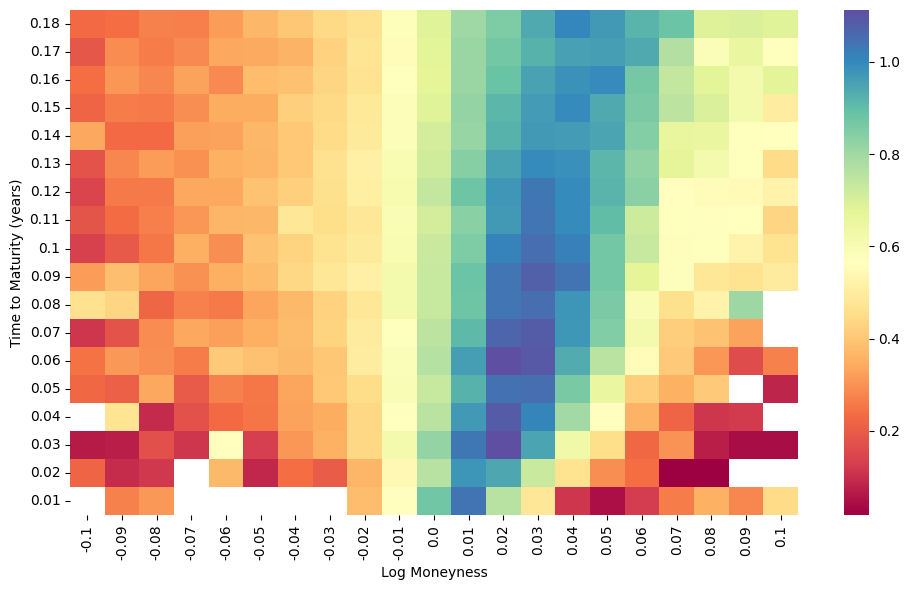

In [34]:
def plot_heatmap(data, values='re'):
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot(index='Time to Maturity (years)', columns='Log Moneyness', values=values)
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap=plt.cm.Spectral, cbar=True, 
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
plot_heatmap(df, 're')

d:\Users\adam\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


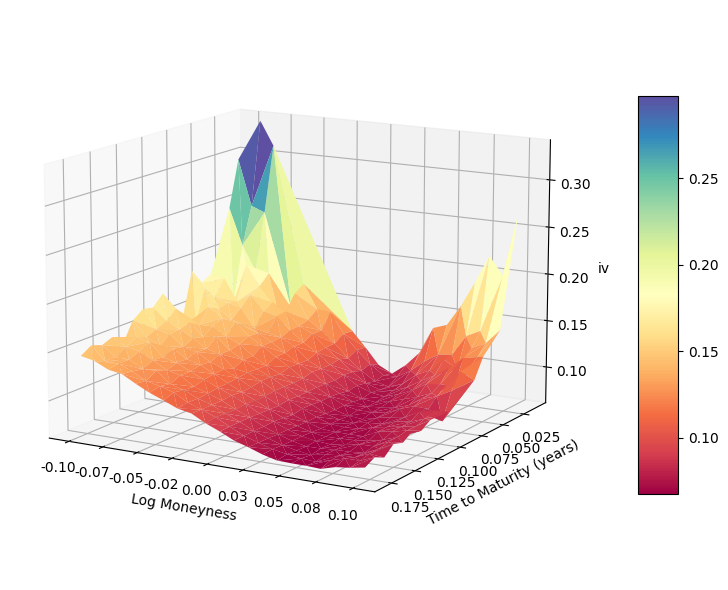

In [35]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca(projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()
plot_iv_surface(df, z='iv')

d:\Users\adam\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


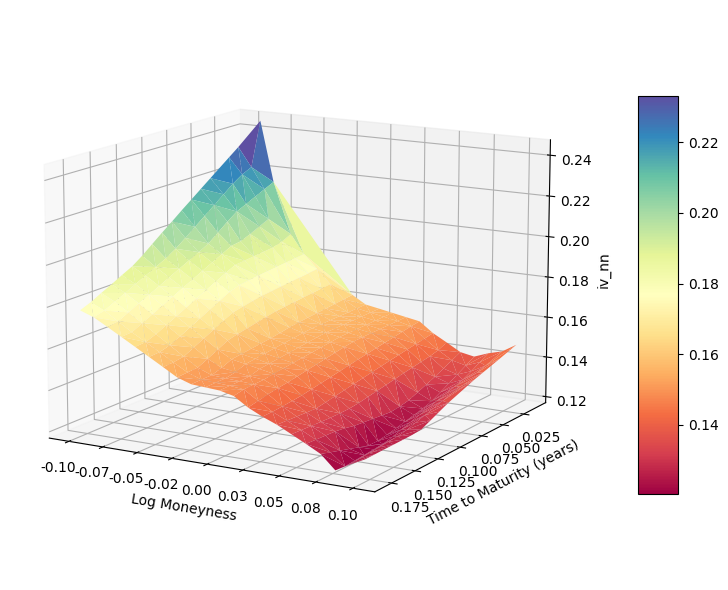

In [36]:
plot_iv_surface(df, z='iv_nn')

In [37]:
from utils import heston_pricer, rBergomi_pricer

In [38]:
from scipy.stats import truncnorm

def model_parameters_initializer(model='heston', random_seed=None):
    """ Initialize model parameters
    """
    if model == 'heston':
        params = [
            10 * np.random.rand(), # lambda
            np.random.rand(), # vbar
            5 * np.random.rand(), # eta
            -1 * np.random.rand(), # rho
            np.random.rand() #v0
        ]
        names = ['lambda', 'vbar', 'eta', 'rho', 'v0']
    elif model == 'rbergomi' or model == 'rBergomi':
        params = [
            truncnorm.rvs(-1.2, 8.6, 0.07, 0.05), # H
            truncnorm.rvs(-3, 3, 2.5, 0.5), # eta
            truncnorm.rvs(-0.25, 2.25, -0.95, 0.2), # rho
            truncnorm.rvs(-2.5, 7, 0.3, 0.1) # v0
        ]
        names = ['H', 'eta', 'rho', 'v0']
    else:
        raise NameError("No such model name: {}".format(model))
    return params, names
params_, names_ = model_parameters_initializer(model='rBergomi', random_seed=None)
params_

[0.013067829807668602,
 3.1735076300701217,
 -0.7968793907946048,
 0.27096745729084204]

In [39]:
def predict_label_jac(sess, model, test_inputs,model_name):
    """ Use a trained model to predict and to return jacobian matrix
    """
    if model_name=='heston':
        model = keras.models.load_model('heston.h5')
    else:
        model = keras.models.load_model('rBergomi.h5')
    print("Loaded Model from disk")
    #compile and evaluate loaded model
    model.compile(optimizer='adam', loss='mean_squared_error')
    pred = model.predict(test_inputs)
    grad_func = tf.gradients(model.output, model.input)
    jac = sess.run(grad_func, feed_dict={model.input: test_inputs})[0]
    return pred, jac

In [40]:
def deep_calibration(tf_sess, nn, K_T, market_quotes, model_name='heston', lambd_init=0.1, beta0=0.25, beta1=0.75, max_iter=1000, tol=1e-8):
    """ Combines LM algorithm with a NN regressor to calibrating model parameters.
    """
    # initialize model parameters
    params, param_names = model_parameters_initializer(model_name)
    
    # initalize learning step
    lambd = lambd_init
    
    n_samples = K_T.shape[0]
    n_params = len(params)
    I = np.eye(n_params)
    Q = market_quotes.reshape((-1, 1)) # shape: [n_samples, 1]
    K_T_values = K_T.values
    
    iter_count = 0
    
    # history to store some useful information during training 
    history = {
        'delta_params': {k: [] for k in param_names},
        'R': [],
        'lambda': [],
        'c_mu': []
    }
    
    # build a input dataframe by combining K_T and model parameters
    for i in range(len(param_names)):
        K_T[param_names[i]] = params[i]
    if model_name=='heston':

        input_data = K_T[['Moneyness','Time to Maturity (years)','lambda','vbar','eta','rho','v0']].values      ##np.insert(K_T_values, [2]*n_params, params, axis=1) # shape: [n_samples, n_params+2]
    else:
        input_data = K_T[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0']].values
    
    iv_nn, J = predict_label_jac(tf_sess, nn, input_data,model_name)
    R = iv_nn - Q # shape: [n_samples, 1]
    J = J[:, 2:] # shape: [n_samples, n_params], excluding K and T
    delta_params = np.linalg.pinv(J.T.dot(J) + lambd * I).dot(J.T.dot(R)).flatten() # vector size: [n_params,]
    
    history['R'].append(np.linalg.norm(R))
    history['lambda'].append(lambd)
    for param_idx, param_name in enumerate(param_names):
        history['delta_params'][param_name].append(delta_params[param_idx])

    while iter_count < max_iter and np.linalg.norm(delta_params) > tol:
        if iter_count % 50 == 0:
            logging.info("{}/{} iteration".format(iter_count+1, max_iter))
        params_new = params - delta_params
        input_data_new = np.insert(K_T_values, [2]*n_params, params_new, axis=1)
        iv_nn_new, J_new = predict_label_jac(tf_sess, nn, input_data_new,model_name)
        R_new = iv_nn_new - Q
        J_new = J_new[:, 2:]
        R_norm = np.linalg.norm(R)
        c_mu = (R_norm - np.linalg.norm(R_new)) / (R_norm - np.linalg.norm(R - J.dot(delta_params)))
        
        history['c_mu'].append(c_mu)
        
        if c_mu <= beta0:
            # reject delta_params
            lambd *= 2 # too slow, use greater lambd
        else:
            params = params_new
            R = R_new
            J = J_new
        if c_mu >=beta1:
            lambd /= 2.0
        
        delta_params = np.linalg.pinv(J.T.dot(J) + lambd * I).dot(J.T.dot(R)).flatten() # vector size: [n_params, ]
        iter_count += 1
        
        history['R'].append(np.linalg.norm(R))
        history['lambda'].append(lambd)
        for param_idx, param_name in enumerate(param_names):
            history['delta_params'][param_name].append(delta_params[param_idx])
    if iter_count < max_iter:
        logging.info("Leave iterations after {} iters".format(iter_count))
        
    return dict(zip(param_names, params)), history

In [41]:
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

In [42]:
K_T = X_test.iloc[:500,:][['Moneyness','Time to Maturity (years)']]
K_T_origin = X_test_origin.iloc[:500, :][['Moneyness','Time to Maturity (years)']]

In [43]:
X_test.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,-0.224647,0.744120,0.327494,0.585675,0.466685,1.733288
1,2.739951,-0.231177,1.203928,-0.781822,-1.523710,-1.433830
2,0.194809,0.852408,0.301868,0.961705,0.328430,-0.642639
3,-0.795508,-0.399744,-0.610912,-0.762449,-0.402033,1.152099
4,0.782763,-0.727378,0.501113,-0.351555,-1.580655,1.428017


In [44]:
K_T_origin.head()

,Moneyness,Time to Maturity (years)
0,1.064951,0.498520
1,0.968319,0.742324
2,1.075680,0.491391
3,0.951618,0.237476
4,0.919156,0.546817


In [45]:


S0 = 1                            
eta = 1.9
rho = -0.9
H = 0.07
v0 = 0.01
market_quotes = np.array([rBergomi_pricer(H, eta, rho, v0, K_T_origin.iloc[i, 1], K_T_origin.iloc[i, 0], S0)[1] for i in range(K_T.shape[0])])
market_quotes = market_quotes.reshape((-1, 1))

rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1623E1048>
Y is  [[ 0.          0.4760511   0.61607811 ... -1.32591554 -0.74911247
  -0.70268384]
 [ 0.          0.44566467 -0.43374305 ... -1.59865613 -0.64959239
  -0.30273169]
 [ 0.          0.2712387   0.01777453 ... -1.49402731 -2.13919099
  -1.67585856]
 ...
 [ 0.          0.45516834  0.92680937 ...  0.6961882  -0.8795821
   0.10205849]
 [ 0.         -1.12247797 -0.68975174 ...  1.79271732  0.73008959
   0.47247984]
 [ 0.          0.59127356 -0.09491072 ...  0.02238338 -0.10496791
   1.0589303 ]]
price is  0.0020315043553487976
rB is  <rbergomi.rbergomi.rBergomi object at 0x000001C1623E1DC8>
Y is  [[ 0.         -0.88318583 -0.14747312 ... -1.04587552  0.17722272
  -0.45877848]
 [ 0.         -1.39873045 -0.66019537 ...  0.40844336 -0.20330895
   0.29412883]
 [ 0.          0.04880579 -0.20254113 ...  0.81410913 -1.87979422
  -0.85755402]
 ...
 [ 0.          0.64272064  0.43152205 ... -1.15396252 -0.97780983
  -0.45736811]
 [ 0. 

In [46]:
valid_idx = ~np.isnan(market_quotes.flatten())
K_T_input = K_T.iloc[valid_idx, :]
market_quotes = market_quotes[valid_idx, :]

In [47]:
import keras as K
import keras
params, history = deep_calibration(sess, model, K_T_input, market_quotes, model_name='rbergomi', lambd_init=0.01, beta0=0.25, beta1=0.75, max_iter=1000)

d:\Users\adam\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\Users\adam\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2023-01-17 14:23:08,370 - INFO - 1/1000 iteration


Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk


2023-01-17 14:23:35,221 - INFO - Leave iterations after 37 iters


In [48]:
mu_hat = pd.DataFrame([params.values()], columns=params.keys())
mu_hat['Moneyness'] = 0
mu_hat['Time to Maturity (years)'] = 0
SCALER.inverse_transform(mu_hat[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0']])


,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.088126,0.991224,0.407418,3.317791,-0.943382,0.108811


## 根据得到的参数生成路径，带入GRU模型

In [49]:
from utils import heston_pricer
import numpy as np
import QuantLib as ql
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException
import logging

from rbergomi.rbergomi import rBergomi
def rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=40000):
    """Computes European Call price under rBergomi dynamics with MC sampling.
    
    Parameters:
    -----------
        H: Hurst parameter
        eta: volatility of variance
        rho: correlation between stock and vol
        v0: spot variance
        tau: time to maturity in years (365 trading days per year)
        K: strike price
    """
    rB = rBergomi(n=365, N=MC_samples, T=tau, a=H-0.5,S0=S0)
    dW1, dW2 = rB.dW1(), rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho)
    xi = v0
    V = rB.V(Y, xi, eta)
    S = rB.S(V, dB)
    ST = S[:, -1]
    price = np.mean(np.maximum(ST-K, 0))
    # print("price is ", price,aa.shape)

    # price 是期权价格，
    # S 是股票价格，将这部分数据传出来带入后面的GRU模型中去

    # 更改rbergomi模型，将模型中的S0当作一个初始话的参数，根据不同的
    
    # check numerical stability
    if price <= 0 or price + K < S0:
        iv = np.nan
        logging.debug("NumStabProblem: Price {}. Intrinsic {}. Time {}. Strike {}.".format(price, S0-K, tau, K))
    else:
        logging.debug("Success: Price {} > intrinsic {}".format(price, S0-K))
        iv = implied_volatility(price, S0, K, tau, 0, 'c')
    return S,iv # price, iv

H = 0.087744	
eta = 1.872348
rho = -0.902369
v0 = 0.1224
tau = 30/365
K = 100
S0 = 100
# rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=120000)
a,b = rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=120000)


In [50]:
# np.save('./data/deep_hedging/rb_price',a)
np.save('./data/deep_hedging/rb_price_0812',a)

## 检验股票价格数据和生成过程中的dW2的数据

In [51]:
import matplotlib.pyplot as plt

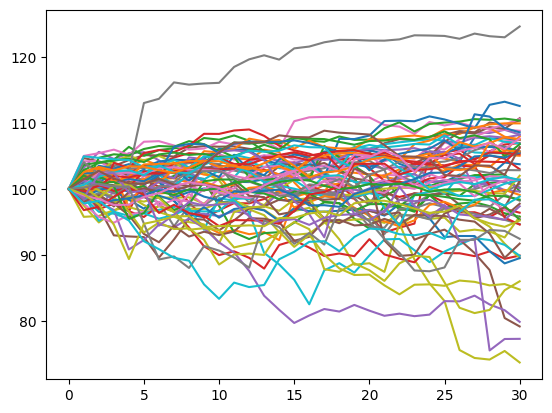

In [52]:
for i in range(70):
    plt.plot(a[10*i+1,:])
plt.show()

In [53]:
## 查看随机变量的结果
MC_samples = 4000
rB = rBergomi(n=365, N=MC_samples, T=tau, a=H-0.5,S0=S0)
dW1, dW2 = rB.dW1(), rB.dW2()

In [54]:
dW2.shape

(4000, 30)

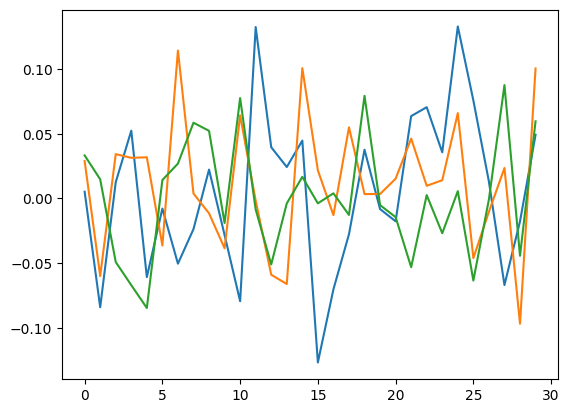

In [55]:
for i in range(3):
    plt.plot(dW2[10*i+1,:])

plt.show()